In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgbm
#from sklearn.experimental import enable_hist_gradient_boosting
#from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
import optuna

import matplotlib.pyplot as plt
import seaborn as sns


import joblib
from pathlib import Path
from warnings import filterwarnings
filterwarnings('ignore')

/home/arma/miniforge3/envs/teachopencadd/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Set path to this notebook
HERE = Path(_dh[-1])
HDAC1and6 = Path(HERE).resolve().parents[1]/'input'
output = HERE/'OUTPUT'

In [3]:
df = pd.read_pickle(HDAC1and6/"HDAC1and6_SemiSel_1024B.csv")
df = df.sample(frac=1).reset_index(drop=True)
df.head(5)

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,SelectivityWindow
0,CHEMBL2047673,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[799147, 169200, 1015231, 4630274, 193508, 129...",-0.25
1,CHEMBL2047689,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[38870925, 23625102, 744327, 11863091, 1125019...",-2.61
2,CHEMBL3655973,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, ...","[4856216, 2478511, 10872982, 4181618, 11932100...",2.42
3,CHEMBL473270,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[6411541, 10511, 137380, 9391761, 4030911, 163...",0.00
4,CHEMBL3353927,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, ...","[6279969, 177484, 2475943, 1255316, 2924166, 1...",0.00


In [4]:
df_labeled = pd.read_csv(HDAC1and6/"HDAC1and6_SemiSel_dataset.csv", )
df_labeled

,molecule_chembl_id,smiles,type_HDAC1,Standard_Value_HDAC1,pChEMBL_HDAC1,type_HDAC6,Standard_Value_HDAC6,pChEMBL_HDAC6,SelectivityRatio,SelectivityWindow,label
0,CHEMBL4098975,O=C(CCCCCCC(=O)Nc1ccc(NCCCn2cc(-c3ncnc4[nH]ccc...,IC50,109.647820,6.96,IC50,0.141254,9.85,776.247117,2.89,HDAC6-selective
1,CHEMBL3912061,CS(=O)(=O)NCCc1cn(Cc2ccc(C(=O)NO)cc2)c2ccccc12,IC50,616.595002,6.21,IC50,0.169824,9.77,3630.780548,3.56,HDAC6-selective
2,CHEMBL4243347,O=C(CCCCCCC(=O)Nc1ccc(Nc2nc(-c3cn[nH]c3)c3cc[n...,IC50,1.995262,8.70,IC50,0.199526,9.70,10.000000,1.00,Dual-binder
3,CHEMBL4247128,C=CCCn1cc(-c2nc(Nc3ccc(NC(=O)CCCCCCC(=O)NO)cc3...,IC50,83.176377,7.08,IC50,0.251189,9.60,331.131122,2.52,HDAC6-selective
4,CHEMBL4126811,CC(C)(C)OC(=O)Nc1ccc(-c2cc(C(=O)NCc3ccc(C(=O)N...,IC50,436.515832,6.36,IC50,0.331131,9.48,1318.256739,3.12,HDAC6-selective
...,...,...,...,...,...,...,...,...,...,...,...
1905,CHEMBL4167599,NCCCCNCCCCNCCCN1C(=O)c2ccc3c4c(ccc(c24)C1=O)C(...,IC50,4073.802778,5.39,IC50,50.118723,7.30,81.283052,1.91,Semi-selective
1906,CHEMBL4282471,CC(=O)Nc1ccc(-c2ccnc(Nc3ccc(NC(=O)CCCCC(=O)NO)...,IC50,3388.441561,5.47,IC50,117.489756,6.93,28.840315,1.46,Semi-selective
1907,CHEMBL470843,O=C(/C=C/c1ccc(-c2cc(CN3CCOCC3)on2)cc1)NO,IC50,6309.573445,5.20,IC50,173.780083,6.76,36.307805,1.56,Semi-selective
1908,CHEMBL3215861,CCCCc1nc2cc(/C=C/C(=O)NO)ccc2n1CCN(CC)CC,Ki,28.183829,7.55,Ki,245.470892,6.61,0.114815,-0.94,Dual-binder


In [5]:
df = pd.merge(df, df_labeled[['molecule_chembl_id',  'label']], on='molecule_chembl_id')

In [6]:
#df['Classes'] = np.where(df['label']== 'hDAC1-selective', 2)
df['Class'] = np.zeros(len(df))

df.loc[df[df.label == 'hDAC1-selective'].index, "Class"] = 1.0
df.loc[df[df.label == 'hDAC6-selective'].index, "Class"] = 2.0
df.loc[df[df.label == 'Dual-binder'].index, "Class"] = 3.0
df.loc[df[df.label == 'Non-binder'].index, "Class"] = 4.0
df.loc[df[df.label == 'Semi-selective'].index, "Class"] = 5.0
df.head(4)

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,SelectivityWindow,label,Class
0,CHEMBL2047673,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[799147, 169200, 1015231, 4630274, 193508, 129...",-0.25,Non-binder,4.0
1,CHEMBL2047689,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[38870925, 23625102, 744327, 11863091, 1125019...",-2.61,HDAC1-selective,0.0
2,CHEMBL3655973,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, ...","[4856216, 2478511, 10872982, 4181618, 11932100...",2.42,HDAC6-selective,0.0
3,CHEMBL473270,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[6411541, 10511, 137380, 9391761, 4030911, 163...",0.00,Dual-binder,3.0


In [7]:
# Add column for selectivity
df["selectivity"] = np.zeros(len(df))

# Mark every molecule as selective if SelectivityWindow is >=2 or >=-2, 0 otherwise
df.loc[df[df.SelectivityWindow >= 2.0].index, "selectivity"] = 1.0
df.loc[df[df.SelectivityWindow <= -2.0].index, "selectivity"] = 1.0
#By using Morgan fingerprints with radius of 3 and 1024 bits
indices =  np.array(df.index)
X = np.array(list((df['fp_Morgan3']))).astype(float)
#X.shape
Y = df["SelectivityWindow"].values
Y_cat =  df["selectivity"].values
Y_class = df['Class'].values

In [8]:
NUMS = 10
random_state= [146736, 1367, 209056, 1847464, 89563, 967034, 3689, 689547, 578929, 7458910]
X_tr_all = []
Y_tr_all = []
X_te_all = []
Y_te_all = []
Y_tr_class_all = []
Y_te_class_all = []
index_tr_all= []
index_te_all = []

for i in range(NUMS):
    X_tr, X_te, Y_tr, Y_te, Y_tr_class, Y_te_class, index_tr, index_te = train_test_split(X, Y, Y_class,indices, test_size=0.2, random_state=random_state[i], stratify=Y_class)
    X_tr_all.append(X_tr)
    Y_tr_all.append(Y_tr)
    X_te_all.append(X_te)
    Y_te_all.append(Y_te)
    Y_tr_class_all.append(Y_tr_class)
    Y_te_class_all.append(Y_te_class)
    index_tr_all.append(index_tr)
    index_te_all.append(index_te)
globals_dict = globals()
    
for i in range(0, len(index_te_all)):
    globals_dict[f"trainSet{i}"] = df.iloc[index_tr_all[i]]
    globals_dict[f"testSet{i}"] = df.iloc[index_te_all[i]]
    globals_dict[f"trainindex{i}"] = df.index[index_tr_all[i]]
    globals_dict[f"testindex{i}"] = df.index[index_te_all[i]]  
    globals_dict[f"X_trainSet{i}"] = np.array(list(df.iloc[index_tr_all[i]]['fp_Morgan3'])).astype(float)
    globals_dict[f"Y_trainSet{i}"] = np.array(list(df.iloc[index_tr_all[i]]['SelectivityWindow'])).astype(float)
    globals_dict[f"Y_trainSet{i}_cat"] = np.array(list(df.iloc[index_tr_all[i]]['selectivity'])).astype(float)
    globals_dict[f"Y_trainSet{i}_class"] = np.array(list(df.iloc[index_tr_all[i]]['Class'])).astype(float)
    globals_dict[f"X_testSet{i}"] = np.array(list(df.iloc[index_te_all[i]]['fp_Morgan3'])).astype(float)
    globals_dict[f"Y_testSet{i}"] = np.array(list(df.iloc[index_te_all[i]]['SelectivityWindow'])).astype(float)
    globals_dict[f"Y_testSet{i}_cat"] = np.array(list(df.iloc[index_te_all[i]]['selectivity'])).astype(float)
    globals_dict[f"Y_testSet{i}_class"] = np.array(list(df.iloc[index_te_all[i]]['Class'])).astype(float)
    

In [9]:
import sklearn.metrics
import math

def matrix_metrix(real_values,pred_values,beta):

    CM = confusion_matrix(real_values,pred_values)
    TN = CM[0][0]
    FN = CM[1][0] 
    TP = CM[1][1]
    FP = CM[0][1]
    Population = TN+FN+TP+FP
    Prevalence = round( (TP+FP) / Population,2)
    Accuracy   = round( (TP+TN) / Population,4)
    Precision  = round( TP / (TP+FP),4 )
    NPV        = round( TN / (TN+FN),4 )
    FDR        = round( FP / (TP+FP),4 )
    FOR        = round( FN / (TN+FN),4 ) 
    check_Pos  = Precision + FDR
    check_Neg  = NPV + FOR
    Recall     = round( TP / (TP+FN),4 )
    FPR        = round( FP / (TN+FP),4 )
    FNR        = round( FN / (TP+FN),4 )
    TNR        = round( TN / (TN+FP),4 ) 
    check_Pos2 = Recall + FNR
    check_Neg2 = FPR + TNR
    LRPos      = round( Recall/FPR,4 ) 
    LRNeg      = round( FNR / TNR ,4 )
    DOR        = round( LRPos/LRNeg)
    BalancedAccuracy = round( 0.5*(Recall+TNR),4)
    F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)   
    F1_weighted = round(f1_score(real_values, pred_values, average="weighted"), 4)
    F1_micro = round(f1_score(real_values, pred_values, average="micro"), 4)
    F1_macro = round(f1_score(real_values, pred_values, average="macro"), 4)
    FBeta      = round ( (1+beta**2)*((Precision*Recall)/((beta**2 * Precision)+ Recall)) ,4)
    MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
    BM         = Recall+TNR-1
    MK         = Precision+NPV-1

    mat_met = pd.DataFrame({
    'Metric':['TP','TN','FP','FN','Prevalence','Accuracy','Precision','NPV','FDR','FOR','check_Pos',
              'check_Neg','Recall','FPR','FNR','TNR','check_Pos2','check_Neg2','LR+','LR-','DOR','BalancedAccuracy',
              'F1','F1_weighted','F1_micro', 'F1_macro', 'FBeta','MCC','BM','MK'],     
    'Value':[TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LRPos,LRNeg,DOR,BalancedAccuracy,F1,F1_weighted,F1_micro, F1_macro, FBeta,MCC,BM,MK]})  
    return (mat_met)


## Random Forest 

In [10]:
%%time

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)

r2_scores = np.empty(10)
TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)


for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        x_train, x_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]

        rf_reg =  RandomForestRegressor(random_state=1121218, max_features = None, n_jobs=8,oob_score=True,
                                           max_samples=0.8, )
        rf_reg.fit(x_train, y_train)
        y_pred = rf_reg.predict(x_test)  
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.3
        y_test_cat = np.where( ((y_test>=2) | (y_test<= -2.0)), 1, 0) 
        y_pred_cat = np.where(((y_pred>=2) | (y_pred<= -2.0)), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)



mat_met_rf = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       }) 
                    
print(mat_met_rf)

                 Metric  Value (average)  Value (std)
0                    R2         0.710687     0.035787
1                    TP        16.800000     2.658320
2                    TN       154.600000     2.270585
3                    FP         3.000000     2.494438
4                    FN        16.600000     2.913570
5              Accuracy         0.897382     0.018337
6             Precision         0.858768     0.109618
7           Sensitivity         0.503595     0.084041
8           Specificity         0.981010     0.015742
9              F1 score         0.629529     0.073354
10  F1 score (weighted)         0.886016     0.021266
11     F1 score (macro)         0.784964     0.041604
12    Balanced Accuracy         0.742296     0.041782
13                  MCC         0.605535     0.080284
14                  NPV         0.903250     0.015623
15              ROC_AUC         0.742296     0.041782
CPU times: user 1min 40s, sys: 151 ms, total: 1min 40s
Wall time: 14.6 s


In [11]:
import optuna  


def objective_rf_CV(trial, X, Y, Y_class):
    param_grid = {
    #min_samples_split : trial.suggest_int('min_samples_split', 2, 50)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 25)
    #max_depth = trial.suggest_int('max_depth', 1, 10000)
    #"max_features" : trial.suggest_categorical("max_features", [None]),
    #oob_score = trial.suggest_categorical('oob_score', ['True','False']),
    #max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }
    
    

    cv_scores = np.empty(10)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        x_train, x_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        rf = RandomForestRegressor(**param_grid, n_jobs=8, random_state=1121218, max_features = None, 
                                   oob_score=True,
                                   max_samples=0.8,) 
        
        rf.fit(x_train, y_train)
        y_pred = rf.predict(x_test)
        cv_scores[idx] = r2_score(y_test, y_pred)
      
    
    return np.mean(cv_scores)

In [12]:
def detailed_objective_rf_CV(trial,X, Y, Y_class):
    param_grid = {
    #min_samples_split : trial.suggest_int('min_samples_split', 2, 50)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 25)
    #max_depth = trial.suggest_int('max_depth', 1, 10000)
    #"max_features" : trial.suggest_categorical("max_features", [None]),
    #oob_score = trial.suggest_categorical('oob_score', ['True','False']),
    #max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }
    
    
    r2_scores = np.empty(10)
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W=np.empty(10)
    f1_scores_M=np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        rf = RandomForestRegressor(**param_grid, n_jobs=8, random_state=1121218, max_features = None, oob_score=True,
                                           max_samples=0.8,)
   
        #X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # convert to categorical values
        y_test_cat = np.where( ((y_test>=2) | (y_test<= -2.0)), 1, 0) 
        y_pred_cat = np.where(((y_pred>=2) | (y_pred<= -2.0)), 1, 0)
       
           
        #calculate parameters
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)      
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)

    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
    return (mat_met)
    
  

In [13]:
#Execute optuna and set hyperparameters
study_rf = optuna.create_study(direction='maximize', study_name="RFRegressor")
func_rf_0 = lambda trial: objective_rf_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_rf.optimize(func_rf_0, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 19:13:53,439] A new study created in memory with name: RFRegressor
[I 2023-12-11 19:14:50,596] Trial 0 finished with value: 0.7015603894214231 and parameters: {'n_estimators': 561}. Best is trial 0 with value: 0.7015603894214231.
[I 2023-12-11 19:15:34,639] Trial 1 finished with value: 0.700516786862845 and parameters: {'n_estimators': 439}. Best is trial 0 with value: 0.7015603894214231.
[I 2023-12-11 19:16:26,074] Trial 2 finished with value: 0.7015648239727807 and parameters: {'n_estimators': 515}. Best is trial 2 with value: 0.7015648239727807.
[I 2023-12-11 19:17:51,593] Trial 3 finished with value: 0.7014482251705475 and parameters: {'n_estimators': 854}. Best is trial 2 with value: 0.7015648239727807.
[I 2023-12-11 19:18:27,231] Trial 4 finished with value: 0.7003452777377122 and parameters: {'n_estimators': 337}. Best is trial 2 with value: 0.7015648239727807.
[I 2023-12-11 19:20:14,408] Trial 5 finished with value: 0.7012117254832679 and parameters: {'n_estimator

	Number of trials: 50.0
	Best value (r2_score): 0.7021
	Best params:
		n_estimators: 620


In [14]:
optimized_rf_0 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
 
data_testing = pd.DataFrame()    
    
optimized_rf_0.fit(X_trainSet0, Y_trainSet0,)

#predict        
y_pred_rf_0 = optimized_rf_0.predict(X_testSet0)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet0, y_pred_rf_0)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet0 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_rf_0_cat = np.where(((y_pred_rf_0 >= 2) | (y_pred_rf_0 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_rf_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_rf_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_rf_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_rf_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_rf_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_rf_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_rf_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_rf_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_rf_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_rf_0_cat)
data_testing['y_test_idx0'] = testindex0
data_testing['y_test_Set0'] = Y_testSet0
data_testing['y_pred_Set0'] = y_pred_rf_0


mat_met_rf_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
    
print(mat_met_rf_test)


                 Metric        Set0
0                    R2    0.648886
1                    TP   29.000000
2                    TN  313.000000
3                    FP    3.000000
4                    FN   37.000000
5              Accuracy    0.895288
6             Precision    0.906250
7           Sensitivity    0.439394
8           Specificity    0.990500
9              F1 score    0.591837
10  F1 score (weighted)    0.879796
11     F1 score (macro)    0.765888
12    Balanced Accuracy    0.714950
13                  MCC    0.586643
14                  NPV    0.894300
15              ROC_AUC    0.714950


In [15]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_1 = lambda trial: objective_rf_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_rf.optimize(func_rf_1, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 20:10:31,160] Trial 50 finished with value: 0.690526950908841 and parameters: {'n_estimators': 586}. Best is trial 23 with value: 0.7021168944389337.
[I 2023-12-11 20:11:56,363] Trial 51 finished with value: 0.690140787534421 and parameters: {'n_estimators': 745}. Best is trial 23 with value: 0.7021168944389337.
[I 2023-12-11 20:13:17,118] Trial 52 finished with value: 0.6901397095686598 and parameters: {'n_estimators': 701}. Best is trial 23 with value: 0.7021168944389337.
[I 2023-12-11 20:14:52,892] Trial 53 finished with value: 0.6904101677138135 and parameters: {'n_estimators': 820}. Best is trial 23 with value: 0.7021168944389337.
[I 2023-12-11 20:16:11,961] Trial 54 finished with value: 0.6901166826082387 and parameters: {'n_estimators': 668}. Best is trial 23 with value: 0.7021168944389337.
[I 2023-12-11 20:17:40,164] Trial 55 finished with value: 0.6903109911207548 and parameters: {'n_estimators': 770}. Best is trial 23 with value: 0.7021168944389337.
[I 2023-12-1

	Number of trials: 100.0
	Best value (r2_score): 0.7021
	Best params:
		n_estimators: 620


In [16]:
optimized_rf_1 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_1.fit(X_trainSet1, Y_trainSet1,)

#predict        
y_pred_rf_1 = optimized_rf_1.predict(X_testSet1)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet1, y_pred_rf_1)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet1 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_rf_1_cat = np.where(((y_pred_rf_1 >= 2) | (y_pred_rf_1 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_rf_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_rf_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_rf_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_rf_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_rf_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_rf_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_rf_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_rf_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_rf_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_rf_1_cat)
data_testing['y_test_idx1'] = testindex1
data_testing['y_test_Set1'] = Y_testSet1
data_testing['y_pred_Set1'] = y_pred_rf_1


set1 = pd.DataFrame({ 'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_rf_test['Set1'] =set1
print(mat_met_rf_test)


                 Metric        Set0        Set1
0                    R2    0.648886    0.676902
1                    TP   29.000000   35.000000
2                    TN  313.000000  309.000000
3                    FP    3.000000    6.000000
4                    FN   37.000000   32.000000
5              Accuracy    0.895288    0.900524
6             Precision    0.906250    0.853659
7           Sensitivity    0.439394    0.522388
8           Specificity    0.990500    0.981000
9              F1 score    0.591837    0.648148
10  F1 score (weighted)    0.879796    0.890521
11     F1 score (macro)    0.765888    0.795111
12    Balanced Accuracy    0.714950    0.751670
13                  MCC    0.586643    0.618423
14                  NPV    0.894300    0.906200
15              ROC_AUC    0.714950    0.751670


In [17]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_2 = lambda trial: objective_rf_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_rf.optimize(func_rf_2, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 21:15:44,825] Trial 100 finished with value: 0.6948369324447503 and parameters: {'n_estimators': 714}. Best is trial 23 with value: 0.7021168944389337.
[I 2023-12-11 21:16:54,787] Trial 101 finished with value: 0.694768154735337 and parameters: {'n_estimators': 619}. Best is trial 23 with value: 0.7021168944389337.
[I 2023-12-11 21:18:10,339] Trial 102 finished with value: 0.6947906553599539 and parameters: {'n_estimators': 660}. Best is trial 23 with value: 0.7021168944389337.
[I 2023-12-11 21:19:16,263] Trial 103 finished with value: 0.6945344566310204 and parameters: {'n_estimators': 587}. Best is trial 23 with value: 0.7021168944389337.
[I 2023-12-11 21:20:15,788] Trial 104 finished with value: 0.6948841139027953 and parameters: {'n_estimators': 535}. Best is trial 23 with value: 0.7021168944389337.
[I 2023-12-11 21:21:18,216] Trial 105 finished with value: 0.6945558791471873 and parameters: {'n_estimators': 559}. Best is trial 23 with value: 0.7021168944389337.
[I 20

	Number of trials: 150.0
	Best value (r2_score): 0.7021
	Best params:
		n_estimators: 620


In [18]:

optimized_rf_2 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_2.fit(X_trainSet2, Y_trainSet2,)

#predict        
y_pred_rf_2 = optimized_rf_2.predict(X_testSet2)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet2, y_pred_rf_2)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet2 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_rf_2_cat = np.where(((y_pred_rf_2 >= 2) | (y_pred_rf_2 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_rf_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_rf_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_rf_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_rf_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_rf_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_rf_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_rf_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_rf_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_rf_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_rf_2_cat)
data_testing['y_test_idx2'] = testindex2
data_testing['y_test_Set2'] = Y_testSet2
data_testing['y_pred_Set2'] = y_pred_rf_2

set2 = pd.DataFrame({'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_rf_test['Set2'] =set2
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.648886    0.676902    0.673941
1                    TP   29.000000   35.000000   34.000000
2                    TN  313.000000  309.000000  311.000000
3                    FP    3.000000    6.000000    4.000000
4                    FN   37.000000   32.000000   33.000000
5              Accuracy    0.895288    0.900524    0.903141
6             Precision    0.906250    0.853659    0.894737
7           Sensitivity    0.439394    0.522388    0.507463
8           Specificity    0.990500    0.981000    0.987300
9              F1 score    0.591837    0.648148    0.647619
10  F1 score (weighted)    0.879796    0.890521    0.891897
11     F1 score (macro)    0.765888    0.795111    0.795737
12    Balanced Accuracy    0.714950    0.751670    0.747382
13                  MCC    0.586643    0.618423    0.628666
14                  NPV    0.894300    0.906200    0.904100
15              ROC_AUC    0.714950    0

In [19]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_3 = lambda trial: objective_rf_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_rf.optimize(func_rf_3, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 22:14:50,553] Trial 150 finished with value: 0.703286046513856 and parameters: {'n_estimators': 650}. Best is trial 150 with value: 0.703286046513856.
[I 2023-12-11 22:15:55,824] Trial 151 finished with value: 0.7033095747526031 and parameters: {'n_estimators': 646}. Best is trial 151 with value: 0.7033095747526031.
[I 2023-12-11 22:17:00,732] Trial 152 finished with value: 0.7032271810721701 and parameters: {'n_estimators': 648}. Best is trial 151 with value: 0.7033095747526031.
[I 2023-12-11 22:18:05,423] Trial 153 finished with value: 0.703178440878504 and parameters: {'n_estimators': 657}. Best is trial 151 with value: 0.7033095747526031.
[I 2023-12-11 22:19:10,399] Trial 154 finished with value: 0.7031903414032261 and parameters: {'n_estimators': 655}. Best is trial 151 with value: 0.7033095747526031.
[I 2023-12-11 22:20:15,863] Trial 155 finished with value: 0.7032778650401459 and parameters: {'n_estimators': 653}. Best is trial 151 with value: 0.7033095747526031.
[

	Number of trials: 200.0
	Best value (r2_score): 0.7035
	Best params:
		n_estimators: 637


In [20]:
optimized_rf_3 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_3.fit(X_trainSet3, Y_trainSet3,)

#predict        
y_pred_rf_3 = optimized_rf_3.predict(X_testSet3)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet3, y_pred_rf_3)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet3 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_rf_3_cat = np.where(((y_pred_rf_3 >= 2) | (y_pred_rf_3 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_rf_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_rf_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_rf_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_rf_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_rf_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_rf_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_rf_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_rf_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_rf_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_rf_3_cat)
data_testing['y_test_idx3'] = testindex3
data_testing['y_test_Set3'] = Y_testSet3
data_testing['y_pred_Set3'] = y_pred_rf_3


set3 = pd.DataFrame({'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set3'] =set3   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.648886    0.676902    0.673941    0.680771
1                    TP   29.000000   35.000000   34.000000   31.000000
2                    TN  313.000000  309.000000  311.000000  312.000000
3                    FP    3.000000    6.000000    4.000000    2.000000
4                    FN   37.000000   32.000000   33.000000   37.000000
5              Accuracy    0.895288    0.900524    0.903141    0.897906
6             Precision    0.906250    0.853659    0.894737    0.939394
7           Sensitivity    0.439394    0.522388    0.507463    0.455882
8           Specificity    0.990500    0.981000    0.987300    0.993600
9              F1 score    0.591837    0.648148    0.647619    0.613861
10  F1 score (weighted)    0.879796    0.890521    0.891897    0.882911
11     F1 score (macro)    0.765888    0.795111    0.795737    0.777519
12    Balanced Accuracy    0.714950    0.751670    0.747382    0

In [21]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_4 = lambda trial: objective_rf_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_rf.optimize(func_rf_4, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 23:08:24,935] Trial 200 finished with value: 0.6879162641927911 and parameters: {'n_estimators': 572}. Best is trial 179 with value: 0.703533233688111.
[I 2023-12-11 23:09:27,520] Trial 201 finished with value: 0.6879936737932772 and parameters: {'n_estimators': 628}. Best is trial 179 with value: 0.703533233688111.
[I 2023-12-11 23:10:26,165] Trial 202 finished with value: 0.6878842866040913 and parameters: {'n_estimators': 597}. Best is trial 179 with value: 0.703533233688111.
[I 2023-12-11 23:11:28,265] Trial 203 finished with value: 0.6880312789442881 and parameters: {'n_estimators': 631}. Best is trial 179 with value: 0.703533233688111.
[I 2023-12-11 23:12:28,614] Trial 204 finished with value: 0.6879512920771987 and parameters: {'n_estimators': 606}. Best is trial 179 with value: 0.703533233688111.
[I 2023-12-11 23:13:28,868] Trial 205 finished with value: 0.6879369796306444 and parameters: {'n_estimators': 633}. Best is trial 179 with value: 0.703533233688111.
[I 2

	Number of trials: 250.0
	Best value (r2_score): 0.7035
	Best params:
		n_estimators: 637


In [22]:
optimized_rf_4 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_4.fit(X_trainSet4, Y_trainSet4,)

#predict        
y_pred_rf_4 = optimized_rf_4.predict(X_testSet4)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet4, y_pred_rf_4)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet4 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_rf_4_cat = np.where(((y_pred_rf_4 >= 2) | (y_pred_rf_4 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_rf_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_rf_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_rf_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_rf_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_rf_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_rf_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_rf_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_rf_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_rf_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_rf_4_cat)
data_testing['y_test_idx4'] = testindex4
data_testing['y_test_Set4'] = Y_testSet4
data_testing['y_pred_Set4'] = y_pred_rf_4

set4 = pd.DataFrame({'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set4'] =set4   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.648886    0.676902    0.673941    0.680771   
1                    TP   29.000000   35.000000   34.000000   31.000000   
2                    TN  313.000000  309.000000  311.000000  312.000000   
3                    FP    3.000000    6.000000    4.000000    2.000000   
4                    FN   37.000000   32.000000   33.000000   37.000000   
5              Accuracy    0.895288    0.900524    0.903141    0.897906   
6             Precision    0.906250    0.853659    0.894737    0.939394   
7           Sensitivity    0.439394    0.522388    0.507463    0.455882   
8           Specificity    0.990500    0.981000    0.987300    0.993600   
9              F1 score    0.591837    0.648148    0.647619    0.613861   
10  F1 score (weighted)    0.879796    0.890521    0.891897    0.882911   
11     F1 score (macro)    0.765888    0.795111    0.795737    0.777519   
12    Balanced Accuracy  

In [23]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_5 = lambda trial: objective_rf_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_rf.optimize(func_rf_5, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 00:01:35,040] Trial 250 finished with value: 0.6840773499256034 and parameters: {'n_estimators': 667}. Best is trial 179 with value: 0.703533233688111.
[I 2023-12-12 00:02:39,046] Trial 251 finished with value: 0.6840873384661807 and parameters: {'n_estimators': 642}. Best is trial 179 with value: 0.703533233688111.
[I 2023-12-12 00:03:38,845] Trial 252 finished with value: 0.6838704867761832 and parameters: {'n_estimators': 603}. Best is trial 179 with value: 0.703533233688111.
[I 2023-12-12 00:04:39,792] Trial 253 finished with value: 0.6840709056259444 and parameters: {'n_estimators': 626}. Best is trial 179 with value: 0.703533233688111.
[I 2023-12-12 00:05:43,454] Trial 254 finished with value: 0.684213616005765 and parameters: {'n_estimators': 652}. Best is trial 179 with value: 0.703533233688111.
[I 2023-12-12 00:06:41,681] Trial 255 finished with value: 0.683658114984741 and parameters: {'n_estimators': 581}. Best is trial 179 with value: 0.703533233688111.
[I 202

	Number of trials: 300.0
	Best value (r2_score): 0.7035
	Best params:
		n_estimators: 637


In [24]:
optimized_rf_5 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_5.fit(X_trainSet5, Y_trainSet5,)

#predict        
y_pred_rf_5 = optimized_rf_5.predict(X_testSet5)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet5, y_pred_rf_5)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet5 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_rf_5_cat = np.where(((y_pred_rf_5 >= 2) | (y_pred_rf_5 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_rf_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_rf_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_rf_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_rf_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_rf_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_rf_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_rf_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_rf_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_rf_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_rf_5_cat)
data_testing['y_test_idx5'] = testindex5
data_testing['y_test_Set5'] = Y_testSet5
data_testing['y_pred_Set5'] = y_pred_rf_5


Set5 = pd.DataFrame({'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set5'] =Set5   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.648886    0.676902    0.673941    0.680771   
1                    TP   29.000000   35.000000   34.000000   31.000000   
2                    TN  313.000000  309.000000  311.000000  312.000000   
3                    FP    3.000000    6.000000    4.000000    2.000000   
4                    FN   37.000000   32.000000   33.000000   37.000000   
5              Accuracy    0.895288    0.900524    0.903141    0.897906   
6             Precision    0.906250    0.853659    0.894737    0.939394   
7           Sensitivity    0.439394    0.522388    0.507463    0.455882   
8           Specificity    0.990500    0.981000    0.987300    0.993600   
9              F1 score    0.591837    0.648148    0.647619    0.613861   
10  F1 score (weighted)    0.879796    0.890521    0.891897    0.882911   
11     F1 score (macro)    0.765888    0.795111    0.795737    0.777519   
12    Balanced Accuracy  

In [25]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_6 = lambda trial: objective_rf_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_rf.optimize(func_rf_6, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 00:52:59,642] Trial 300 finished with value: 0.6884195930827457 and parameters: {'n_estimators': 623}. Best is trial 179 with value: 0.703533233688111.
[I 2023-12-12 00:53:52,372] Trial 301 finished with value: 0.6884672906707944 and parameters: {'n_estimators': 601}. Best is trial 179 with value: 0.703533233688111.
[I 2023-12-12 00:54:50,329] Trial 302 finished with value: 0.6887494265998975 and parameters: {'n_estimators': 656}. Best is trial 179 with value: 0.703533233688111.
[I 2023-12-12 00:55:46,325] Trial 303 finished with value: 0.6886043861432245 and parameters: {'n_estimators': 633}. Best is trial 179 with value: 0.703533233688111.
[I 2023-12-12 00:56:41,593] Trial 304 finished with value: 0.6885986936026478 and parameters: {'n_estimators': 618}. Best is trial 179 with value: 0.703533233688111.
[I 2023-12-12 00:57:38,577] Trial 305 finished with value: 0.6886594876194441 and parameters: {'n_estimators': 645}. Best is trial 179 with value: 0.703533233688111.
[I 2

	Number of trials: 350.0
	Best value (r2_score): 0.7035
	Best params:
		n_estimators: 637


In [26]:
optimized_rf_6 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_6.fit(X_trainSet6, Y_trainSet6,)

#predict        
y_pred_rf_6 = optimized_rf_6.predict(X_testSet6)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet6, y_pred_rf_6)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet6 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_rf_6_cat = np.where(((y_pred_rf_6 >= 2) | (y_pred_rf_6 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_rf_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_rf_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_rf_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_rf_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_rf_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_rf_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_rf_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_rf_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_rf_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_rf_6_cat)
data_testing['y_test_idx6'] = testindex6
data_testing['y_test_Set6'] = Y_testSet6
data_testing['y_pred_Set6'] = y_pred_rf_6


Set6 = pd.DataFrame({'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set6'] =Set6   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.648886    0.676902    0.673941    0.680771   
1                    TP   29.000000   35.000000   34.000000   31.000000   
2                    TN  313.000000  309.000000  311.000000  312.000000   
3                    FP    3.000000    6.000000    4.000000    2.000000   
4                    FN   37.000000   32.000000   33.000000   37.000000   
5              Accuracy    0.895288    0.900524    0.903141    0.897906   
6             Precision    0.906250    0.853659    0.894737    0.939394   
7           Sensitivity    0.439394    0.522388    0.507463    0.455882   
8           Specificity    0.990500    0.981000    0.987300    0.993600   
9              F1 score    0.591837    0.648148    0.647619    0.613861   
10  F1 score (weighted)    0.879796    0.890521    0.891897    0.882911   
11     F1 score (macro)    0.765888    0.795111    0.795737    0.777519   
12    Balanced Accuracy  

In [27]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_7 = lambda trial: objective_rf_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_rf.optimize(func_rf_7, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 01:38:30,226] Trial 350 finished with value: 0.7082594836354945 and parameters: {'n_estimators': 620}. Best is trial 350 with value: 0.7082594836354945.
[I 2023-12-12 01:39:20,318] Trial 351 finished with value: 0.708076954232989 and parameters: {'n_estimators': 614}. Best is trial 350 with value: 0.7082594836354945.
[I 2023-12-12 01:40:06,471] Trial 352 finished with value: 0.7083328945924433 and parameters: {'n_estimators': 566}. Best is trial 352 with value: 0.7083328945924433.
[I 2023-12-12 01:40:52,587] Trial 353 finished with value: 0.7082988980871535 and parameters: {'n_estimators': 565}. Best is trial 352 with value: 0.7083328945924433.
[I 2023-12-12 01:41:38,211] Trial 354 finished with value: 0.7082561451768936 and parameters: {'n_estimators': 560}. Best is trial 352 with value: 0.7083328945924433.
[I 2023-12-12 01:42:24,126] Trial 355 finished with value: 0.7082769886573346 and parameters: {'n_estimators': 564}. Best is trial 352 with value: 0.7083328945924433.

	Number of trials: 400.0
	Best value (r2_score): 0.7087
	Best params:
		n_estimators: 368


In [28]:
optimized_rf_7 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_7.fit(X_trainSet7, Y_trainSet7,)

#predict        
y_pred_rf_7 = optimized_rf_7.predict(X_testSet7)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet7, y_pred_rf_7)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet7 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_rf_7_cat = np.where(((y_pred_rf_7 >= 2) | (y_pred_rf_7 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_rf_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_rf_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_rf_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_rf_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_rf_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_rf_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_rf_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_rf_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_rf_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_rf_7_cat)
data_testing['y_test_idx7'] = testindex7
data_testing['y_test_Set7'] = Y_testSet7
data_testing['y_pred_Set7'] = y_pred_rf_7

Set7 = pd.DataFrame({'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set7'] =Set7   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.648886    0.676902    0.673941    0.680771   
1                    TP   29.000000   35.000000   34.000000   31.000000   
2                    TN  313.000000  309.000000  311.000000  312.000000   
3                    FP    3.000000    6.000000    4.000000    2.000000   
4                    FN   37.000000   32.000000   33.000000   37.000000   
5              Accuracy    0.895288    0.900524    0.903141    0.897906   
6             Precision    0.906250    0.853659    0.894737    0.939394   
7           Sensitivity    0.439394    0.522388    0.507463    0.455882   
8           Specificity    0.990500    0.981000    0.987300    0.993600   
9              F1 score    0.591837    0.648148    0.647619    0.613861   
10  F1 score (weighted)    0.879796    0.890521    0.891897    0.882911   
11     F1 score (macro)    0.765888    0.795111    0.795737    0.777519   
12    Balanced Accuracy  

In [29]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_8 = lambda trial: objective_rf_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_rf.optimize(func_rf_8, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 02:09:34,102] Trial 400 finished with value: 0.6961621967862964 and parameters: {'n_estimators': 377}. Best is trial 399 with value: 0.7086965412676856.
[I 2023-12-12 02:10:01,325] Trial 401 finished with value: 0.6961322996359092 and parameters: {'n_estimators': 332}. Best is trial 399 with value: 0.7086965412676856.
[I 2023-12-12 02:10:33,380] Trial 402 finished with value: 0.6961394115508946 and parameters: {'n_estimators': 391}. Best is trial 399 with value: 0.7086965412676856.
[I 2023-12-12 02:11:09,423] Trial 403 finished with value: 0.6962366628689658 and parameters: {'n_estimators': 434}. Best is trial 399 with value: 0.7086965412676856.
[I 2023-12-12 02:11:37,940] Trial 404 finished with value: 0.6964371885648694 and parameters: {'n_estimators': 347}. Best is trial 399 with value: 0.7086965412676856.
[I 2023-12-12 02:12:11,065] Trial 405 finished with value: 0.695989428133042 and parameters: {'n_estimators': 407}. Best is trial 399 with value: 0.7086965412676856.

	Number of trials: 450.0
	Best value (r2_score): 0.7087
	Best params:
		n_estimators: 368


In [30]:
optimized_rf_8 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_8.fit(X_trainSet8, Y_trainSet8,)

#predict        
y_pred_rf_8 = optimized_rf_8.predict(X_testSet8)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet8, y_pred_rf_8)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet8 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_rf_8_cat = np.where(((y_pred_rf_8 >= 2) | (y_pred_rf_8 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_rf_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_rf_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_rf_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_rf_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_rf_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_rf_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_rf_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_rf_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_rf_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_rf_8_cat)
data_testing['y_test_idx8'] = testindex8
data_testing['y_test_Set8'] = Y_testSet8
data_testing['y_pred_Set8'] = y_pred_rf_8

Set8 = pd.DataFrame({'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set8'] =Set8   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.648886    0.676902    0.673941    0.680771   
1                    TP   29.000000   35.000000   34.000000   31.000000   
2                    TN  313.000000  309.000000  311.000000  312.000000   
3                    FP    3.000000    6.000000    4.000000    2.000000   
4                    FN   37.000000   32.000000   33.000000   37.000000   
5              Accuracy    0.895288    0.900524    0.903141    0.897906   
6             Precision    0.906250    0.853659    0.894737    0.939394   
7           Sensitivity    0.439394    0.522388    0.507463    0.455882   
8           Specificity    0.990500    0.981000    0.987300    0.993600   
9              F1 score    0.591837    0.648148    0.647619    0.613861   
10  F1 score (weighted)    0.879796    0.890521    0.891897    0.882911   
11     F1 score (macro)    0.765888    0.795111    0.795737    0.777519   
12    Balanced Accuracy  

In [31]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_9 = lambda trial: objective_rf_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_rf.optimize(func_rf_9, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 02:36:52,632] Trial 450 finished with value: 0.693287887542311 and parameters: {'n_estimators': 420}. Best is trial 399 with value: 0.7086965412676856.
[I 2023-12-12 02:37:29,352] Trial 451 finished with value: 0.6933858658972875 and parameters: {'n_estimators': 445}. Best is trial 399 with value: 0.7086965412676856.
[I 2023-12-12 02:38:03,237] Trial 452 finished with value: 0.6933038696810534 and parameters: {'n_estimators': 409}. Best is trial 399 with value: 0.7086965412676856.
[I 2023-12-12 02:38:35,520] Trial 453 finished with value: 0.693859257617528 and parameters: {'n_estimators': 390}. Best is trial 399 with value: 0.7086965412676856.
[I 2023-12-12 02:39:10,201] Trial 454 finished with value: 0.693287887542311 and parameters: {'n_estimators': 420}. Best is trial 399 with value: 0.7086965412676856.
[I 2023-12-12 02:39:46,728] Trial 455 finished with value: 0.6934336233997211 and parameters: {'n_estimators': 442}. Best is trial 399 with value: 0.7086965412676856.
[

	Number of trials: 500.0
	Best value (r2_score): 0.7087
	Best params:
		n_estimators: 368


In [32]:
optimized_rf_9 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_9.fit(X_trainSet9, Y_trainSet9,)

#predict        
y_pred_rf_9 = optimized_rf_9.predict(X_testSet9)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet9, y_pred_rf_9)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet9 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_rf_9_cat = np.where(((y_pred_rf_9 >= 2) | (y_pred_rf_9 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_rf_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_rf_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_rf_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_rf_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_rf_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_rf_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_rf_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_rf_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_rf_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_rf_9_cat)
data_testing['y_test_idx9'] = testindex9
data_testing['y_test_Set9'] = Y_testSet9
data_testing['y_pred_Set9'] = y_pred_rf_9

Set9 = pd.DataFrame({'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set9'] =Set9   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.648886    0.676902    0.673941    0.680771   
1                    TP   29.000000   35.000000   34.000000   31.000000   
2                    TN  313.000000  309.000000  311.000000  312.000000   
3                    FP    3.000000    6.000000    4.000000    2.000000   
4                    FN   37.000000   32.000000   33.000000   37.000000   
5              Accuracy    0.895288    0.900524    0.903141    0.897906   
6             Precision    0.906250    0.853659    0.894737    0.939394   
7           Sensitivity    0.439394    0.522388    0.507463    0.455882   
8           Specificity    0.990500    0.981000    0.987300    0.993600   
9              F1 score    0.591837    0.648148    0.647619    0.613861   
10  F1 score (weighted)    0.879796    0.890521    0.891897    0.882911   
11     F1 score (macro)    0.765888    0.795111    0.795737    0.777519   
12    Balanced Accuracy  

In [33]:
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

	Number of trials: 500.0
	Best value (r2_score): 0.7087
	Best params:
		n_estimators: 368


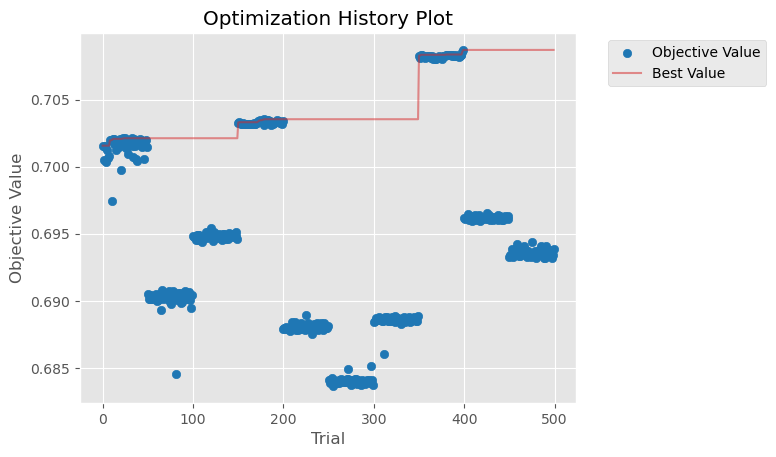

In [34]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_rf);

In [35]:
detailed_objective_rf_CV(study_rf.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,R2,0.714101,0.036192
1,TP,16.800000,2.529822
2,TN,155.000000,2.160247
3,FP,2.600000,2.319004
4,FN,16.600000,2.796824
5,Accuracy,0.899476,0.015765
6,Precision,0.876224,0.097241
7,Sensitivity,0.503595,0.080316
8,Specificity,0.983530,0.014637
9,F1 score,0.634265,0.065840


In [36]:
mat_met_rf_test['ave'] = mat_met_rf_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_rf_test['std'] = mat_met_rf_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_rf_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.648886,0.676902,0.673941,0.680771,0.707861,0.711177,0.704579,0.666527,0.671576,0.713789,0.685601,0.022231
1,TP,29.000000,35.000000,34.000000,31.000000,32.000000,32.000000,26.000000,32.000000,32.000000,34.000000,31.700000,2.626785
2,TN,313.000000,309.000000,311.000000,312.000000,313.000000,311.000000,310.000000,311.000000,310.000000,312.000000,311.200000,1.316561
3,FP,3.000000,6.000000,4.000000,2.000000,3.000000,5.000000,4.000000,4.000000,3.000000,3.000000,3.700000,1.159502
4,FN,37.000000,32.000000,33.000000,37.000000,34.000000,34.000000,42.000000,35.000000,37.000000,33.000000,35.400000,2.951459
5,Accuracy,0.895288,0.900524,0.903141,0.897906,0.903141,0.897906,0.879581,0.897906,0.895288,0.905759,0.897644,0.007243
6,Precision,0.906250,0.853659,0.894737,0.939394,0.914286,0.864865,0.866667,0.888889,0.914286,0.918919,0.896195,0.027601
7,Sensitivity,0.439394,0.522388,0.507463,0.455882,0.484848,0.484848,0.382353,0.477612,0.463768,0.507463,0.472602,0.040606
8,Specificity,0.990500,0.981000,0.987300,0.993600,0.990500,0.984200,0.987300,0.987300,0.990400,0.990500,0.988260,0.003653
9,F1 score,0.591837,0.648148,0.647619,0.613861,0.633663,0.621359,0.530612,0.621359,0.615385,0.653846,0.617769,0.036030


In [37]:
#change to fit into these X values 

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_rf=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_rf = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )
        optimizedCV_rf.fit(X_train,
                          y_train, 
                          
                  )
        #print(test_idx)
        y_pred_optimized_rf = optimizedCV_rf.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_rf': y_pred_optimized_rf } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2) | (y_test<=-2)), 1, 0) 
        y_pred_optimized_rf_cat = np.where(((y_pred_optimized_rf >= 2) | (y_pred_optimized_rf <= -2)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_rf_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_rf))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_rf_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_rf_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_rf_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_rf_cat))
    data_rf['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_rf['y_test' + str(i)] = data_inner['y_test']
    data_rf['y_pred_rf' + str(i)] = data_inner['y_pred_rf']
   # data_rf['correct' + str(i)] = correct_value
   # data_rf['pred' + str(i)] = y_pred_optimized_rf

mat_met_optimized_rf = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


rf_run0 = data_rf[['y_test_idx0', 'y_test0', 'y_pred_rf0']]
rf_run0.sort_values(by='y_test_idx0', inplace=True)
rf_run0.reset_index(inplace=True, drop=True)
rf_run1 = data_rf[['y_test_idx1', 'y_test1', 'y_pred_rf1']]
rf_run1.sort_values(by='y_test_idx1', inplace=True)
rf_run1.reset_index(inplace=True, drop=True)
rf_run2 = data_rf[['y_test_idx2', 'y_test2', 'y_pred_rf2']]
rf_run2.sort_values(by='y_test_idx2', inplace=True)
rf_run2.reset_index(inplace=True, drop=True)
rf_run3 = data_rf[['y_test_idx3', 'y_test3', 'y_pred_rf3']]
rf_run3.sort_values(by='y_test_idx3', inplace=True)
rf_run3.reset_index(inplace=True, drop=True)
rf_run4 = data_rf[['y_test_idx4', 'y_test4', 'y_pred_rf4']]
rf_run4.sort_values(by='y_test_idx4', inplace=True)
rf_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
rf_5preds = pd.concat([chembl_id, rf_run0, rf_run1, rf_run2, rf_run3, rf_run4], axis=1)
rf_5preds = rf_5preds[['molecule_chembl_id','y_test_idx0', 'y_test0', 'y_pred_rf0', 'y_pred_rf1', 'y_pred_rf2', 'y_pred_rf3', 'y_pred_rf4']]
rf_5preds['y_pred_rf_ave'] = rf_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
rf_5preds['y_pred_rf_std'] = rf_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)

mat_met_optimized_rf

,Metric,Value (average),Value (std)
0,R2,0.707966,0.051611
1,Accuracy,0.898010,0.016497
2,Precision,0.856029,0.079875
3,Sensitivity,0.504590,0.084355
4,Specificity,0.981334,0.010982
5,F1 score,0.630480,0.074143
6,F1 score (weighted),0.886553,0.020225
7,F1 score (macro),0.785633,0.041390
8,Balanced Accuracy,0.742964,0.041957
9,MCC,0.605745,0.074533


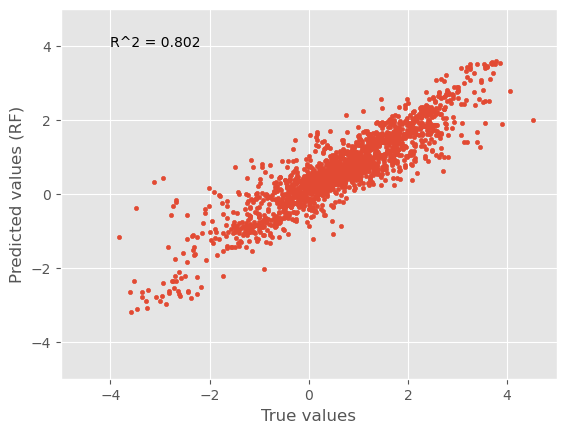

In [38]:
# Scatter plot

limits = -5,5
plt.figsize=(10,10)

plt.scatter(rf_5preds['y_test0'], rf_5preds['y_pred_rf_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (RF)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(rf_5preds['y_test0'], rf_5preds['y_pred_rf_ave'])), (-4, 4))
plt.show()

In [39]:
#cross valide using this optimized RF 
rf_baseline_CVscore = cross_val_score(rf_reg, X, Y, cv=10, scoring="r2")
#rf_opt_testSet_score = cross_val_score(optimized_rf, X, Y, cv=10, scoring="r2")
rf_opt_CVscore = cross_val_score(optimizedCV_rf, X, Y, cv=10, scoring="r2")
print("RF baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(rf_baseline_CVscore), np.std(rf_baseline_CVscore, ddof=1)))
#print("RF optimized model (tested on Y_te) r2_score %0.4f with a standard deviation of %0.4f" % (rf_opt_testSet_score.mean(), rf_opt_testSet_score.std()))
print("RF optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(rf_opt_CVscore), np.std(rf_opt_CVscore, ddof=1)))

RF baseline model r2_score 0.7061 with a standard deviation of 0.0433
RF optimized model r2_score 0.7087 with a standard deviation of 0.0441


In [40]:
joblib.dump(rf_reg, "OUTPUT/rf_reg_withSemiSel_withSemiSel_withSemiSel_withSemiSel_withSemiSel.joblib")
joblib.dump(optimizedCV_rf, "OUTPUT/optimizedCV_rf_withSemiSel.joblib")

['OUTPUT/optimizedCV_rf_withSemiSel.joblib']

## LGBMRegressor

In [41]:
%%time


r2_scores = np.empty(10)
TP=np.empty(10)
TN = np.empty(10)
FP= np.empty(10)
FN= np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W=np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)

for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]

        
        lgbm_reg = lgbm.LGBMRegressor(
        objective="regression",
        random_state=1121218,
        #n_estimators=150,
        boosting_type ="gbdt",  # default histogram binning of LGBM,
        n_jobs=8,
        #min_child_samples = 15,
        subsample=0.8, # also called bagging_fraction
        subsample_freq=10,
     
           )


        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_reg.fit(
                    X_train,
                    y_train,
                    eval_set=eval_set,
                    eval_metric="rmse",
                    #early_stopping_rounds=150,
                    verbose=False,
                    )

        y_pred = lgbm_reg.predict(X_test) 
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.3
        y_test_cat = np.where(((y_test>=2) | (y_test<=-2)), 1, 0) 
        y_pred_cat = np.where(((y_pred >= 2) | (y_pred <= -2)), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


mat_met_lgbm = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
print(mat_met_lgbm)

                 Metric  Value (average)  Value (std)
0                    R2         0.712088     0.034120
1                    TP        17.500000     2.505549
2                    TN       153.600000     2.756810
3                    FP         4.000000     2.943920
4                    FN        15.900000     2.766867
5              Accuracy         0.895812     0.019504
6             Precision         0.825744     0.113416
7           Sensitivity         0.524539     0.078058
8           Specificity         0.974650     0.018585
9              F1 score         0.636343     0.071224
10  F1 score (weighted)         0.886164     0.021668
11     F1 score (macro)         0.787744     0.040884
12    Balanced Accuracy         0.749595     0.039090
13                  MCC         0.602582     0.081131
14                  NPV         0.906400     0.014775
15              ROC_AUC         0.749595     0.039090
CPU times: user 11.7 s, sys: 96.1 ms, total: 11.8 s
Wall time: 1.53 s


In [42]:
import optuna  

def objective_lgbm_CV(trial, X, Y, Y_class):
    param_grid = {
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "max_bin": trial.suggest_int("max_bin", 150, 300),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"lambda_l1": trial.suggest_float("lambda_l1", 0, 0.001),
        #"lambda_l2": trial.suggest_float("lambda_l2", 1.0,100),
        "num_leaves": trial.suggest_int("num_leaves", 30, 750),
        #"min_child_samples": trial.suggest_int("min_child_samples", 15, 100),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"bagging_fraction": trial.suggest_float("bagging_fraction", 0.6,1),
        #"bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        }
  
    
    
    
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        lgbm_model = lgbm.LGBMRegressor(objective="regression", 
                                            random_state=1121218, 
                                            boosting_type ="gbdt", 
                                            **param_grid, n_jobs=8,
                                            subsample=0.8, # also called bagging_fraction
                                            subsample_freq=10,
                                         )
    
        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        y_pred = lgbm_model.predict(X_test)
        cv_scores[idx] = r2_score(y_test, y_pred)
       
        
    return np.mean(cv_scores)

In [43]:
#this is basically inner set parameters
def detailed_objective_lgbm_cv(trial, X, Y, Y_class):
    param_grid = {
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "max_bin": trial.suggest_int("max_bin", 150, 300),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"lambda_l1": trial.suggest_float("lambda_l1", 0, 0.001),
        #"lambda_l2": trial.suggest_float("lambda_l2", 1.0,100),
        "num_leaves": trial.suggest_int("num_leaves", 30, 750),
        #"min_child_samples": trial.suggest_int("min_child_samples", 15, 100),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"bagging_fraction": trial.suggest_float("bagging_fraction", 0.6,1),
        #"bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        
    }
    
    
    
    
    
    r2_scores = np.empty(10)
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M =np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        lgbm_model = lgbm.LGBMRegressor(objective="regression", 
                                            random_state=1121218, 
                                            boosting_type ="gbdt", 
                                            **param_grid, n_jobs=8,
                                            subsample=0.8, # also called bagging_fraction
                                            subsample_freq=10,
                                         )
    
        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        y_pred = lgbm_model.predict(X_test)
         # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.3
        y_test_cat = np.where(((y_test>=2) | (y_test<=-2)), 1, 0) 
        y_pred_cat = np.where(((y_pred >= 2) | (y_pred <= -2)), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    print(mat_met)

In [44]:
#Execute optuna and set hyperparameters
study_lgbm = optuna.create_study(direction='maximize', study_name="lgbmRegressor")
func_lgbm_0 = lambda trial: objective_lgbm_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_lgbm.optimize(func_lgbm_0, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 03:10:14,847] A new study created in memory with name: lgbmRegressor
[I 2023-12-12 03:10:16,345] Trial 0 finished with value: 0.7023856881391042 and parameters: {'n_estimators': 809, 'learning_rate': 0.12448359535377414, 'max_depth': 9, 'max_bin': 239, 'num_leaves': 713}. Best is trial 0 with value: 0.7023856881391042.
[I 2023-12-12 03:10:17,559] Trial 1 finished with value: 0.6694796335245015 and parameters: {'n_estimators': 347, 'learning_rate': 0.06981109798156886, 'max_depth': 4, 'max_bin': 266, 'num_leaves': 368}. Best is trial 0 with value: 0.7023856881391042.
[I 2023-12-12 03:10:18,901] Trial 2 finished with value: 0.7001204366389489 and parameters: {'n_estimators': 192, 'learning_rate': 0.09253424204480196, 'max_depth': 9, 'max_bin': 240, 'num_leaves': 178}. Best is trial 0 with value: 0.7023856881391042.
[I 2023-12-12 03:10:20,608] Trial 3 finished with value: 0.6965712607745214 and parameters: {'n_estimators': 881, 'learning_rate': 0.09859443882764618, 'max_dept

	Number of trials: 50.0
	Best value (r2_score): 0.7129
	Best params:
		n_estimators: 464
		learning_rate: 0.18701046015179237
		max_depth: 12
		max_bin: 233
		num_leaves: 322


In [45]:
optimized_lgbm_0 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )
                                         
    
eval_set = [(X_testSet0, Y_testSet0)]
optimized_lgbm_0.fit(X_trainSet0,
                Y_trainSet0,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )

#predict        
y_pred_lgbm_0 = optimized_lgbm_0.predict(X_testSet0)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet0, y_pred_lgbm_0)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet1 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_lgbm_0_cat = np.where(((y_pred_lgbm_0 >= 2) | (y_pred_lgbm_0 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_lgbm_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_lgbm_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_lgbm_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_lgbm_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_lgbm_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_lgbm_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_lgbm_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_lgbm_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_lgbm_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_lgbm_0_cat)


mat_met_lgbm_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
    
print(mat_met_lgbm_test)



                 Metric        Set0
0                    R2    0.655901
1                    TP   28.000000
2                    TN  305.000000
3                    FP   11.000000
4                    FN   38.000000
5              Accuracy    0.871728
6             Precision    0.717949
7           Sensitivity    0.424242
8           Specificity    0.965200
9              F1 score    0.533333
10  F1 score (weighted)    0.857863
11     F1 score (macro)    0.729489
12    Balanced Accuracy    0.694716
13                  MCC    0.486260
14                  NPV    0.889200
15              ROC_AUC    0.694716


In [46]:
#Execute optuna and set hyperparameters

func_lgbm_1 = lambda trial: objective_lgbm_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_lgbm.optimize(func_lgbm_1, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 03:11:36,417] Trial 50 finished with value: 0.6943464933854152 and parameters: {'n_estimators': 675, 'learning_rate': 0.1795357279415723, 'max_depth': 9, 'max_bin': 208, 'num_leaves': 359}. Best is trial 40 with value: 0.7129096258380114.
[I 2023-12-12 03:11:38,050] Trial 51 finished with value: 0.6946493560841416 and parameters: {'n_estimators': 500, 'learning_rate': 0.19286743260065833, 'max_depth': 11, 'max_bin': 231, 'num_leaves': 300}. Best is trial 40 with value: 0.7129096258380114.
[I 2023-12-12 03:11:40,043] Trial 52 finished with value: 0.7028728579500705 and parameters: {'n_estimators': 563, 'learning_rate': 0.17003821398206564, 'max_depth': 12, 'max_bin': 242, 'num_leaves': 254}. Best is trial 40 with value: 0.7129096258380114.
[I 2023-12-12 03:11:41,578] Trial 53 finished with value: 0.704481437358626 and parameters: {'n_estimators': 727, 'learning_rate': 0.19884426017367762, 'max_depth': 11, 'max_bin': 237, 'num_leaves': 333}. Best is trial 40 with value: 0.7

	Number of trials: 100.0
	Best value (r2_score): 0.7129
	Best params:
		n_estimators: 464
		learning_rate: 0.18701046015179237
		max_depth: 12
		max_bin: 233
		num_leaves: 322


In [47]:
optimized_lgbm_1 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )
    
eval_set = [(X_testSet1, Y_testSet1)]
optimized_lgbm_1.fit(X_trainSet1,
                Y_trainSet1,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )

#predict        
y_pred_lgbm_1 = optimized_lgbm_1.predict(X_testSet1)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet1, y_pred_lgbm_1)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet1 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_lgbm_1_cat = np.where(((y_pred_lgbm_1 >= 2) | (y_pred_lgbm_1 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_lgbm_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_lgbm_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_lgbm_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_lgbm_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_lgbm_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_lgbm_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_lgbm_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_lgbm_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_lgbm_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_lgbm_1_cat)


set1 = pd.DataFrame({ 'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set1'] =set1
print(mat_met_lgbm_test)


                 Metric        Set0        Set1
0                    R2    0.655901    0.686027
1                    TP   28.000000   34.000000
2                    TN  305.000000  309.000000
3                    FP   11.000000    6.000000
4                    FN   38.000000   33.000000
5              Accuracy    0.871728    0.897906
6             Precision    0.717949    0.850000
7           Sensitivity    0.424242    0.507463
8           Specificity    0.965200    0.981000
9              F1 score    0.533333    0.635514
10  F1 score (weighted)    0.857863    0.887123
11     F1 score (macro)    0.729489    0.788077
12    Balanced Accuracy    0.694716    0.744208
13                  MCC    0.486260    0.606651
14                  NPV    0.889200    0.903500
15              ROC_AUC    0.694716    0.744208


In [48]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_2 = lambda trial: objective_lgbm_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_lgbm.optimize(func_lgbm_2, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 03:13:00,673] Trial 100 finished with value: 0.6986764292950023 and parameters: {'n_estimators': 505, 'learning_rate': 0.15943825351813587, 'max_depth': 11, 'max_bin': 225, 'num_leaves': 725}. Best is trial 40 with value: 0.7129096258380114.
[I 2023-12-12 03:13:02,306] Trial 101 finished with value: 0.7000955063822546 and parameters: {'n_estimators': 585, 'learning_rate': 0.1812864553676082, 'max_depth': 11, 'max_bin': 236, 'num_leaves': 621}. Best is trial 40 with value: 0.7129096258380114.
[I 2023-12-12 03:13:03,842] Trial 102 finished with value: 0.6974862338299312 and parameters: {'n_estimators': 515, 'learning_rate': 0.18471713802725206, 'max_depth': 11, 'max_bin': 220, 'num_leaves': 544}. Best is trial 40 with value: 0.7129096258380114.
[I 2023-12-12 03:13:05,573] Trial 103 finished with value: 0.6937496727459702 and parameters: {'n_estimators': 486, 'learning_rate': 0.17249689796094356, 'max_depth': 12, 'max_bin': 239, 'num_leaves': 742}. Best is trial 40 with valu

	Number of trials: 150.0
	Best value (r2_score): 0.7129
	Best params:
		n_estimators: 464
		learning_rate: 0.18701046015179237
		max_depth: 12
		max_bin: 233
		num_leaves: 322


In [49]:
optimized_lgbm_2 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet2, Y_testSet2)]
optimized_lgbm_2.fit(X_trainSet2,
                Y_trainSet2,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_2 = optimized_lgbm_2.predict(X_testSet2)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet2, y_pred_lgbm_2)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet2 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_lgbm_2_cat = np.where(((y_pred_lgbm_2 >= 2) | (y_pred_lgbm_2 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_lgbm_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_lgbm_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_lgbm_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_lgbm_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_lgbm_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_lgbm_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_lgbm_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_lgbm_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_lgbm_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_lgbm_2_cat)


Set2 = pd.DataFrame({ 'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set2'] = Set2
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.655901    0.686027    0.679052
1                    TP   28.000000   34.000000   39.000000
2                    TN  305.000000  309.000000  308.000000
3                    FP   11.000000    6.000000    7.000000
4                    FN   38.000000   33.000000   28.000000
5              Accuracy    0.871728    0.897906    0.908377
6             Precision    0.717949    0.850000    0.847826
7           Sensitivity    0.424242    0.507463    0.582090
8           Specificity    0.965200    0.981000    0.977800
9              F1 score    0.533333    0.635514    0.690265
10  F1 score (weighted)    0.857863    0.887123    0.901341
11     F1 score (macro)    0.729489    0.788077    0.818251
12    Balanced Accuracy    0.694716    0.744208    0.779934
13                  MCC    0.486260    0.606651    0.654228
14                  NPV    0.889200    0.903500    0.916700
15              ROC_AUC    0.694716    0

In [50]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_3 = lambda trial: objective_lgbm_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_lgbm.optimize(func_lgbm_3, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 03:14:19,264] Trial 150 finished with value: 0.7036686735759602 and parameters: {'n_estimators': 510, 'learning_rate': 0.17608356335924502, 'max_depth': 12, 'max_bin': 221, 'num_leaves': 366}. Best is trial 40 with value: 0.7129096258380114.
[I 2023-12-12 03:14:21,148] Trial 151 finished with value: 0.7000107714318674 and parameters: {'n_estimators': 488, 'learning_rate': 0.1667591863632257, 'max_depth': 11, 'max_bin': 286, 'num_leaves': 638}. Best is trial 40 with value: 0.7129096258380114.
[I 2023-12-12 03:14:22,851] Trial 152 finished with value: 0.7070534261747718 and parameters: {'n_estimators': 560, 'learning_rate': 0.16977592436981595, 'max_depth': 11, 'max_bin': 295, 'num_leaves': 625}. Best is trial 40 with value: 0.7129096258380114.
[I 2023-12-12 03:14:24,571] Trial 153 finished with value: 0.7080116471015087 and parameters: {'n_estimators': 557, 'learning_rate': 0.16968977959473341, 'max_depth': 11, 'max_bin': 300, 'num_leaves': 622}. Best is trial 40 with valu

	Number of trials: 200.0
	Best value (r2_score): 0.7147
	Best params:
		n_estimators: 602
		learning_rate: 0.13609095642941718
		max_depth: 11
		max_bin: 273
		num_leaves: 376


In [51]:
optimized_lgbm_3 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet3, Y_testSet3)]
optimized_lgbm_3.fit(X_trainSet3,
                Y_trainSet3,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_3 = optimized_lgbm_3.predict(X_testSet3)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet3, y_pred_lgbm_3)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet3 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_lgbm_3_cat = np.where(((y_pred_lgbm_3 >= 2) | (y_pred_lgbm_3 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_lgbm_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_lgbm_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_lgbm_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_lgbm_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_lgbm_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_lgbm_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_lgbm_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_lgbm_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_lgbm_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_lgbm_3_cat)


Set3 = pd.DataFrame({ 'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set3'] = Set3
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.655901    0.686027    0.679052    0.679859
1                    TP   28.000000   34.000000   39.000000   31.000000
2                    TN  305.000000  309.000000  308.000000  307.000000
3                    FP   11.000000    6.000000    7.000000    7.000000
4                    FN   38.000000   33.000000   28.000000   37.000000
5              Accuracy    0.871728    0.897906    0.908377    0.884817
6             Precision    0.717949    0.850000    0.847826    0.815789
7           Sensitivity    0.424242    0.507463    0.582090    0.455882
8           Specificity    0.965200    0.981000    0.977800    0.977700
9              F1 score    0.533333    0.635514    0.690265    0.584906
10  F1 score (weighted)    0.857863    0.887123    0.901341    0.871143
11     F1 score (macro)    0.729489    0.788077    0.818251    0.759018
12    Balanced Accuracy    0.694716    0.744208    0.779934    0

In [52]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_4 = lambda trial: objective_lgbm_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_lgbm.optimize(func_lgbm_4, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 03:15:43,798] Trial 200 finished with value: 0.6943293920542286 and parameters: {'n_estimators': 646, 'learning_rate': 0.1404000169278535, 'max_depth': 11, 'max_bin': 263, 'num_leaves': 389}. Best is trial 191 with value: 0.7147343094409851.
[I 2023-12-12 03:15:45,650] Trial 201 finished with value: 0.6849901033784209 and parameters: {'n_estimators': 601, 'learning_rate': 0.12479144858156765, 'max_depth': 11, 'max_bin': 276, 'num_leaves': 361}. Best is trial 191 with value: 0.7147343094409851.
[I 2023-12-12 03:15:47,313] Trial 202 finished with value: 0.6877216267071715 and parameters: {'n_estimators': 626, 'learning_rate': 0.1342788236412381, 'max_depth': 11, 'max_bin': 272, 'num_leaves': 388}. Best is trial 191 with value: 0.7147343094409851.
[I 2023-12-12 03:15:49,266] Trial 203 finished with value: 0.6887916483544332 and parameters: {'n_estimators': 592, 'learning_rate': 0.12741573501499165, 'max_depth': 11, 'max_bin': 283, 'num_leaves': 372}. Best is trial 191 with v

	Number of trials: 250.0
	Best value (r2_score): 0.7147
	Best params:
		n_estimators: 602
		learning_rate: 0.13609095642941718
		max_depth: 11
		max_bin: 273
		num_leaves: 376


In [53]:
optimized_lgbm_4 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet4, Y_testSet4)]
optimized_lgbm_4.fit(X_trainSet4,
                Y_trainSet4,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_4 = optimized_lgbm_4.predict(X_testSet4)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet4, y_pred_lgbm_4)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet4 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_lgbm_4_cat = np.where(((y_pred_lgbm_4 >= 2) | (y_pred_lgbm_4 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_lgbm_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_lgbm_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_lgbm_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_lgbm_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_lgbm_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_lgbm_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_lgbm_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_lgbm_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_lgbm_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_lgbm_4_cat)


Set4 = pd.DataFrame({ 'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set4'] = Set4
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.655901    0.686027    0.679052    0.679859   
1                    TP   28.000000   34.000000   39.000000   31.000000   
2                    TN  305.000000  309.000000  308.000000  307.000000   
3                    FP   11.000000    6.000000    7.000000    7.000000   
4                    FN   38.000000   33.000000   28.000000   37.000000   
5              Accuracy    0.871728    0.897906    0.908377    0.884817   
6             Precision    0.717949    0.850000    0.847826    0.815789   
7           Sensitivity    0.424242    0.507463    0.582090    0.455882   
8           Specificity    0.965200    0.981000    0.977800    0.977700   
9              F1 score    0.533333    0.635514    0.690265    0.584906   
10  F1 score (weighted)    0.857863    0.887123    0.901341    0.871143   
11     F1 score (macro)    0.729489    0.788077    0.818251    0.759018   
12    Balanced Accuracy  

In [54]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_5 = lambda trial: objective_lgbm_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_lgbm.optimize(func_lgbm_5, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 03:17:15,585] Trial 250 finished with value: 0.681554014695315 and parameters: {'n_estimators': 566, 'learning_rate': 0.11867877220030928, 'max_depth': 11, 'max_bin': 281, 'num_leaves': 298}. Best is trial 191 with value: 0.7147343094409851.
[I 2023-12-12 03:17:17,232] Trial 251 finished with value: 0.6746563334132148 and parameters: {'n_estimators': 612, 'learning_rate': 0.14832199760279324, 'max_depth': 11, 'max_bin': 274, 'num_leaves': 332}. Best is trial 191 with value: 0.7147343094409851.
[I 2023-12-12 03:17:19,171] Trial 252 finished with value: 0.6784855864395809 and parameters: {'n_estimators': 641, 'learning_rate': 0.13636846815090978, 'max_depth': 11, 'max_bin': 276, 'num_leaves': 401}. Best is trial 191 with value: 0.7147343094409851.
[I 2023-12-12 03:17:20,749] Trial 253 finished with value: 0.6770703653575343 and parameters: {'n_estimators': 310, 'learning_rate': 0.13076327354059483, 'max_depth': 11, 'max_bin': 268, 'num_leaves': 375}. Best is trial 191 with 

	Number of trials: 300.0
	Best value (r2_score): 0.7147
	Best params:
		n_estimators: 602
		learning_rate: 0.13609095642941718
		max_depth: 11
		max_bin: 273
		num_leaves: 376


In [55]:
optimized_lgbm_5 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet5, Y_testSet5)]
optimized_lgbm_5.fit(X_trainSet5,
                Y_trainSet5,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_5 = optimized_lgbm_5.predict(X_testSet5)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet5, y_pred_lgbm_5)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet5 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_lgbm_5_cat = np.where(((y_pred_lgbm_5 >= 2) | (y_pred_lgbm_5 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_lgbm_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_lgbm_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_lgbm_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_lgbm_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_lgbm_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_lgbm_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_lgbm_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_lgbm_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_lgbm_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_lgbm_5_cat)


Set5 = pd.DataFrame({ 'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set5'] = Set5
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.655901    0.686027    0.679052    0.679859   
1                    TP   28.000000   34.000000   39.000000   31.000000   
2                    TN  305.000000  309.000000  308.000000  307.000000   
3                    FP   11.000000    6.000000    7.000000    7.000000   
4                    FN   38.000000   33.000000   28.000000   37.000000   
5              Accuracy    0.871728    0.897906    0.908377    0.884817   
6             Precision    0.717949    0.850000    0.847826    0.815789   
7           Sensitivity    0.424242    0.507463    0.582090    0.455882   
8           Specificity    0.965200    0.981000    0.977800    0.977700   
9              F1 score    0.533333    0.635514    0.690265    0.584906   
10  F1 score (weighted)    0.857863    0.887123    0.901341    0.871143   
11     F1 score (macro)    0.729489    0.788077    0.818251    0.759018   
12    Balanced Accuracy  

In [56]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_6 = lambda trial: objective_lgbm_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_lgbm.optimize(func_lgbm_6, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.6f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 03:18:43,754] Trial 300 finished with value: 0.7153329958600628 and parameters: {'n_estimators': 666, 'learning_rate': 0.1415546036841192, 'max_depth': 11, 'max_bin': 276, 'num_leaves': 289}. Best is trial 300 with value: 0.7153329958600628.
[I 2023-12-12 03:18:45,935] Trial 301 finished with value: 0.7181206849520032 and parameters: {'n_estimators': 669, 'learning_rate': 0.1424966575717498, 'max_depth': 10, 'max_bin': 274, 'num_leaves': 270}. Best is trial 301 with value: 0.7181206849520032.
[I 2023-12-12 03:18:47,803] Trial 302 finished with value: 0.7109508072567801 and parameters: {'n_estimators': 670, 'learning_rate': 0.14147286656183458, 'max_depth': 10, 'max_bin': 275, 'num_leaves': 263}. Best is trial 301 with value: 0.7181206849520032.
[I 2023-12-12 03:18:49,424] Trial 303 finished with value: 0.7120314358014048 and parameters: {'n_estimators': 713, 'learning_rate': 0.14330466316652288, 'max_depth': 10, 'max_bin': 275, 'num_leaves': 256}. Best is trial 301 with v

	Number of trials: 350.0
	Best value (r2_score): 0.724047
	Best params:
		n_estimators: 807
		learning_rate: 0.1545739174645877
		max_depth: 9
		max_bin: 258
		num_leaves: 176


In [57]:
optimized_lgbm_6 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet6, Y_testSet6)]
optimized_lgbm_6.fit(X_trainSet6,
                Y_trainSet6,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_6 = optimized_lgbm_6.predict(X_testSet6)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet6, y_pred_lgbm_6)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet6 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_lgbm_6_cat = np.where(((y_pred_lgbm_6 >= 2) | (y_pred_lgbm_6 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_lgbm_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_lgbm_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_lgbm_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_lgbm_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_lgbm_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_lgbm_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_lgbm_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_lgbm_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_lgbm_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_lgbm_6_cat)


Set6 = pd.DataFrame({ 'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set6'] = Set6
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.655901    0.686027    0.679052    0.679859   
1                    TP   28.000000   34.000000   39.000000   31.000000   
2                    TN  305.000000  309.000000  308.000000  307.000000   
3                    FP   11.000000    6.000000    7.000000    7.000000   
4                    FN   38.000000   33.000000   28.000000   37.000000   
5              Accuracy    0.871728    0.897906    0.908377    0.884817   
6             Precision    0.717949    0.850000    0.847826    0.815789   
7           Sensitivity    0.424242    0.507463    0.582090    0.455882   
8           Specificity    0.965200    0.981000    0.977800    0.977700   
9              F1 score    0.533333    0.635514    0.690265    0.584906   
10  F1 score (weighted)    0.857863    0.887123    0.901341    0.871143   
11     F1 score (macro)    0.729489    0.788077    0.818251    0.759018   
12    Balanced Accuracy  

In [58]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_7 = lambda trial: objective_lgbm_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_lgbm.optimize(func_lgbm_7, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.7f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 03:20:09,600] Trial 350 finished with value: 0.7143524829357083 and parameters: {'n_estimators': 807, 'learning_rate': 0.16113618123847753, 'max_depth': 9, 'max_bin': 260, 'num_leaves': 179}. Best is trial 344 with value: 0.7240465774291549.
[I 2023-12-12 03:20:11,099] Trial 351 finished with value: 0.7104224772563896 and parameters: {'n_estimators': 878, 'learning_rate': 0.15442808360986238, 'max_depth': 9, 'max_bin': 264, 'num_leaves': 182}. Best is trial 344 with value: 0.7240465774291549.
[I 2023-12-12 03:20:12,517] Trial 352 finished with value: 0.7148400280703496 and parameters: {'n_estimators': 841, 'learning_rate': 0.15796355454200142, 'max_depth': 9, 'max_bin': 252, 'num_leaves': 153}. Best is trial 344 with value: 0.7240465774291549.
[I 2023-12-12 03:20:14,099] Trial 353 finished with value: 0.7105380473839379 and parameters: {'n_estimators': 798, 'learning_rate': 0.15269271464235498, 'max_depth': 9, 'max_bin': 259, 'num_leaves': 201}. Best is trial 344 with val

	Number of trials: 400.0
	Best value (r2_score): 0.7240466
	Best params:
		n_estimators: 807
		learning_rate: 0.1545739174645877
		max_depth: 9
		max_bin: 258
		num_leaves: 176


In [59]:
optimized_lgbm_7 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet7, Y_testSet7)]
optimized_lgbm_7.fit(X_trainSet7,
                Y_trainSet7,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_7 = optimized_lgbm_7.predict(X_testSet7)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet7, y_pred_lgbm_7)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet7 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_lgbm_7_cat = np.where(((y_pred_lgbm_7 >= 2) | (y_pred_lgbm_7 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_lgbm_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_lgbm_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_lgbm_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_lgbm_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_lgbm_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_lgbm_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_lgbm_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_lgbm_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_lgbm_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_lgbm_7_cat)


Set7 = pd.DataFrame({ 'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set7'] = Set7
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.655901    0.686027    0.679052    0.679859   
1                    TP   28.000000   34.000000   39.000000   31.000000   
2                    TN  305.000000  309.000000  308.000000  307.000000   
3                    FP   11.000000    6.000000    7.000000    7.000000   
4                    FN   38.000000   33.000000   28.000000   37.000000   
5              Accuracy    0.871728    0.897906    0.908377    0.884817   
6             Precision    0.717949    0.850000    0.847826    0.815789   
7           Sensitivity    0.424242    0.507463    0.582090    0.455882   
8           Specificity    0.965200    0.981000    0.977800    0.977700   
9              F1 score    0.533333    0.635514    0.690265    0.584906   
10  F1 score (weighted)    0.857863    0.887123    0.901341    0.871143   
11     F1 score (macro)    0.729489    0.788077    0.818251    0.759018   
12    Balanced Accuracy  

In [60]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_8 = lambda trial: objective_lgbm_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_lgbm.optimize(func_lgbm_8, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.8f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 03:21:30,862] Trial 400 finished with value: 0.7005412140414459 and parameters: {'n_estimators': 798, 'learning_rate': 0.157335854513238, 'max_depth': 9, 'max_bin': 257, 'num_leaves': 159}. Best is trial 344 with value: 0.7240465774291549.
[I 2023-12-12 03:21:32,212] Trial 401 finished with value: 0.698126816574238 and parameters: {'n_estimators': 811, 'learning_rate': 0.16096959089078264, 'max_depth': 7, 'max_bin': 254, 'num_leaves': 198}. Best is trial 344 with value: 0.7240465774291549.
[I 2023-12-12 03:21:33,873] Trial 402 finished with value: 0.7030422066727138 and parameters: {'n_estimators': 788, 'learning_rate': 0.15149208043126047, 'max_depth': 10, 'max_bin': 265, 'num_leaves': 177}. Best is trial 344 with value: 0.7240465774291549.
[I 2023-12-12 03:21:35,506] Trial 403 finished with value: 0.7043171844761579 and parameters: {'n_estimators': 897, 'learning_rate': 0.1469042826817612, 'max_depth': 9, 'max_bin': 261, 'num_leaves': 141}. Best is trial 344 with value:

	Number of trials: 450.0
	Best value (r2_score): 0.72404658
	Best params:
		n_estimators: 807
		learning_rate: 0.1545739174645877
		max_depth: 9
		max_bin: 258
		num_leaves: 176


In [61]:
optimized_lgbm_8 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet8, Y_testSet8)]
optimized_lgbm_8.fit(X_trainSet8,
                Y_trainSet8,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_8 = optimized_lgbm_8.predict(X_testSet8)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet8, y_pred_lgbm_8)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet8 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_lgbm_8_cat = np.where(((y_pred_lgbm_8 >= 2) | (y_pred_lgbm_8 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_lgbm_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_lgbm_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_lgbm_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_lgbm_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_lgbm_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_lgbm_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_lgbm_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_lgbm_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_lgbm_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_lgbm_8_cat)


Set8 = pd.DataFrame({ 'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set8'] = Set8
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.655901    0.686027    0.679052    0.679859   
1                    TP   28.000000   34.000000   39.000000   31.000000   
2                    TN  305.000000  309.000000  308.000000  307.000000   
3                    FP   11.000000    6.000000    7.000000    7.000000   
4                    FN   38.000000   33.000000   28.000000   37.000000   
5              Accuracy    0.871728    0.897906    0.908377    0.884817   
6             Precision    0.717949    0.850000    0.847826    0.815789   
7           Sensitivity    0.424242    0.507463    0.582090    0.455882   
8           Specificity    0.965200    0.981000    0.977800    0.977700   
9              F1 score    0.533333    0.635514    0.690265    0.584906   
10  F1 score (weighted)    0.857863    0.887123    0.901341    0.871143   
11     F1 score (macro)    0.729489    0.788077    0.818251    0.759018   
12    Balanced Accuracy  

In [62]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_9 = lambda trial: objective_lgbm_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_lgbm.optimize(func_lgbm_9, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.9f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 03:22:57,831] Trial 450 finished with value: 0.695148786774822 and parameters: {'n_estimators': 785, 'learning_rate': 0.16774713941702515, 'max_depth': 10, 'max_bin': 257, 'num_leaves': 184}. Best is trial 344 with value: 0.7240465774291549.
[I 2023-12-12 03:22:59,725] Trial 451 finished with value: 0.7007616782264723 and parameters: {'n_estimators': 805, 'learning_rate': 0.14484604939671258, 'max_depth': 10, 'max_bin': 272, 'num_leaves': 212}. Best is trial 344 with value: 0.7240465774291549.
[I 2023-12-12 03:23:00,924] Trial 452 finished with value: 0.6918675864371658 and parameters: {'n_estimators': 840, 'learning_rate': 0.1608602240809884, 'max_depth': 9, 'max_bin': 262, 'num_leaves': 135}. Best is trial 344 with value: 0.7240465774291549.
[I 2023-12-12 03:23:02,768] Trial 453 finished with value: 0.6998843468838608 and parameters: {'n_estimators': 764, 'learning_rate': 0.09290867743191256, 'max_depth': 8, 'max_bin': 265, 'num_leaves': 173}. Best is trial 344 with val

	Number of trials: 500.0
	Best value (r2_score): 0.724046577
	Best params:
		n_estimators: 807
		learning_rate: 0.1545739174645877
		max_depth: 9
		max_bin: 258
		num_leaves: 176


In [63]:
optimized_lgbm_9 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet9, Y_testSet9)]
optimized_lgbm_9.fit(X_trainSet9,
                Y_trainSet9,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_9 = optimized_lgbm_9.predict(X_testSet9)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet9, y_pred_lgbm_9)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet9 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_lgbm_9_cat = np.where(((y_pred_lgbm_9 >= 2) | (y_pred_lgbm_9 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_lgbm_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_lgbm_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_lgbm_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_lgbm_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_lgbm_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_lgbm_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_lgbm_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_lgbm_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_lgbm_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_lgbm_9_cat)


Set9 = pd.DataFrame({ 'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set9'] = Set9
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.655901    0.686027    0.679052    0.679859   
1                    TP   28.000000   34.000000   39.000000   31.000000   
2                    TN  305.000000  309.000000  308.000000  307.000000   
3                    FP   11.000000    6.000000    7.000000    7.000000   
4                    FN   38.000000   33.000000   28.000000   37.000000   
5              Accuracy    0.871728    0.897906    0.908377    0.884817   
6             Precision    0.717949    0.850000    0.847826    0.815789   
7           Sensitivity    0.424242    0.507463    0.582090    0.455882   
8           Specificity    0.965200    0.981000    0.977800    0.977700   
9              F1 score    0.533333    0.635514    0.690265    0.584906   
10  F1 score (weighted)    0.857863    0.887123    0.901341    0.871143   
11     F1 score (macro)    0.729489    0.788077    0.818251    0.759018   
12    Balanced Accuracy  

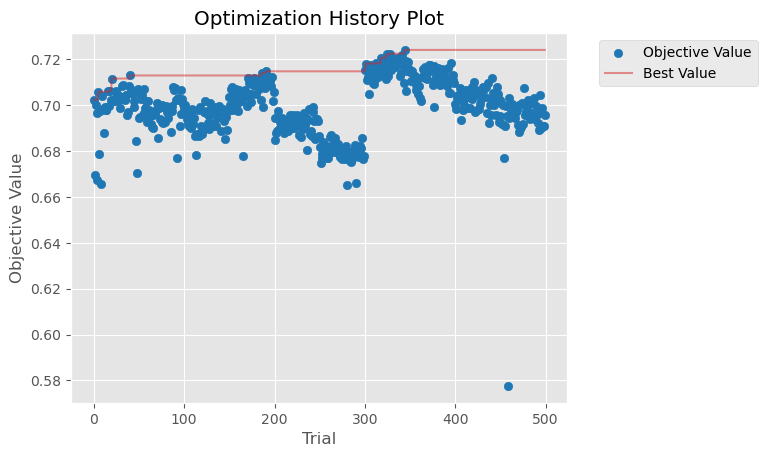

In [64]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_lgbm);

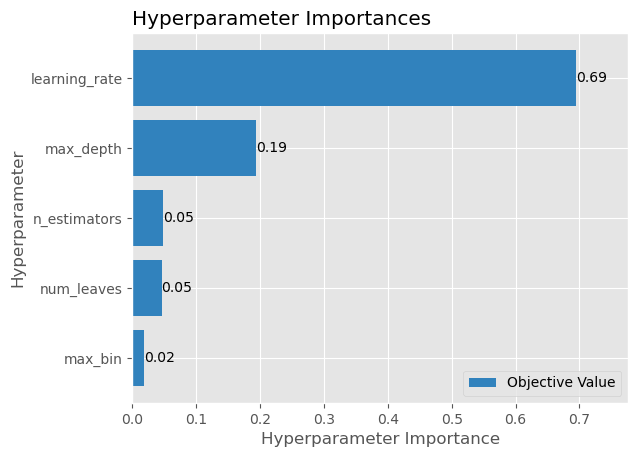

In [65]:
from optuna.visualization.matplotlib import plot_param_importances
plot_param_importances(study_lgbm);

In [66]:
detailed_objective_lgbm_cv(study_lgbm.best_trial, X, Y, Y_class)

                 Metric  Value (average)  Value (std)
0                    R2         0.724363     0.030369
1                    TP        17.300000     1.946507
2                    TN       153.500000     2.549510
3                    FP         4.100000     2.846050
4                    FN        16.100000     2.078995
5              Accuracy         0.894241     0.016703
6             Precision         0.819274     0.107998
7           Sensitivity         0.518206     0.059044
8           Specificity         0.974020     0.017964
9              F1 score         0.631035     0.056776
10  F1 score (weighted)         0.884543     0.017641
11     F1 score (macro)         0.784635     0.032939
12    Balanced Accuracy         0.746116     0.029842
13                  MCC         0.595762     0.070014
14                  NPV         0.905180     0.011097
15              ROC_AUC         0.746116     0.029842


In [67]:
mat_met_lgbm_test['ave'] = mat_met_lgbm_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_lgbm_test['std'] = mat_met_lgbm_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_lgbm_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.655901,0.686027,0.679052,0.679859,0.729972,0.737187,0.704752,0.673579,0.668503,0.693500,0.690833,0.026205
1,TP,28.000000,34.000000,39.000000,31.000000,34.000000,36.000000,33.000000,28.000000,38.000000,34.000000,33.500000,3.719319
2,TN,305.000000,309.000000,308.000000,307.000000,312.000000,312.000000,307.000000,309.000000,306.000000,308.000000,308.300000,2.311805
3,FP,11.000000,6.000000,7.000000,7.000000,4.000000,4.000000,7.000000,6.000000,7.000000,7.000000,6.600000,1.955050
4,FN,38.000000,33.000000,28.000000,37.000000,32.000000,30.000000,35.000000,39.000000,31.000000,33.000000,33.600000,3.596294
5,Accuracy,0.871728,0.897906,0.908377,0.884817,0.905759,0.910995,0.890052,0.882199,0.900524,0.895288,0.894764,0.012573
6,Precision,0.717949,0.850000,0.847826,0.815789,0.894737,0.900000,0.825000,0.823529,0.844444,0.829268,0.834854,0.050118
7,Sensitivity,0.424242,0.507463,0.582090,0.455882,0.515152,0.545455,0.485294,0.417910,0.550725,0.507463,0.499167,0.054111
8,Specificity,0.965200,0.981000,0.977800,0.977700,0.987300,0.987300,0.977700,0.981000,0.977600,0.977800,0.979040,0.006186
9,F1 score,0.533333,0.635514,0.690265,0.584906,0.653846,0.679245,0.611111,0.554455,0.666667,0.629630,0.623897,0.052778


In [68]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)

r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_lgbm=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_lgbm = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


        #learn
        eval_set = [(X_test, y_test)]
        optimizedCV_lgbm.fit(X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
                          
                  
        #print(test_idx)
        y_pred_optimized_lgbm = optimizedCV_lgbm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_lgbm': y_pred_optimized_lgbm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2) | (y_test<=-2)), 1, 0) 
        y_pred_optimized_lgbm_cat = np.where(((y_pred_optimized_lgbm >= 2) | (y_pred_optimized_lgbm <= -2)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_lgbm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_lgbm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_lgbm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_lgbm_cat))
        
    data_lgbm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_lgbm['y_test' + str(i)] = data_inner['y_test']
    data_lgbm['y_pred_lgbm' + str(i)] = data_inner['y_pred_lgbm']
   # data_lgbm['correct' + str(i)] = correct_value
   # data_lgbm['pred' + str(i)] = y_pred_optimized_lgbm

mat_met_optimized_lgbm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


lgbm_run0 = data_lgbm[['y_test_idx0', 'y_test0', 'y_pred_lgbm0']]
lgbm_run0.sort_values(by='y_test_idx0', inplace=True)
lgbm_run0.reset_index(inplace=True, drop=True)
lgbm_run1 = data_lgbm[['y_test_idx1', 'y_test1', 'y_pred_lgbm1']]
lgbm_run1.sort_values(by='y_test_idx1', inplace=True)
lgbm_run1.reset_index(inplace=True, drop=True)
lgbm_run2 = data_lgbm[['y_test_idx2', 'y_test2', 'y_pred_lgbm2']]
lgbm_run2.sort_values(by='y_test_idx2', inplace=True)
lgbm_run2.reset_index(inplace=True, drop=True)
lgbm_run3 = data_lgbm[['y_test_idx3', 'y_test3', 'y_pred_lgbm3']]
lgbm_run3.sort_values(by='y_test_idx3', inplace=True)
lgbm_run3.reset_index(inplace=True, drop=True)
lgbm_run4 = data_lgbm[['y_test_idx4', 'y_test4', 'y_pred_lgbm4']]
lgbm_run4.sort_values(by='y_test_idx4', inplace=True)
lgbm_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
lgbm_5preds = pd.concat([chembl_id, lgbm_run0, lgbm_run1, lgbm_run2, lgbm_run3, lgbm_run4], axis=1)
lgbm_5preds = lgbm_5preds[['molecule_chembl_id','y_test_idx0', 'y_test0', 'y_pred_lgbm0', 'y_pred_lgbm1', 'y_pred_lgbm2', 'y_pred_lgbm3', 'y_pred_lgbm4']]
lgbm_5preds['y_pred_lgbm_ave'] = lgbm_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
lgbm_5preds['y_pred_lgbm_std'] = lgbm_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)

mat_met_optimized_lgbm

,Metric,Value (average),Value (std)
0,R2,0.716985,0.042865
1,Accuracy,0.896859,0.018389
2,Precision,0.822454,0.074273
3,Sensitivity,0.524852,0.091167
4,Specificity,0.975626,0.011284
5,F1 score,0.636594,0.079669
6,F1 score (weighted),0.886860,0.022057
7,F1 score (macro),0.788218,0.044724
8,Balanced Accuracy,0.750242,0.045981
9,MCC,0.602478,0.080886


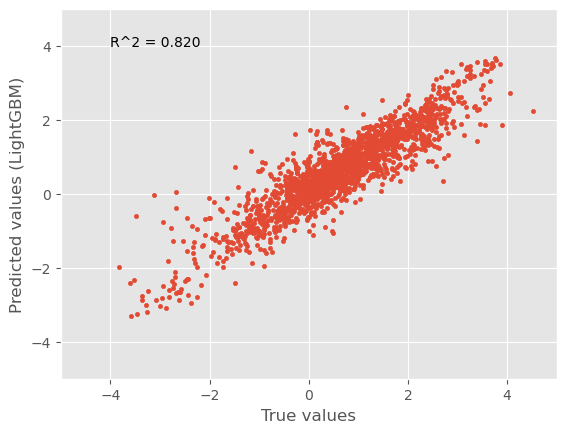

In [69]:
# Scatter plot

limits = -5,5
plt.figsize=(10,10)

plt.scatter(lgbm_5preds['y_test0'], lgbm_5preds['y_pred_lgbm_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (LightGBM)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(lgbm_5preds['y_test0'], lgbm_5preds['y_pred_lgbm_ave'])), (-4, 4))
plt.show()

In [70]:
#cross valide using this optimized LightGBM 
fit_params={'early_stopping_rounds': 50, 
        'eval_set': [(X_tr, Y_tr), (X_te, Y_te)],
            'verbose':False,
           }
#cross valide using this optimized LightGBM 
lgbm_baseline_CVscore = cross_val_score(lgbm_reg, X, Y, cv=10, scoring="r2")
#r2_cv_lgbm_opt_testSet = cross_val_score(optimized_lgbm, X, Y, cv=10, scoring="r2")
r2_cv_lgbm_opt = cross_val_score(optimizedCV_lgbm, X, Y, cv=10, scoring="r2", fit_params=fit_params)
print("LightGBM baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(lgbm_baseline_CVscore), np.std(lgbm_baseline_CVscore, ddof=1)))
#print("LightGBM optimized model (tested on Y_te)r2_score %0.4f with a standard deviation of %0.4f" % (r2_cv_lgbm_opt_testSet.mean(), r2_cv_lgbm_opt_testSet.std()))
print("LightGBM optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(r2_cv_lgbm_opt), np.std(r2_cv_lgbm_opt, ddof=1)))

LightGBM baseline model r2_score 0.7091 with a standard deviation of 0.0428
LightGBM optimized model r2_score 0.7005 with a standard deviation of 0.0588


In [71]:
joblib.dump(lgbm_reg, "OUTPUT/lgbm_reg_withSemiSel.joblib")
joblib.dump(optimizedCV_lgbm, "OUTPUT/optimizedCV_lgbm_withSemiSel.joblib") 

['OUTPUT/optimizedCV_lgbm_withSemiSel.joblib']

## XGBoost

In [72]:
%%time

r2_scores = np.empty(10)
TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    xgb_reg = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=1121218,
    #n_estimators=10000,  
    tree_method="hist",  # enable histogram binning in XGB
    subsample=0.8, 
    )
    
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb_reg.fit(X_train,
                y_train,
    
    eval_set=eval_set,
    eval_metric="rmse",
    early_stopping_rounds=50,
    verbose=False,  # Disable logs
               )

    y_pred = xgb_reg.predict(X_test) 
    # r2 score of the regression model before evaluating categorical evaluation parameters
    r2_scores[idx] = r2_score(y_test, y_pred)
    # now convert the resuls to binary with cutoff 6.3
    y_test_cat = np.where(((y_test>=2) | (y_test<=-2)), 1, 0) 
    y_pred_cat = np.where(((y_pred >= 2) | (y_pred <= -2)), 1, 0)
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
    Precision[idx] = precision_score(y_test_cat, y_pred_cat)
    Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
    f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
    f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
    MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores),np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    R2         0.708434     0.042340
1                    TP        17.200000     3.359894
2                    TN       153.200000     2.573368
3                    FP         4.400000     2.796824
4                    FN        16.200000     3.852849
5              Accuracy         0.892147     0.021965
6             Precision         0.807326     0.116356
7           Sensitivity         0.516404     0.107853
8           Specificity         0.972130     0.017653
9              F1 score         0.622099     0.088261
10  F1 score (weighted)         0.881826     0.026076
11     F1 score (macro)         0.779566     0.050058
12    Balanced Accuracy         0.744259     0.052788
13                  MCC         0.586842     0.094223
14                  NPV         0.904790     0.020676
15              ROC_AUC         0.744259     0.052788
CPU times: user 47.3 s, sys: 104 ms, total: 47.4 s
Wall time: 1.62 s


In [73]:
def objective_xgb_CV(trial, X, Y, Y_class):
    param_grid = {
        
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "eta": trial.suggest_float("eta", 1e-6, 0.1),  
        "max_depth": trial.suggest_int("max_depth", 5, 12),  
        "alpha": trial.suggest_float("alpha", 0, 1, step=1e-04),
        "lambda": trial.suggest_float("lambda", 1,40),
        #"alpha": trial.suggest_float("alpha", 0, 1.0),
        #"lambda": trial.suggest_float("lambda", 1e-8, 40.0),
        "max_bin": trial.suggest_int("max_bin", 250, 500),
    }
    
    
    cv_scores=np.empty(10)
    #y_comb=pd.DataFrame()
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=1121218, booster ="gbtree", tree_method='hist',
                                  **param_grid,  n_jobs=8, subsample=0.8, )
    
        eval_set = [(X_test, y_test)]
        xgb_model.fit(
            X_train,
            y_train,
            eval_set=eval_set,
            eval_metric="rmse",    
            early_stopping_rounds=50,
            verbose=False)
    
        y_pred = xgb_model.predict(X_test)
        cv_scores[idx] = r2_score(y_test, y_pred)
            
    return np.mean(cv_scores)

In [74]:
def detailed_objective_xgb_CV(trial, X, Y, Y_class):
    param_grid = {
        
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "eta": trial.suggest_float("eta", 1e-6, 0.1),  
        "max_depth": trial.suggest_int("max_depth", 5, 12),  
        "alpha": trial.suggest_float("alpha", 0, 1, step=1e-04),
        "lambda": trial.suggest_float("lambda", 1,40),
        #"alpha": trial.suggest_float("alpha", 0, 1.0),
        #"lambda": trial.suggest_float("lambda", 1e-8, 40.0),
        "max_bin": trial.suggest_int("max_bin", 250, 500),
    }
    
    
    r2_scores = np.empty(10)
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W=np.empty(10)
    f1_scores_M=np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=1121218, booster ="gbtree", tree_method='hist',
                                  **param_grid,  n_jobs=8, subsample=0.8, )
    
        eval_set = [(X_test, y_test)]
        xgb_model.fit(
            X_train,
            y_train,
            eval_set=eval_set,
            eval_metric="rmse",    
            early_stopping_rounds=50,
            verbose=False)
        
        y_pred = xgb_model.predict(X_test)
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # convert to categorical values
        y_test_cat = np.where( ((y_test>=2) | (y_test<= -2.0)), 1, 0) 
        y_pred_cat = np.where(((y_pred>=2) | (y_pred<= -2.0)), 1, 0)
       
           
        #calculate parameters
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)      
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)

    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
    return (mat_met)   

In [75]:
#Execute optuna and set hyperparameters
study_xgb = optuna.create_study(direction='maximize', study_name="XGBRegressor")
func_xgb_0 = lambda trial: objective_xgb_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_xgb.optimize(func_xgb_0, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 03:24:51,407] A new study created in memory with name: XGBRegressor
[I 2023-12-12 03:24:55,160] Trial 0 finished with value: 0.7180022624250824 and parameters: {'n_estimators': 299, 'eta': 0.09860085191271734, 'max_depth': 6, 'alpha': 0.4611, 'lambda': 17.8283293919773, 'max_bin': 356}. Best is trial 0 with value: 0.7180022624250824.
[I 2023-12-12 03:25:00,589] Trial 1 finished with value: 0.7119904749105851 and parameters: {'n_estimators': 357, 'eta': 0.04925858854823546, 'max_depth': 7, 'alpha': 0.5727, 'lambda': 38.72307887335977, 'max_bin': 394}. Best is trial 0 with value: 0.7180022624250824.
[I 2023-12-12 03:25:15,743] Trial 2 finished with value: 0.7200563921766218 and parameters: {'n_estimators': 833, 'eta': 0.012463404946996723, 'max_depth': 9, 'alpha': 0.6918000000000001, 'lambda': 6.75910244369564, 'max_bin': 314}. Best is trial 2 with value: 0.7200563921766218.
[I 2023-12-12 03:25:20,726] Trial 3 finished with value: 0.7087120586115938 and parameters: {'n_esti

	Number of trials: 50.0
	Best value (r2_score): 0.7286
	Best params:
		n_estimators: 746
		eta: 0.06819594114158128
		max_depth: 8
		alpha: 0.7329
		lambda: 15.684999579174267
		max_bin: 290


In [76]:
#Create an instance with tuned hyperparameters

optimized_xgb_0 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    #learn
eval_set = [(X_testSet0, Y_testSet0)]

optimized_xgb_0.fit(X_trainSet0,Y_trainSet0, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

    # r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_xgb_0 = optimized_xgb_0.predict(X_testSet0)
r2_scores = r2_score(Y_testSet0, y_pred_xgb_0)
# now convert the resuls to binary with cutoff 6.3
Y_testSet0_cat = np.where(((Y_testSet0>=2) | (Y_testSet0<=-2)), 1, 0) 
y_pred_xgb_0_cat = np.where(((y_pred_xgb_0 >= 2) | (y_pred_xgb_0 <= -2)), 1, 0)
    #calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_xgb_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_xgb_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_xgb_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_xgb_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_xgb_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_xgb_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_xgb_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_xgb_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_xgb_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_xgb_0_cat)
    

mat_met_xgb_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_xgb_test)


                 Metric        Set0
0                    R2    0.693937
1                    TP   31.000000
2                    TN  310.000000
3                    FP    6.000000
4                    FN   35.000000
5              Accuracy    0.892670
6             Precision    0.837838
7           Sensitivity    0.469697
8           Specificity    0.981000
9              F1 score    0.601942
10  F1 score (weighted)    0.879915
11     F1 score (macro)    0.769957
12    Balanced Accuracy    0.725355
13                  MCC    0.576105
14                  NPV    0.898600
15              ROC_AUC    0.725355


In [77]:
#Execute optuna and set hyperparameters

func_xgb_1 = lambda trial: objective_xgb_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_xgb.optimize(func_xgb_1, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 03:29:47,284] Trial 50 finished with value: 0.7219867709951128 and parameters: {'n_estimators': 759, 'eta': 0.05079226561429344, 'max_depth': 8, 'alpha': 0.8743000000000001, 'lambda': 14.08792108371411, 'max_bin': 349}. Best is trial 44 with value: 0.7286044745456389.
[I 2023-12-12 03:29:54,444] Trial 51 finished with value: 0.7180995492864741 and parameters: {'n_estimators': 718, 'eta': 0.06929596985581109, 'max_depth': 7, 'alpha': 0.7983, 'lambda': 11.259003628724837, 'max_bin': 310}. Best is trial 44 with value: 0.7286044745456389.
[I 2023-12-12 03:30:00,376] Trial 52 finished with value: 0.7122338989208157 and parameters: {'n_estimators': 642, 'eta': 0.07529082898853443, 'max_depth': 6, 'alpha': 0.6898000000000001, 'lambda': 12.185966744866013, 'max_bin': 324}. Best is trial 44 with value: 0.7286044745456389.
[I 2023-12-12 03:30:08,171] Trial 53 finished with value: 0.716570402144791 and parameters: {'n_estimators': 700, 'eta': 0.06169534206265455, 'max_depth': 7, 'al

	Number of trials: 100.0
	Best value (r2_score): 0.7286
	Best params:
		n_estimators: 746
		eta: 0.06819594114158128
		max_depth: 8
		alpha: 0.7329
		lambda: 15.684999579174267
		max_bin: 290


In [78]:
optimized_xgb_1 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet1, Y_testSet1)]
optimized_xgb_1.fit(X_trainSet1,Y_trainSet1, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_1 = optimized_xgb_1.predict(X_testSet1)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet1, y_pred_xgb_1)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet1 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_xgb_1_cat = np.where(((y_pred_xgb_1 >= 2) | (y_pred_xgb_1 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_xgb_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_xgb_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_xgb_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_xgb_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_xgb_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_xgb_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_xgb_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_xgb_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_xgb_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_xgb_1_cat)


set1 = pd.DataFrame({ 'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set1'] =set1
print(mat_met_xgb_test)


                 Metric        Set0        Set1
0                    R2    0.693937    0.727582
1                    TP   31.000000   38.000000
2                    TN  310.000000  307.000000
3                    FP    6.000000    8.000000
4                    FN   35.000000   29.000000
5              Accuracy    0.892670    0.903141
6             Precision    0.837838    0.826087
7           Sensitivity    0.469697    0.567164
8           Specificity    0.981000    0.974600
9              F1 score    0.601942    0.672566
10  F1 score (weighted)    0.879915    0.895703
11     F1 score (macro)    0.769957    0.807865
12    Balanced Accuracy    0.725355    0.770884
13                  MCC    0.576105    0.633078
14                  NPV    0.898600    0.913700
15              ROC_AUC    0.725355    0.770884


In [79]:
#Execute optuna and set hyperparameters
func_xgb_2 = lambda trial: objective_xgb_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_xgb.optimize(func_xgb_2, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 03:35:01,602] Trial 100 finished with value: 0.72333302745611 and parameters: {'n_estimators': 625, 'eta': 0.08179881378933063, 'max_depth': 7, 'alpha': 0.5881000000000001, 'lambda': 12.578943816077139, 'max_bin': 321}. Best is trial 44 with value: 0.7286044745456389.
[I 2023-12-12 03:35:07,236] Trial 101 finished with value: 0.7209592068684154 and parameters: {'n_estimators': 743, 'eta': 0.09770268567996737, 'max_depth': 9, 'alpha': 0.46380000000000005, 'lambda': 11.36757783395324, 'max_bin': 392}. Best is trial 44 with value: 0.7286044745456389.
[I 2023-12-12 03:35:11,403] Trial 102 finished with value: 0.7219662794932507 and parameters: {'n_estimators': 284, 'eta': 0.09700397282645454, 'max_depth': 9, 'alpha': 0.4929, 'lambda': 7.724735563748008, 'max_bin': 412}. Best is trial 44 with value: 0.7286044745456389.
[I 2023-12-12 03:35:16,173] Trial 103 finished with value: 0.7221746802102078 and parameters: {'n_estimators': 347, 'eta': 0.09174061131318817, 'max_depth': 9, 

	Number of trials: 150.0
	Best value (r2_score): 0.7286
	Best params:
		n_estimators: 746
		eta: 0.06819594114158128
		max_depth: 8
		alpha: 0.7329
		lambda: 15.684999579174267
		max_bin: 290


In [80]:
optimized_xgb_2 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet2, Y_testSet2)]
optimized_xgb_2.fit(X_trainSet2,Y_trainSet2, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_2 = optimized_xgb_2.predict(X_testSet2)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet2, y_pred_xgb_2)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet2 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_xgb_2_cat = np.where(((y_pred_xgb_2 >= 2) | (y_pred_xgb_2 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_xgb_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_xgb_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_xgb_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_xgb_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_xgb_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_xgb_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_xgb_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_xgb_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_xgb_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_xgb_2_cat)


Set2 = pd.DataFrame({ 'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set2'] =Set2
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.693937    0.727582    0.711964
1                    TP   31.000000   38.000000   36.000000
2                    TN  310.000000  307.000000  309.000000
3                    FP    6.000000    8.000000    6.000000
4                    FN   35.000000   29.000000   31.000000
5              Accuracy    0.892670    0.903141    0.903141
6             Precision    0.837838    0.826087    0.857143
7           Sensitivity    0.469697    0.567164    0.537313
8           Specificity    0.981000    0.974600    0.981000
9              F1 score    0.601942    0.672566    0.660550
10  F1 score (weighted)    0.879915    0.895703    0.893882
11     F1 score (macro)    0.769957    0.807865    0.802031
12    Balanced Accuracy    0.725355    0.770884    0.759133
13                  MCC    0.576105    0.633078    0.630059
14                  NPV    0.898600    0.913700    0.908800
15              ROC_AUC    0.725355    0

In [81]:
#Execute optuna and set hyperparameters
func_xgb_3 = lambda trial: objective_xgb_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_xgb.optimize(func_xgb_3, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 03:39:28,638] Trial 150 finished with value: 0.7247143257943325 and parameters: {'n_estimators': 737, 'eta': 0.07743448625073375, 'max_depth': 9, 'alpha': 0.7658, 'lambda': 3.045234084707255, 'max_bin': 432}. Best is trial 44 with value: 0.7286044745456389.
[I 2023-12-12 03:39:35,230] Trial 151 finished with value: 0.7287886470404498 and parameters: {'n_estimators': 489, 'eta': 0.07282698524868998, 'max_depth': 9, 'alpha': 0.7542, 'lambda': 4.020492071163425, 'max_bin': 277}. Best is trial 151 with value: 0.7287886470404498.
[I 2023-12-12 03:39:41,571] Trial 152 finished with value: 0.7244937199387421 and parameters: {'n_estimators': 444, 'eta': 0.0724068891257112, 'max_depth': 9, 'alpha': 0.8134, 'lambda': 3.6848065069081453, 'max_bin': 281}. Best is trial 151 with value: 0.7287886470404498.
[I 2023-12-12 03:39:47,573] Trial 153 finished with value: 0.7269571491660732 and parameters: {'n_estimators': 494, 'eta': 0.06710344896888236, 'max_depth': 9, 'alpha': 0.7096, 'lamb

	Number of trials: 200.0
	Best value (r2_score): 0.7299
	Best params:
		n_estimators: 513
		eta: 0.06312616806587949
		max_depth: 9
		alpha: 0.7501
		lambda: 7.756488696005851
		max_bin: 261


In [82]:
optimized_xgb_3 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet3, Y_testSet3)]
optimized_xgb_3.fit(X_trainSet3,Y_trainSet3, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_3 = optimized_xgb_3.predict(X_testSet3)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet3, y_pred_xgb_3)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet3 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_xgb_3_cat = np.where(((y_pred_xgb_3 >= 2) | (y_pred_xgb_3 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_xgb_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_xgb_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_xgb_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_xgb_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_xgb_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_xgb_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_xgb_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_xgb_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_xgb_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_xgb_3_cat)


Set3 = pd.DataFrame({ 'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set3'] =Set3
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.693937    0.727582    0.711964    0.721309
1                    TP   31.000000   38.000000   36.000000   35.000000
2                    TN  310.000000  307.000000  309.000000  309.000000
3                    FP    6.000000    8.000000    6.000000    5.000000
4                    FN   35.000000   29.000000   31.000000   33.000000
5              Accuracy    0.892670    0.903141    0.903141    0.900524
6             Precision    0.837838    0.826087    0.857143    0.875000
7           Sensitivity    0.469697    0.567164    0.537313    0.514706
8           Specificity    0.981000    0.974600    0.981000    0.984100
9              F1 score    0.601942    0.672566    0.660550    0.648148
10  F1 score (weighted)    0.879915    0.895703    0.893882    0.889751
11     F1 score (macro)    0.769957    0.807865    0.802031    0.795111
12    Balanced Accuracy    0.725355    0.770884    0.759133    0

In [83]:
#Execute optuna and set hyperparameters
func_xgb_4 = lambda trial: objective_xgb_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_xgb.optimize(func_xgb_4, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 03:46:00,498] Trial 200 finished with value: 0.7154171504632924 and parameters: {'n_estimators': 654, 'eta': 0.053754620187371226, 'max_depth': 9, 'alpha': 0.7802, 'lambda': 11.079764727720397, 'max_bin': 277}. Best is trial 158 with value: 0.729867125574399.
[I 2023-12-12 03:46:07,405] Trial 201 finished with value: 0.715077203101958 and parameters: {'n_estimators': 633, 'eta': 0.05818973539153795, 'max_depth': 9, 'alpha': 0.8041, 'lambda': 8.517976906601346, 'max_bin': 269}. Best is trial 158 with value: 0.729867125574399.
[I 2023-12-12 03:46:14,747] Trial 202 finished with value: 0.7160622098330995 and parameters: {'n_estimators': 592, 'eta': 0.052407449344608434, 'max_depth': 9, 'alpha': 0.8573000000000001, 'lambda': 9.82607162741118, 'max_bin': 262}. Best is trial 158 with value: 0.729867125574399.
[I 2023-12-12 03:46:21,471] Trial 203 finished with value: 0.7115992565981448 and parameters: {'n_estimators': 478, 'eta': 0.06311597528231047, 'max_depth': 9, 'alpha': 0.

	Number of trials: 250.0
	Best value (r2_score): 0.7299
	Best params:
		n_estimators: 513
		eta: 0.06312616806587949
		max_depth: 9
		alpha: 0.7501
		lambda: 7.756488696005851
		max_bin: 261


In [84]:
optimized_xgb_4 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet4, Y_testSet4)]
optimized_xgb_4.fit(X_trainSet4,Y_trainSet4, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_4 = optimized_xgb_4.predict(X_testSet4)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet4, y_pred_xgb_4)
# now convert the resuls to binary with cutoff 6.4
#Y_trainSet4 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_xgb_4_cat = np.where(((y_pred_xgb_4 >= 2) | (y_pred_xgb_4 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_xgb_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_xgb_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_xgb_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_xgb_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_xgb_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_xgb_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_xgb_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_xgb_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_xgb_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_xgb_4_cat)


Set4 = pd.DataFrame({ 'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set4'] =Set4
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.693937    0.727582    0.711964    0.721309   
1                    TP   31.000000   38.000000   36.000000   35.000000   
2                    TN  310.000000  307.000000  309.000000  309.000000   
3                    FP    6.000000    8.000000    6.000000    5.000000   
4                    FN   35.000000   29.000000   31.000000   33.000000   
5              Accuracy    0.892670    0.903141    0.903141    0.900524   
6             Precision    0.837838    0.826087    0.857143    0.875000   
7           Sensitivity    0.469697    0.567164    0.537313    0.514706   
8           Specificity    0.981000    0.974600    0.981000    0.984100   
9              F1 score    0.601942    0.672566    0.660550    0.648148   
10  F1 score (weighted)    0.879915    0.895703    0.893882    0.889751   
11     F1 score (macro)    0.769957    0.807865    0.802031    0.795111   
12    Balanced Accuracy  

In [85]:
#Execute optuna and set hyperparameters
func_xgb_5 = lambda trial: objective_xgb_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_xgb.optimize(func_xgb_5, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 03:51:38,278] Trial 250 finished with value: 0.709967803068117 and parameters: {'n_estimators': 620, 'eta': 0.06487026021772355, 'max_depth': 9, 'alpha': 0.8089000000000001, 'lambda': 12.36818388681485, 'max_bin': 255}. Best is trial 158 with value: 0.729867125574399.
[I 2023-12-12 03:51:46,682] Trial 251 finished with value: 0.7146986863783968 and parameters: {'n_estimators': 587, 'eta': 0.058945103043923676, 'max_depth': 10, 'alpha': 0.8825000000000001, 'lambda': 13.274489835151492, 'max_bin': 276}. Best is trial 158 with value: 0.729867125574399.
[I 2023-12-12 03:51:53,543] Trial 252 finished with value: 0.7127423013581806 and parameters: {'n_estimators': 551, 'eta': 0.0681260278386191, 'max_depth': 9, 'alpha': 0.791, 'lambda': 11.272036234628542, 'max_bin': 267}. Best is trial 158 with value: 0.729867125574399.
[I 2023-12-12 03:52:01,078] Trial 253 finished with value: 0.7177416197580178 and parameters: {'n_estimators': 490, 'eta': 0.06276659576083637, 'max_depth': 9,

	Number of trials: 300.0
	Best value (r2_score): 0.7299
	Best params:
		n_estimators: 513
		eta: 0.06312616806587949
		max_depth: 9
		alpha: 0.7501
		lambda: 7.756488696005851
		max_bin: 261


In [86]:
optimized_xgb_5 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet5, Y_testSet5)]
optimized_xgb_5.fit(X_trainSet5,Y_trainSet5, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_5 = optimized_xgb_5.predict(X_testSet5)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet5, y_pred_xgb_5)
# now convert the resuls to binary with cutoff 6.5
#Y_trainSet5 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_xgb_5_cat = np.where(((y_pred_xgb_5 >= 2) | (y_pred_xgb_5 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_xgb_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_xgb_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_xgb_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_xgb_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_xgb_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_xgb_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_xgb_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_xgb_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_xgb_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_xgb_5_cat)


Set5 = pd.DataFrame({ 'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set5'] =Set5
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.693937    0.727582    0.711964    0.721309   
1                    TP   31.000000   38.000000   36.000000   35.000000   
2                    TN  310.000000  307.000000  309.000000  309.000000   
3                    FP    6.000000    8.000000    6.000000    5.000000   
4                    FN   35.000000   29.000000   31.000000   33.000000   
5              Accuracy    0.892670    0.903141    0.903141    0.900524   
6             Precision    0.837838    0.826087    0.857143    0.875000   
7           Sensitivity    0.469697    0.567164    0.537313    0.514706   
8           Specificity    0.981000    0.974600    0.981000    0.984100   
9              F1 score    0.601942    0.672566    0.660550    0.648148   
10  F1 score (weighted)    0.879915    0.895703    0.893882    0.889751   
11     F1 score (macro)    0.769957    0.807865    0.802031    0.795111   
12    Balanced Accuracy  

In [87]:
#Execute optuna and set hyperparameters
func_xgb_6 = lambda trial: objective_xgb_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_xgb.optimize(func_xgb_6, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 03:57:57,003] Trial 300 finished with value: 0.7349724231277704 and parameters: {'n_estimators': 526, 'eta': 0.0589379251251031, 'max_depth': 9, 'alpha': 0.8034, 'lambda': 10.568086373228688, 'max_bin': 272}. Best is trial 300 with value: 0.7349724231277704.
[I 2023-12-12 03:58:03,888] Trial 301 finished with value: 0.7315791255403261 and parameters: {'n_estimators': 526, 'eta': 0.06550080264890723, 'max_depth': 9, 'alpha': 0.7897000000000001, 'lambda': 10.813260586688532, 'max_bin': 451}. Best is trial 300 with value: 0.7349724231277704.
[I 2023-12-12 03:58:12,254] Trial 302 finished with value: 0.7350160843949177 and parameters: {'n_estimators': 522, 'eta': 0.06548122295463962, 'max_depth': 9, 'alpha': 0.7833, 'lambda': 9.136967604816826, 'max_bin': 445}. Best is trial 302 with value: 0.7350160843949177.
[I 2023-12-12 03:58:19,630] Trial 303 finished with value: 0.7345277675717985 and parameters: {'n_estimators': 506, 'eta': 0.06809651749114885, 'max_depth': 9, 'alpha':

	Number of trials: 350.0
	Best value (r2_score): 0.7370
	Best params:
		n_estimators: 485
		eta: 0.06825622478419201
		max_depth: 11
		alpha: 0.7107
		lambda: 10.268016721097911
		max_bin: 461


In [88]:
optimized_xgb_6 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet6, Y_testSet6)]
optimized_xgb_6.fit(X_trainSet6,Y_trainSet6, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_6 = optimized_xgb_6.predict(X_testSet6)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet6, y_pred_xgb_6)
# now convert the resuls to binary with cutoff 6.6
#Y_trainSet6 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_xgb_6_cat = np.where(((y_pred_xgb_6 >= 2) | (y_pred_xgb_6 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_xgb_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_xgb_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_xgb_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_xgb_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_xgb_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_xgb_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_xgb_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_xgb_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_xgb_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_xgb_6_cat)


Set6 = pd.DataFrame({ 'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set6'] =Set6
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.693937    0.727582    0.711964    0.721309   
1                    TP   31.000000   38.000000   36.000000   35.000000   
2                    TN  310.000000  307.000000  309.000000  309.000000   
3                    FP    6.000000    8.000000    6.000000    5.000000   
4                    FN   35.000000   29.000000   31.000000   33.000000   
5              Accuracy    0.892670    0.903141    0.903141    0.900524   
6             Precision    0.837838    0.826087    0.857143    0.875000   
7           Sensitivity    0.469697    0.567164    0.537313    0.514706   
8           Specificity    0.981000    0.974600    0.981000    0.984100   
9              F1 score    0.601942    0.672566    0.660550    0.648148   
10  F1 score (weighted)    0.879915    0.895703    0.893882    0.889751   
11     F1 score (macro)    0.769957    0.807865    0.802031    0.795111   
12    Balanced Accuracy  

In [89]:
#Execute optuna and set hyperparameters
func_xgb_7 = lambda trial: objective_xgb_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_xgb.optimize(func_xgb_7, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 04:04:23,207] Trial 350 finished with value: 0.7322799040254235 and parameters: {'n_estimators': 435, 'eta': 0.06773949343068497, 'max_depth': 11, 'alpha': 0.7593000000000001, 'lambda': 9.87175758354655, 'max_bin': 477}. Best is trial 343 with value: 0.7370498919707076.
[I 2023-12-12 04:04:31,635] Trial 351 finished with value: 0.7364146541725695 and parameters: {'n_estimators': 406, 'eta': 0.06759877918630167, 'max_depth': 11, 'alpha': 0.757, 'lambda': 10.107936422462892, 'max_bin': 474}. Best is trial 343 with value: 0.7370498919707076.
[I 2023-12-12 04:04:39,923] Trial 352 finished with value: 0.7342900524428772 and parameters: {'n_estimators': 408, 'eta': 0.06763755723526828, 'max_depth': 11, 'alpha': 0.7587, 'lambda': 9.786423309844903, 'max_bin': 471}. Best is trial 343 with value: 0.7370498919707076.
[I 2023-12-12 04:04:47,607] Trial 353 finished with value: 0.734482576354641 and parameters: {'n_estimators': 404, 'eta': 0.06708020895810748, 'max_depth': 11, 'alpha'

	Number of trials: 400.0
	Best value (r2_score): 0.7389
	Best params:
		n_estimators: 383
		eta: 0.06679005365939406
		max_depth: 11
		alpha: 0.7597
		lambda: 9.968258042127214
		max_bin: 481


In [90]:
optimized_xgb_7 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet7, Y_testSet7)]
optimized_xgb_7.fit(X_trainSet7,Y_trainSet7, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_7 = optimized_xgb_7.predict(X_testSet7)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet7, y_pred_xgb_7)
# now convert the resuls to binary with cutoff 6.7
#Y_trainSet7 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_xgb_7_cat = np.where(((y_pred_xgb_7 >= 2) | (y_pred_xgb_7 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_xgb_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_xgb_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_xgb_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_xgb_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_xgb_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_xgb_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_xgb_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_xgb_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_xgb_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_xgb_7_cat)


Set7 = pd.DataFrame({ 'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set7'] =Set7
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.693937    0.727582    0.711964    0.721309   
1                    TP   31.000000   38.000000   36.000000   35.000000   
2                    TN  310.000000  307.000000  309.000000  309.000000   
3                    FP    6.000000    8.000000    6.000000    5.000000   
4                    FN   35.000000   29.000000   31.000000   33.000000   
5              Accuracy    0.892670    0.903141    0.903141    0.900524   
6             Precision    0.837838    0.826087    0.857143    0.875000   
7           Sensitivity    0.469697    0.567164    0.537313    0.514706   
8           Specificity    0.981000    0.974600    0.981000    0.984100   
9              F1 score    0.601942    0.672566    0.660550    0.648148   
10  F1 score (weighted)    0.879915    0.895703    0.893882    0.889751   
11     F1 score (macro)    0.769957    0.807865    0.802031    0.795111   
12    Balanced Accuracy  

In [91]:
#Execute optuna and set hyperparameters
func_xgb_8 = lambda trial: objective_xgb_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_xgb.optimize(func_xgb_8, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 04:11:02,244] Trial 400 finished with value: 0.7198436825505918 and parameters: {'n_estimators': 363, 'eta': 0.06934773623879986, 'max_depth': 11, 'alpha': 0.1826, 'lambda': 21.113141966388607, 'max_bin': 485}. Best is trial 357 with value: 0.7388703292180938.
[I 2023-12-12 04:11:09,579] Trial 401 finished with value: 0.720704711534769 and parameters: {'n_estimators': 403, 'eta': 0.07379404321222299, 'max_depth': 11, 'alpha': 0.34240000000000004, 'lambda': 19.453661196833423, 'max_bin': 475}. Best is trial 357 with value: 0.7388703292180938.
[I 2023-12-12 04:11:15,649] Trial 402 finished with value: 0.7220750658859335 and parameters: {'n_estimators': 242, 'eta': 0.07197111295311884, 'max_depth': 11, 'alpha': 0.2878, 'lambda': 22.229875021701172, 'max_bin': 464}. Best is trial 357 with value: 0.7388703292180938.
[I 2023-12-12 04:11:22,548] Trial 403 finished with value: 0.7214886794968892 and parameters: {'n_estimators': 293, 'eta': 0.06854390340185863, 'max_depth': 11, 'a

	Number of trials: 450.0
	Best value (r2_score): 0.7389
	Best params:
		n_estimators: 383
		eta: 0.06679005365939406
		max_depth: 11
		alpha: 0.7597
		lambda: 9.968258042127214
		max_bin: 481


In [92]:
optimized_xgb_8 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet8, Y_testSet8)]
optimized_xgb_8.fit(X_trainSet8,Y_trainSet8, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_8 = optimized_xgb_8.predict(X_testSet8)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet8, y_pred_xgb_8)
# now convert the resuls to binary with cutoff 6.8
#Y_trainSet8 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_xgb_8_cat = np.where(((y_pred_xgb_8 >= 2) | (y_pred_xgb_8 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_xgb_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_xgb_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_xgb_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_xgb_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_xgb_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_xgb_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_xgb_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_xgb_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_xgb_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_xgb_8_cat)


Set8 = pd.DataFrame({ 'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set8'] =Set8
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.693937    0.727582    0.711964    0.721309   
1                    TP   31.000000   38.000000   36.000000   35.000000   
2                    TN  310.000000  307.000000  309.000000  309.000000   
3                    FP    6.000000    8.000000    6.000000    5.000000   
4                    FN   35.000000   29.000000   31.000000   33.000000   
5              Accuracy    0.892670    0.903141    0.903141    0.900524   
6             Precision    0.837838    0.826087    0.857143    0.875000   
7           Sensitivity    0.469697    0.567164    0.537313    0.514706   
8           Specificity    0.981000    0.974600    0.981000    0.984100   
9              F1 score    0.601942    0.672566    0.660550    0.648148   
10  F1 score (weighted)    0.879915    0.895703    0.893882    0.889751   
11     F1 score (macro)    0.769957    0.807865    0.802031    0.795111   
12    Balanced Accuracy  

In [93]:
#Execute optuna and set hyperparameters
func_xgb_9 = lambda trial: objective_xgb_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_xgb.optimize(func_xgb_9, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 04:17:08,888] Trial 450 finished with value: 0.7321412573299535 and parameters: {'n_estimators': 344, 'eta': 0.06412937317548088, 'max_depth': 11, 'alpha': 0.7907000000000001, 'lambda': 21.6649568569377, 'max_bin': 470}. Best is trial 357 with value: 0.7388703292180938.
[I 2023-12-12 04:17:16,075] Trial 451 finished with value: 0.7326929881779665 and parameters: {'n_estimators': 376, 'eta': 0.06752464770030592, 'max_depth': 11, 'alpha': 0.1811, 'lambda': 13.045842402419382, 'max_bin': 483}. Best is trial 357 with value: 0.7388703292180938.
[I 2023-12-12 04:17:22,604] Trial 452 finished with value: 0.7315954742633803 and parameters: {'n_estimators': 328, 'eta': 0.0739007267675924, 'max_depth': 11, 'alpha': 0.7704000000000001, 'lambda': 7.039678061439359, 'max_bin': 475}. Best is trial 357 with value: 0.7388703292180938.
[I 2023-12-12 04:17:31,691] Trial 453 finished with value: 0.7274879784095473 and parameters: {'n_estimators': 391, 'eta': 0.07673232139250251, 'max_depth'

	Number of trials: 500.0
	Best value (r2_score): 0.7389
	Best params:
		n_estimators: 383
		eta: 0.06679005365939406
		max_depth: 11
		alpha: 0.7597
		lambda: 9.968258042127214
		max_bin: 481


In [94]:
optimized_xgb_9 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet9, Y_testSet9)]
optimized_xgb_9.fit(X_trainSet9,Y_trainSet9, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_9 = optimized_xgb_9.predict(X_testSet9)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet9, y_pred_xgb_9)
# now convert the resuls to binary with cutoff 6.9
#Y_trainSet9 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_xgb_9_cat = np.where(((y_pred_xgb_9 >= 2) | (y_pred_xgb_9 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_xgb_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_xgb_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_xgb_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_xgb_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_xgb_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_xgb_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_xgb_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_xgb_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_xgb_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_xgb_9_cat)


Set9 = pd.DataFrame({ 'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set9'] =Set9
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.693937    0.727582    0.711964    0.721309   
1                    TP   31.000000   38.000000   36.000000   35.000000   
2                    TN  310.000000  307.000000  309.000000  309.000000   
3                    FP    6.000000    8.000000    6.000000    5.000000   
4                    FN   35.000000   29.000000   31.000000   33.000000   
5              Accuracy    0.892670    0.903141    0.903141    0.900524   
6             Precision    0.837838    0.826087    0.857143    0.875000   
7           Sensitivity    0.469697    0.567164    0.537313    0.514706   
8           Specificity    0.981000    0.974600    0.981000    0.984100   
9              F1 score    0.601942    0.672566    0.660550    0.648148   
10  F1 score (weighted)    0.879915    0.895703    0.893882    0.889751   
11     F1 score (macro)    0.769957    0.807865    0.802031    0.795111   
12    Balanced Accuracy  

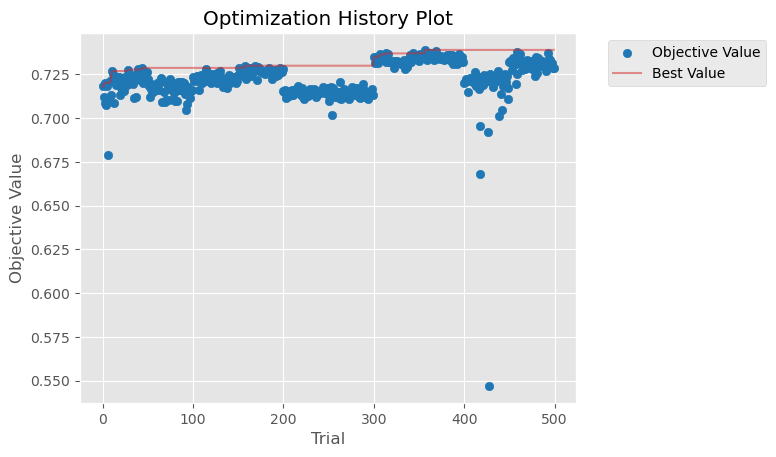

In [95]:
plot_optimization_history(study_xgb);

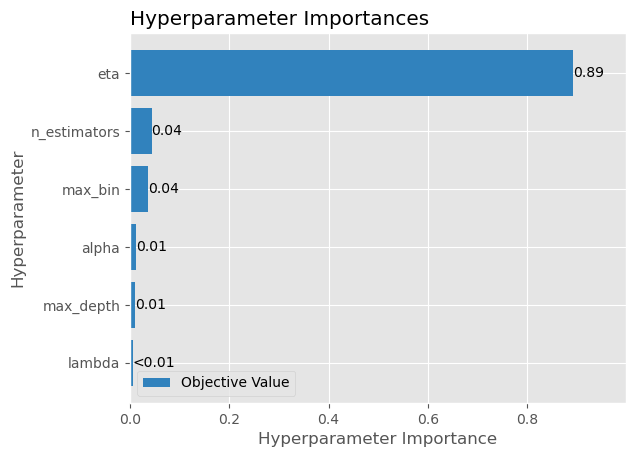

In [96]:
plot_param_importances(study_xgb);

In [97]:
detailed_objective_xgb_CV(study_xgb.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,R2,0.743639,0.035142
1,TP,18.400000,2.913570
2,TN,152.800000,2.973961
3,FP,4.800000,3.119829
4,FN,15.000000,3.299832
5,Accuracy,0.896335,0.022048
6,Precision,0.804092,0.104836
7,Sensitivity,0.551885,0.093192
8,Specificity,0.969550,0.019660
9,F1 score,0.648577,0.076970


In [98]:
mat_met_xgb_test['ave'] = mat_met_xgb_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_xgb_test['std'] = mat_met_xgb_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_xgb_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.693937,0.727582,0.711964,0.721309,0.733245,0.752080,0.742097,0.705249,0.687504,0.722362,0.719733,0.020478
1,TP,31.000000,38.000000,36.000000,35.000000,36.000000,38.000000,39.000000,29.000000,36.000000,36.000000,35.400000,3.134042
2,TN,310.000000,307.000000,309.000000,309.000000,306.000000,312.000000,308.000000,310.000000,306.000000,306.000000,308.300000,2.057507
3,FP,6.000000,8.000000,6.000000,5.000000,10.000000,4.000000,6.000000,5.000000,7.000000,9.000000,6.600000,1.897367
4,FN,35.000000,29.000000,31.000000,33.000000,30.000000,28.000000,29.000000,38.000000,33.000000,31.000000,31.700000,3.093003
5,Accuracy,0.892670,0.903141,0.903141,0.900524,0.895288,0.916230,0.908377,0.887435,0.895288,0.895288,0.899738,0.008374
6,Precision,0.837838,0.826087,0.857143,0.875000,0.782609,0.904762,0.866667,0.852941,0.837209,0.800000,0.844026,0.035792
7,Sensitivity,0.469697,0.567164,0.537313,0.514706,0.545455,0.575758,0.573529,0.432836,0.521739,0.537313,0.527551,0.045989
8,Specificity,0.981000,0.974600,0.981000,0.984100,0.968400,0.987300,0.980900,0.984100,0.977600,0.971400,0.979040,0.005999
9,F1 score,0.601942,0.672566,0.660550,0.648148,0.642857,0.703704,0.690265,0.574257,0.642857,0.642857,0.648000,0.038426


In [99]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)

r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_xgb=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_xgb = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )


        #learn
        eval_set = [(X_test, y_test)]
        optimizedCV_xgb.fit(X_train,y_train, 
            eval_set=eval_set,
            eval_metric=["rmse"],
            early_stopping_rounds=50,
            verbose= False,
                  )
                          
                  
        #print(test_idx)
        y_pred_optimized_xgb = optimizedCV_xgb.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_xgb': y_pred_optimized_xgb } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2) | (y_test<=-2)), 1, 0) 
        y_pred_optimized_xgb_cat = np.where(((y_pred_optimized_xgb >= 2) | (y_pred_optimized_xgb <= -2)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_xgb_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_xgb))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_xgb_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_xgb_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_xgb_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_xgb_cat))
        
    data_xgb['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_xgb['y_test' + str(i)] = data_inner['y_test']
    data_xgb['y_pred_xgb' + str(i)] = data_inner['y_pred_xgb']
   # data_xgb['correct' + str(i)] = correct_value
   # data_xgb['pred' + str(i)] = y_pred_optimized_xgb

mat_met_optimized_xgb = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


xgb_run0 = data_xgb[['y_test_idx0', 'y_test0', 'y_pred_xgb0']]
xgb_run0.sort_values(by='y_test_idx0', inplace=True)
xgb_run0.reset_index(inplace=True, drop=True)
xgb_run1 = data_xgb[['y_test_idx1', 'y_test1', 'y_pred_xgb1']]
xgb_run1.sort_values(by='y_test_idx1', inplace=True)
xgb_run1.reset_index(inplace=True, drop=True)
xgb_run2 = data_xgb[['y_test_idx2', 'y_test2', 'y_pred_xgb2']]
xgb_run2.sort_values(by='y_test_idx2', inplace=True)
xgb_run2.reset_index(inplace=True, drop=True)
xgb_run3 = data_xgb[['y_test_idx3', 'y_test3', 'y_pred_xgb3']]
xgb_run3.sort_values(by='y_test_idx3', inplace=True)
xgb_run3.reset_index(inplace=True, drop=True)
xgb_run4 = data_xgb[['y_test_idx4', 'y_test4', 'y_pred_xgb4']]
xgb_run4.sort_values(by='y_test_idx4', inplace=True)
xgb_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
xgb_5preds = pd.concat([chembl_id,xgb_run0, xgb_run1, xgb_run2, xgb_run3, xgb_run4], axis=1)
xgb_5preds = xgb_5preds[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_xgb0', 'y_pred_xgb1', 'y_pred_xgb2', 'y_pred_xgb3', 'y_pred_xgb4']]
xgb_5preds['y_pred_xgb_ave'] = xgb_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
xgb_5preds['y_pred_xgb_std'] = xgb_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)

mat_met_optimized_xgb

,Metric,Value (average),Value (std)
0,R2,0.742834,0.042351
1,Accuracy,0.900419,0.020250
2,Precision,0.819497,0.083098
3,Sensitivity,0.554858,0.088047
4,Specificity,0.973598,0.012987
5,F1 score,0.658198,0.079042
6,F1 score (weighted),0.892125,0.023131
7,F1 score (macro),0.799932,0.045042
8,Balanced Accuracy,0.764226,0.045567
9,MCC,0.620367,0.084828


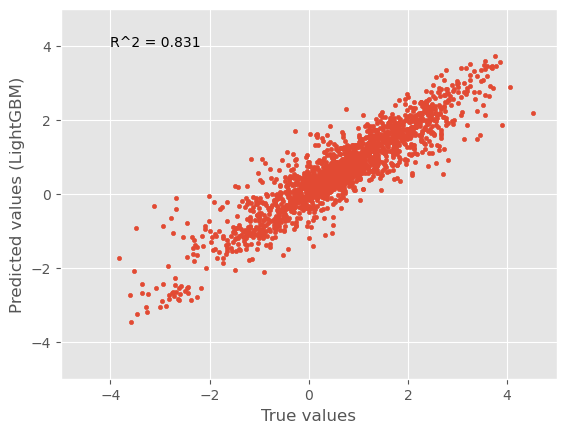

In [100]:
# Scatter plot

limits = -5,5
plt.figsize=(10,10)

plt.scatter(xgb_5preds['y_test0'], xgb_5preds['y_pred_xgb_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (LightGBM)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(xgb_5preds['y_test0'], xgb_5preds['y_pred_xgb_ave'])), (-4, 4))
plt.show()

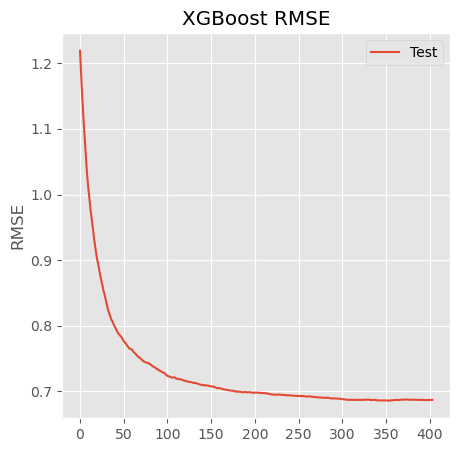

In [101]:
from matplotlib import pyplot
import matplotlib.pyplot as plt  
# retrieve performance metrics
results = optimized_xgb_0.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
    
# plot log loss
fig, ax = pyplot.subplots(figsize=(5,5))
ax.plot(x_axis, results['validation_0']['rmse'], label='Test')
ax.legend()
pyplot.ylabel('RMSE')
pyplot.title('XGBoost RMSE')
pyplot.show()

 # plot classification error
#fig, ax = pyplot.subplots(figsize=(5,5))
#ax.plot(x_axis, results['validation_0']['error'], label='Train')
#ax.plot(x_axis, results['validation_1']['error'], label='Test')
#ax.legend()
    
#pyplot.ylabel('Classification Error')
#pyplot.title('XGBoost Classification Error')
#pyplot.show()

In [102]:
#cross valide using this optimized XGBoost 
fit_params = {'early_stopping_rounds': 50, 
            'eval_set': [(X_tr, Y_tr), (X_te, Y_te)],
              'verbose' : False,
             }

xgb_baseline_CVscore = cross_val_score(xgb_reg, X, Y, cv=10, scoring="r2", )
#cv_xgb_opt_testSet = cross_val_score(optimized_xgb, X, Y, cv=10, scoring="r2", fit_params = fit_params)
cv_xgb_opt = cross_val_score(optimizedCV_xgb, X, Y, cv=10, scoring="r2", fit_params = fit_params)
print("XGBoost baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(xgb_baseline_CVscore), np.std(xgb_baseline_CVscore, ddof=1)))
#print("XGBoost optimized model (tested with Y_te) r2_score %0.4f with a standard deviation of %0.4f" % (cv_xgb_opt_testSet.mean(), cv_xgb_opt_testSet.std()))
print("XGBoost optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_xgb_opt), np.std(cv_xgb_opt, ddof=1)))

XGBoost baseline model r2_score 0.6987 with a standard deviation of 0.0646
XGBoost optimized model r2_score 0.7382 with a standard deviation of 0.0398


In [103]:
joblib.dump(xgb_reg, "OUTPUT/xgb_reg_withSemiSel.joblib")
joblib.dump(optimizedCV_xgb, "OUTPUT/optimizedCV_xgb_withSemiSel.joblib")

['OUTPUT/optimizedCV_xgb_withSemiSel.joblib']

## KNeighbors (KNN)

In [104]:
%%time


r2_scores = np.empty(10)
TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    knn_reg = KNeighborsRegressor()
    
    knn_reg.fit(X_train,y_train)

    y_pred = knn_reg.predict(X_test) 
    # r2 score of the regression model before evaluating categorical evaluation parameters
    r2_scores[idx] = r2_score(y_test, y_pred)
    # now convert the resuls to binary with cutoff 6.3
    y_test_cat = np.where(((y_test>=2) | (y_test<=-2)), 1, 0) 
    y_pred_cat = np.where(((y_pred >= 2) | (y_pred <= -2)), 1, 0)
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
    Precision[idx] = precision_score(y_test_cat, y_pred_cat)
    Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
    f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
    f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
    MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    R2         0.695705     0.041277
1                    TP        20.300000     2.496664
2                    TN       152.700000     1.702939
3                    FP         4.900000     1.728840
4                    FN        13.100000     2.766867
5              Accuracy         0.905759     0.015803
6             Precision         0.807717     0.059895
7           Sensitivity         0.608429     0.079052
8           Specificity         0.968920     0.010900
9              F1 score         0.691233     0.059250
10  F1 score (weighted)         0.900057     0.018075
11     F1 score (macro)         0.817799     0.034021
12    Balanced Accuracy         0.788676     0.039138
13                  MCC         0.647764     0.064140
14                  NPV         0.921210     0.015509
15              ROC_AUC         0.788676     0.039138
CPU times: user 1.43 s, sys: 2.89 s, total: 4.32 s
Wall time: 140 ms


In [105]:
def objective_knn_CV(trial, X, Y, Y_class):
    param_grid = {
        "n_neighbors" : trial.suggest_int("n_neighbors", 5, 30),
        "weights" :trial.suggest_categorical("weights", ['uniform', 'distance']),
        "metric" : trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski']),
        "leaf_size": trial.suggest_int("leaf_size", 20, 100)
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        
    }
    
   
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        knn_model = KNeighborsRegressor(**param_grid, n_jobs=8)
        knn_model.fit(X_train,y_train)
    
        y_pred = knn_model.predict(X_test)
    
    
        cv_scores[idx] = r2_score(y_test, y_pred)
       
        
    return np.mean(cv_scores)

In [106]:
def detailed_objective_knn_CV(trial, X, Y, Y_class):
    param_grid = {
        "n_neighbors" : trial.suggest_int("n_neighbors", 1, 30),
        "weights" :trial.suggest_categorical("weights", ['uniform', 'distance']),
        "metric" : trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski']),
        "leaf_size": trial.suggest_int("leaf_size", 20, 100)
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),      
    }
    
    r2_scores = np.empty(10)
    TP =np.empty(10)
    TN = np.empty(10)
    FP = np.empty(10)
    FN = np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M = np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        knn_model = KNeighborsRegressor(**param_grid, n_jobs=8)
        knn_model.fit(X_train,y_train)
    
        y_pred = knn_model.predict(X_test)
        
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.3
        y_test_cat = np.where(((y_test>=2) | (y_test<=-2)), 1, 0) 
        y_pred_cat = np.where(((y_pred >= 2) | (y_pred <= -2)), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
    return(mat_met)
    

In [107]:
#Execute optuna and set hyperparameters
study_knn = optuna.create_study(direction='maximize', study_name="KNNregressor")
func_knn_0 = lambda trial: objective_knn_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_knn.optimize(func_knn_0, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 04:24:00,907] A new study created in memory with name: KNNregressor
[I 2023-12-12 04:24:01,080] Trial 0 finished with value: 0.608296411925902 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 64}. Best is trial 0 with value: 0.608296411925902.
[I 2023-12-12 04:24:01,345] Trial 1 finished with value: 0.5795275096575174 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 21}. Best is trial 0 with value: 0.608296411925902.
[I 2023-12-12 04:24:01,518] Trial 2 finished with value: 0.5370403383257483 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 91}. Best is trial 0 with value: 0.608296411925902.
[I 2023-12-12 04:24:01,692] Trial 3 finished with value: 0.5268870643283033 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 27}. Best is trial 0 with value: 0.608296411925902.
[I 2023-12-12 04:24:01,866]

	Number of trials: 50.0
	Best value (r2_score): 0.6858
	Best params:
		n_neighbors: 7
		weights: distance
		metric: euclidean
		leaf_size: 48


In [108]:
#Create an instance with tuned hyperparameters

optimized_knn_0 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_0.fit(X_trainSet0,Y_trainSet0, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_0 = optimized_knn_0.predict(X_testSet0)
r2_scores = r2_score(Y_testSet0, y_pred_knn_0)
# now convert the resuls to binary with cutoff 
Y_testSet0_cat = np.where(((Y_testSet0>=2) | (Y_testSet0<=-2)), 1, 0) 
y_pred_knn_0_cat = np.where(((y_pred_knn_0 >= 2) | (y_pred_knn_0 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_knn_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_knn_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_knn_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_knn_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_knn_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_knn_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_knn_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_knn_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_knn_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_knn_0_cat)
    

mat_met_knn_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_knn_test)


                 Metric        Set0
0                    R2    0.686112
1                    TP   35.000000
2                    TN  308.000000
3                    FP    8.000000
4                    FN   31.000000
5              Accuracy    0.897906
6             Precision    0.813953
7           Sensitivity    0.530303
8           Specificity    0.974700
9              F1 score    0.642202
10  F1 score (weighted)    0.888927
11     F1 score (macro)    0.791330
12    Balanced Accuracy    0.752493
13                  MCC    0.604034
14                  NPV    0.908600
15              ROC_AUC    0.752493


In [109]:
#Execute optuna and set hyperparameters

func_knn_1 = lambda trial: objective_knn_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_knn.optimize(func_knn_1, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 04:24:12,063] Trial 50 finished with value: 0.6492104650724556 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 28}. Best is trial 35 with value: 0.6857663970176795.
[I 2023-12-12 04:24:12,242] Trial 51 finished with value: 0.6714087377783267 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 23}. Best is trial 35 with value: 0.6857663970176795.
[I 2023-12-12 04:24:12,421] Trial 52 finished with value: 0.6811408323628914 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 31}. Best is trial 35 with value: 0.6857663970176795.
[I 2023-12-12 04:24:12,600] Trial 53 finished with value: 0.6811408323628914 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 23}. Best is trial 35 with value: 0.6857663970176795.
[I 2023-12-12 04:24:12,779] Trial 54 finished with value: 0.6653834549465555 and parameters: {'n_ne

	Number of trials: 100.0
	Best value (r2_score): 0.6858
	Best params:
		n_neighbors: 7
		weights: distance
		metric: euclidean
		leaf_size: 48


In [110]:
#Create an instance with tuned hyperparameters

optimized_knn_1 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_1.fit(X_trainSet1,Y_trainSet1, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_1 = optimized_knn_1.predict(X_testSet1)
r2_scores = r2_score(Y_testSet1, y_pred_knn_1)
# now convert the resuls to binary with cutoff 
Y_testSet1_cat = np.where(((Y_testSet1>=2) | (Y_testSet1<=-2)), 1, 0) 
y_pred_knn_1_cat = np.where(((y_pred_knn_1 >= 2) | (y_pred_knn_1 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_knn_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_knn_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_knn_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_knn_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_knn_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_knn_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_knn_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_knn_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_knn_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_knn_1_cat)
    

set1 = pd.DataFrame({'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set1'] = set1
print(mat_met_knn_test)


                 Metric        Set0        Set1
0                    R2    0.686112    0.708065
1                    TP   35.000000   41.000000
2                    TN  308.000000  303.000000
3                    FP    8.000000   12.000000
4                    FN   31.000000   26.000000
5              Accuracy    0.897906    0.900524
6             Precision    0.813953    0.773585
7           Sensitivity    0.530303    0.611940
8           Specificity    0.974700    0.961900
9              F1 score    0.642202    0.683333
10  F1 score (weighted)    0.888927    0.895802
11     F1 score (macro)    0.791330    0.812164
12    Balanced Accuracy    0.752493    0.786923
13                  MCC    0.604034    0.631323
14                  NPV    0.908600    0.921000
15              ROC_AUC    0.752493    0.786923


In [111]:
#Execute optuna and set hyperparameters

func_knn_2 = lambda trial: objective_knn_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_knn.optimize(func_knn_2, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 04:24:20,847] Trial 100 finished with value: 0.6693023095293273 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 22}. Best is trial 35 with value: 0.6857663970176795.
[I 2023-12-12 04:24:21,025] Trial 101 finished with value: 0.6851440505964455 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 99}. Best is trial 35 with value: 0.6857663970176795.
[I 2023-12-12 04:24:21,202] Trial 102 finished with value: 0.6851440505964455 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 20}. Best is trial 35 with value: 0.6857663970176795.
[I 2023-12-12 04:24:21,380] Trial 103 finished with value: 0.673436194439127 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 93}. Best is trial 35 with value: 0.6857663970176795.
[I 2023-12-12 04:24:21,557] Trial 104 finished with value: 0.6793840112695253 and parameters: {'n

	Number of trials: 150.0
	Best value (r2_score): 0.6858
	Best params:
		n_neighbors: 7
		weights: distance
		metric: euclidean
		leaf_size: 48


In [112]:
#Create an instance with tuned hyperparameters

optimized_knn_2 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_2.fit(X_trainSet2,Y_trainSet2, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_2 = optimized_knn_2.predict(X_testSet2)
r2_scores = r2_score(Y_testSet2, y_pred_knn_2)
# now convert the resuls to binary with cutoff 
Y_testSet2_cat = np.where(((Y_testSet2>=2) | (Y_testSet2<=-2)), 1, 0) 
y_pred_knn_2_cat = np.where(((y_pred_knn_2 >= 2) | (y_pred_knn_2 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_knn_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_knn_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_knn_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_knn_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_knn_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_knn_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_knn_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_knn_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_knn_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_knn_2_cat)
    

Set2 = pd.DataFrame({'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set2'] = Set2
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.686112    0.708065    0.676224
1                    TP   35.000000   41.000000   38.000000
2                    TN  308.000000  303.000000  305.000000
3                    FP    8.000000   12.000000   10.000000
4                    FN   31.000000   26.000000   29.000000
5              Accuracy    0.897906    0.900524    0.897906
6             Precision    0.813953    0.773585    0.791667
7           Sensitivity    0.530303    0.611940    0.567164
8           Specificity    0.974700    0.961900    0.968300
9              F1 score    0.642202    0.683333    0.660870
10  F1 score (weighted)    0.888927    0.895802    0.890966
11     F1 score (macro)    0.791330    0.812164    0.800389
12    Balanced Accuracy    0.752493    0.786923    0.767709
13                  MCC    0.604034    0.631323    0.614316
14                  NPV    0.908600    0.921000    0.913200
15              ROC_AUC    0.752493    0

In [113]:
#Execute optuna and set hyperparameters

func_knn_3 = lambda trial: objective_knn_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_knn.optimize(func_knn_3, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 04:24:30,235] Trial 150 finished with value: 0.6834646991295641 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 27}. Best is trial 35 with value: 0.6857663970176795.
[I 2023-12-12 04:24:30,422] Trial 151 finished with value: 0.6892591466250312 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 85}. Best is trial 151 with value: 0.6892591466250312.
[I 2023-12-12 04:24:30,609] Trial 152 finished with value: 0.6892591466250312 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 76}. Best is trial 151 with value: 0.6892591466250312.
[I 2023-12-12 04:24:30,796] Trial 153 finished with value: 0.6834646991295641 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 80}. Best is trial 151 with value: 0.6892591466250312.
[I 2023-12-12 04:24:30,983] Trial 154 finished with value: 0.6892591466250312 and parameters:

	Number of trials: 200.0
	Best value (r2_score): 0.6921
	Best params:
		n_neighbors: 6
		weights: distance
		metric: manhattan
		leaf_size: 83


In [114]:
#Create an instance with tuned hyperparameters

optimized_knn_3 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_3.fit(X_trainSet3,Y_trainSet3, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_3 = optimized_knn_3.predict(X_testSet3)
r2_scores = r2_score(Y_testSet3, y_pred_knn_3)
# now convert the resuls to binary with cutoff 
Y_testSet3_cat = np.where(((Y_testSet3>=2) | (Y_testSet3<=-2)), 1, 0) 
y_pred_knn_3_cat = np.where(((y_pred_knn_3 >= 2) | (y_pred_knn_3 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_knn_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_knn_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_knn_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_knn_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_knn_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_knn_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_knn_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_knn_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_knn_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_knn_3_cat)
    

Set3 = pd.DataFrame({'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set3'] = Set3
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.686112    0.708065    0.676224    0.691604
1                    TP   35.000000   41.000000   38.000000   38.000000
2                    TN  308.000000  303.000000  305.000000  308.000000
3                    FP    8.000000   12.000000   10.000000    6.000000
4                    FN   31.000000   26.000000   29.000000   30.000000
5              Accuracy    0.897906    0.900524    0.897906    0.905759
6             Precision    0.813953    0.773585    0.791667    0.863636
7           Sensitivity    0.530303    0.611940    0.567164    0.558824
8           Specificity    0.974700    0.961900    0.968300    0.980900
9              F1 score    0.642202    0.683333    0.660870    0.678571
10  F1 score (weighted)    0.888927    0.895802    0.890966    0.897396
11     F1 score (macro)    0.791330    0.812164    0.800389    0.811678
12    Balanced Accuracy    0.752493    0.786923    0.767709    0

In [115]:
#Execute optuna and set hyperparameters

func_knn_4 = lambda trial: objective_knn_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_knn.optimize(func_knn_4, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 04:24:43,068] Trial 200 finished with value: 0.6966794648849804 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 95}. Best is trial 200 with value: 0.6966794648849804.
[I 2023-12-12 04:24:43,352] Trial 201 finished with value: 0.6966794648849804 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 95}. Best is trial 200 with value: 0.6966794648849804.
[I 2023-12-12 04:24:43,664] Trial 202 finished with value: 0.6966794648849804 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 96}. Best is trial 200 with value: 0.6966794648849804.
[I 2023-12-12 04:24:43,959] Trial 203 finished with value: 0.6966794648849804 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 95}. Best is trial 200 with value: 0.6966794648849804.
[I 2023-12-12 04:24:44,254] Trial 204 finished with value: 0.6966794648849804 and parameters

	Number of trials: 250.0
	Best value (r2_score): 0.6967
	Best params:
		n_neighbors: 6
		weights: distance
		metric: manhattan
		leaf_size: 95


In [116]:
#Create an instance with tuned hyperparameters

optimized_knn_4 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_4.fit(X_trainSet4,Y_trainSet4, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_4 = optimized_knn_4.predict(X_testSet4)
r2_scores = r2_score(Y_testSet4, y_pred_knn_4)
# now convert the resuls to binary with cutoff 
Y_testSet4_cat = np.where(((Y_testSet4>=2) | (Y_testSet4<=-2)), 1, 0) 
y_pred_knn_4_cat = np.where(((y_pred_knn_4 >= 2) | (y_pred_knn_4 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_knn_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_knn_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_knn_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_knn_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_knn_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_knn_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_knn_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_knn_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_knn_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_knn_4_cat)
    

Set4 = pd.DataFrame({'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set4'] = Set4
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.686112    0.708065    0.676224    0.691604   
1                    TP   35.000000   41.000000   38.000000   38.000000   
2                    TN  308.000000  303.000000  305.000000  308.000000   
3                    FP    8.000000   12.000000   10.000000    6.000000   
4                    FN   31.000000   26.000000   29.000000   30.000000   
5              Accuracy    0.897906    0.900524    0.897906    0.905759   
6             Precision    0.813953    0.773585    0.791667    0.863636   
7           Sensitivity    0.530303    0.611940    0.567164    0.558824   
8           Specificity    0.974700    0.961900    0.968300    0.980900   
9              F1 score    0.642202    0.683333    0.660870    0.678571   
10  F1 score (weighted)    0.888927    0.895802    0.890966    0.897396   
11     F1 score (macro)    0.791330    0.812164    0.800389    0.811678   
12    Balanced Accuracy  

In [117]:
#Execute optuna and set hyperparameters

func_knn_5 = lambda trial: objective_knn_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_knn.optimize(func_knn_5, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 04:24:57,964] Trial 250 finished with value: 0.693388883442161 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 95}. Best is trial 200 with value: 0.6966794648849804.
[I 2023-12-12 04:24:58,254] Trial 251 finished with value: 0.6895112460018012 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 98}. Best is trial 200 with value: 0.6966794648849804.
[I 2023-12-12 04:24:58,544] Trial 252 finished with value: 0.68749113119697 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 96}. Best is trial 200 with value: 0.6966794648849804.
[I 2023-12-12 04:24:58,837] Trial 253 finished with value: 0.6895112460018012 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 100}. Best is trial 200 with value: 0.6966794648849804.
[I 2023-12-12 04:24:59,135] Trial 254 finished with value: 0.693388883442161 and parameters: {

	Number of trials: 300.0
	Best value (r2_score): 0.6967
	Best params:
		n_neighbors: 6
		weights: distance
		metric: manhattan
		leaf_size: 95


In [118]:
#Create an instance with tuned hyperparameters

optimized_knn_5 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_5.fit(X_trainSet5,Y_trainSet5, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_5 = optimized_knn_5.predict(X_testSet5)
r2_scores = r2_score(Y_testSet5, y_pred_knn_5)
# now convert the resuls to binary with cutoff 
Y_testSet5_cat = np.where(((Y_testSet5>=2) | (Y_testSet5<=-2)), 1, 0) 
y_pred_knn_5_cat = np.where(((y_pred_knn_5 >= 2) | (y_pred_knn_5 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_knn_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_knn_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_knn_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_knn_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_knn_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_knn_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_knn_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_knn_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_knn_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_knn_5_cat)
    

Set5 = pd.DataFrame({'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set5'] = Set5
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.686112    0.708065    0.676224    0.691604   
1                    TP   35.000000   41.000000   38.000000   38.000000   
2                    TN  308.000000  303.000000  305.000000  308.000000   
3                    FP    8.000000   12.000000   10.000000    6.000000   
4                    FN   31.000000   26.000000   29.000000   30.000000   
5              Accuracy    0.897906    0.900524    0.897906    0.905759   
6             Precision    0.813953    0.773585    0.791667    0.863636   
7           Sensitivity    0.530303    0.611940    0.567164    0.558824   
8           Specificity    0.974700    0.961900    0.968300    0.980900   
9              F1 score    0.642202    0.683333    0.660870    0.678571   
10  F1 score (weighted)    0.888927    0.895802    0.890966    0.897396   
11     F1 score (macro)    0.791330    0.812164    0.800389    0.811678   
12    Balanced Accuracy  

In [119]:
#Execute optuna and set hyperparameters

func_knn_6 = lambda trial: objective_knn_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_knn.optimize(func_knn_6, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 04:25:12,091] Trial 300 finished with value: 0.6877460051987053 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 92}. Best is trial 200 with value: 0.6966794648849804.
[I 2023-12-12 04:25:12,363] Trial 301 finished with value: 0.6937498194858222 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 97}. Best is trial 200 with value: 0.6966794648849804.
[I 2023-12-12 04:25:12,638] Trial 302 finished with value: 0.6665525993075837 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'manhattan', 'leaf_size': 95}. Best is trial 200 with value: 0.6966794648849804.
[I 2023-12-12 04:25:12,908] Trial 303 finished with value: 0.6969358291068557 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 98}. Best is trial 303 with value: 0.6969358291068557.
[I 2023-12-12 04:25:13,203] Trial 304 finished with value: 0.6969358291068557 and parameters:

	Number of trials: 350.0
	Best value (r2_score): 0.6975
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 100


In [120]:
#Create an instance with tuned hyperparameters

optimized_knn_6 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_6.fit(X_trainSet6,Y_trainSet6, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_6 = optimized_knn_6.predict(X_testSet6)
r2_scores = r2_score(Y_testSet6, y_pred_knn_6)
# now convert the resuls to binary with cutoff 
Y_testSet6_cat = np.where(((Y_testSet6>=2) | (Y_testSet6<=-2)), 1, 0) 
y_pred_knn_6_cat = np.where(((y_pred_knn_6 >= 2) | (y_pred_knn_6 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_knn_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_knn_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_knn_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_knn_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_knn_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_knn_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_knn_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_knn_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_knn_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_knn_6_cat)
    

Set6 = pd.DataFrame({'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set6'] = Set6
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.686112    0.708065    0.676224    0.691604   
1                    TP   35.000000   41.000000   38.000000   38.000000   
2                    TN  308.000000  303.000000  305.000000  308.000000   
3                    FP    8.000000   12.000000   10.000000    6.000000   
4                    FN   31.000000   26.000000   29.000000   30.000000   
5              Accuracy    0.897906    0.900524    0.897906    0.905759   
6             Precision    0.813953    0.773585    0.791667    0.863636   
7           Sensitivity    0.530303    0.611940    0.567164    0.558824   
8           Specificity    0.974700    0.961900    0.968300    0.980900   
9              F1 score    0.642202    0.683333    0.660870    0.678571   
10  F1 score (weighted)    0.888927    0.895802    0.890966    0.897396   
11     F1 score (macro)    0.791330    0.812164    0.800389    0.811678   
12    Balanced Accuracy  

In [121]:
#Execute optuna and set hyperparameters

func_knn_7 = lambda trial: objective_knn_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_knn.optimize(func_knn_7, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 04:25:26,287] Trial 350 finished with value: 0.7032168146333427 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 98}. Best is trial 350 with value: 0.7032168146333427.
[I 2023-12-12 04:25:26,569] Trial 351 finished with value: 0.7032168146333427 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 98}. Best is trial 350 with value: 0.7032168146333427.
[I 2023-12-12 04:25:26,852] Trial 352 finished with value: 0.7032168146333427 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 98}. Best is trial 350 with value: 0.7032168146333427.
[I 2023-12-12 04:25:27,139] Trial 353 finished with value: 0.7032168146333427 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 98}. Best is trial 350 with value: 0.7032168146333427.
[I 2023-12-12 04:25:27,431] Trial 354 finished with value: 0.7032168146333427 and parameters

	Number of trials: 400.0
	Best value (r2_score): 0.7032
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 98


In [122]:
#Create an instance with tuned hyperparameters

optimized_knn_7 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_7.fit(X_trainSet7,Y_trainSet7, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_7 = optimized_knn_7.predict(X_testSet7)
r2_scores = r2_score(Y_testSet7, y_pred_knn_7)
# now convert the resuls to binary with cutoff 
Y_testSet7_cat = np.where(((Y_testSet7>=2) | (Y_testSet7<=-2)), 1, 0) 
y_pred_knn_7_cat = np.where(((y_pred_knn_7 >= 2) | (y_pred_knn_7 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_knn_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_knn_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_knn_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_knn_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_knn_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_knn_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_knn_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_knn_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_knn_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_knn_7_cat)
    

Set7 = pd.DataFrame({'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set7'] = Set7
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.686112    0.708065    0.676224    0.691604   
1                    TP   35.000000   41.000000   38.000000   38.000000   
2                    TN  308.000000  303.000000  305.000000  308.000000   
3                    FP    8.000000   12.000000   10.000000    6.000000   
4                    FN   31.000000   26.000000   29.000000   30.000000   
5              Accuracy    0.897906    0.900524    0.897906    0.905759   
6             Precision    0.813953    0.773585    0.791667    0.863636   
7           Sensitivity    0.530303    0.611940    0.567164    0.558824   
8           Specificity    0.974700    0.961900    0.968300    0.980900   
9              F1 score    0.642202    0.683333    0.660870    0.678571   
10  F1 score (weighted)    0.888927    0.895802    0.890966    0.897396   
11     F1 score (macro)    0.791330    0.812164    0.800389    0.811678   
12    Balanced Accuracy  

In [123]:
#Execute optuna and set hyperparameters

func_knn_8 = lambda trial: objective_knn_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_knn.optimize(func_knn_8, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 04:25:40,496] Trial 400 finished with value: 0.7085214009769445 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 98}. Best is trial 400 with value: 0.7085214009769445.
[I 2023-12-12 04:25:40,793] Trial 401 finished with value: 0.6815236192173421 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 97}. Best is trial 400 with value: 0.7085214009769445.
[I 2023-12-12 04:25:41,092] Trial 402 finished with value: 0.7085214009769445 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 98}. Best is trial 400 with value: 0.7085214009769445.
[I 2023-12-12 04:25:41,390] Trial 403 finished with value: 0.7085214009769445 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 97}. Best is trial 400 with value: 0.7085214009769445.
[I 2023-12-12 04:25:41,689] Trial 404 finished with value: 0.7085214009769445 and parameter

	Number of trials: 450.0
	Best value (r2_score): 0.7085
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 98


In [124]:
#Create an instance with tuned hyperparameters

optimized_knn_8 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_8.fit(X_trainSet8,Y_trainSet8, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_8 = optimized_knn_8.predict(X_testSet8)
r2_scores = r2_score(Y_testSet8, y_pred_knn_8)
# now convert the resuls to binary with cutoff 
Y_testSet8_cat = np.where(((Y_testSet8>=2) | (Y_testSet8<=-2)), 1, 0) 
y_pred_knn_8_cat = np.where(((y_pred_knn_8 >= 2) | (y_pred_knn_8 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_knn_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_knn_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_knn_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_knn_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_knn_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_knn_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_knn_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_knn_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_knn_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_knn_8_cat)
    

Set8 = pd.DataFrame({'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set8'] = Set8
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.686112    0.708065    0.676224    0.691604   
1                    TP   35.000000   41.000000   38.000000   38.000000   
2                    TN  308.000000  303.000000  305.000000  308.000000   
3                    FP    8.000000   12.000000   10.000000    6.000000   
4                    FN   31.000000   26.000000   29.000000   30.000000   
5              Accuracy    0.897906    0.900524    0.897906    0.905759   
6             Precision    0.813953    0.773585    0.791667    0.863636   
7           Sensitivity    0.530303    0.611940    0.567164    0.558824   
8           Specificity    0.974700    0.961900    0.968300    0.980900   
9              F1 score    0.642202    0.683333    0.660870    0.678571   
10  F1 score (weighted)    0.888927    0.895802    0.890966    0.897396   
11     F1 score (macro)    0.791330    0.812164    0.800389    0.811678   
12    Balanced Accuracy  

In [125]:
#Execute optuna and set hyperparameters

func_knn_9 = lambda trial: objective_knn_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_knn.optimize(func_knn_9, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 04:25:55,044] Trial 450 finished with value: 0.6871658511070657 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 93}. Best is trial 400 with value: 0.7085214009769445.
[I 2023-12-12 04:25:55,334] Trial 451 finished with value: 0.6871658511070657 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 91}. Best is trial 400 with value: 0.7085214009769445.
[I 2023-12-12 04:25:55,619] Trial 452 finished with value: 0.6839882789002683 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 89}. Best is trial 400 with value: 0.7085214009769445.
[I 2023-12-12 04:25:55,893] Trial 453 finished with value: 0.6871658511070657 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 92}. Best is trial 400 with value: 0.7085214009769445.
[I 2023-12-12 04:25:56,168] Trial 454 finished with value: 0.6871658511070657 and parameters

	Number of trials: 500.0
	Best value (r2_score): 0.7085
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 98


In [126]:
#Create an instance with tuned hyperparameters

optimized_knn_9 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_9.fit(X_trainSet9,Y_trainSet9, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_9 = optimized_knn_9.predict(X_testSet9)
r2_scores = r2_score(Y_testSet9, y_pred_knn_9)
# now convert the resuls to binary with cutoff 
Y_testSet9_cat = np.where(((Y_testSet9>=2) | (Y_testSet9<=-2)), 1, 0) 
y_pred_knn_9_cat = np.where(((y_pred_knn_9 >= 2) | (y_pred_knn_9 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_knn_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_knn_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_knn_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_knn_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_knn_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_knn_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_knn_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_knn_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_knn_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_knn_9_cat)
    

Set9 = pd.DataFrame({'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set9'] = Set9
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.686112    0.708065    0.676224    0.691604   
1                    TP   35.000000   41.000000   38.000000   38.000000   
2                    TN  308.000000  303.000000  305.000000  308.000000   
3                    FP    8.000000   12.000000   10.000000    6.000000   
4                    FN   31.000000   26.000000   29.000000   30.000000   
5              Accuracy    0.897906    0.900524    0.897906    0.905759   
6             Precision    0.813953    0.773585    0.791667    0.863636   
7           Sensitivity    0.530303    0.611940    0.567164    0.558824   
8           Specificity    0.974700    0.961900    0.968300    0.980900   
9              F1 score    0.642202    0.683333    0.660870    0.678571   
10  F1 score (weighted)    0.888927    0.895802    0.890966    0.897396   
11     F1 score (macro)    0.791330    0.812164    0.800389    0.811678   
12    Balanced Accuracy  

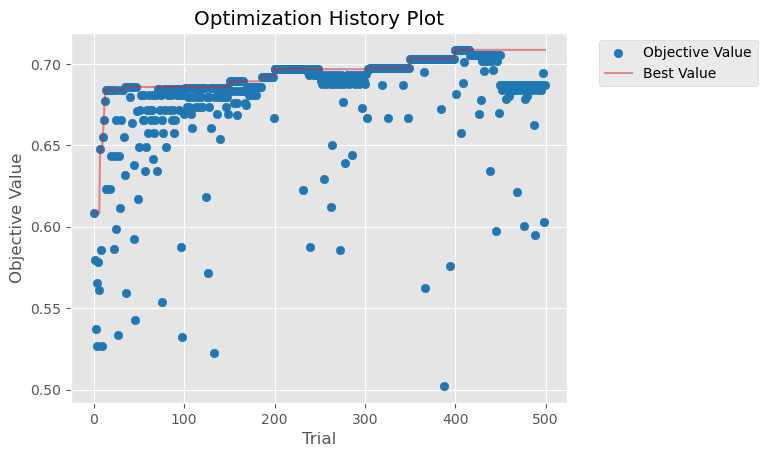

In [127]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_knn);

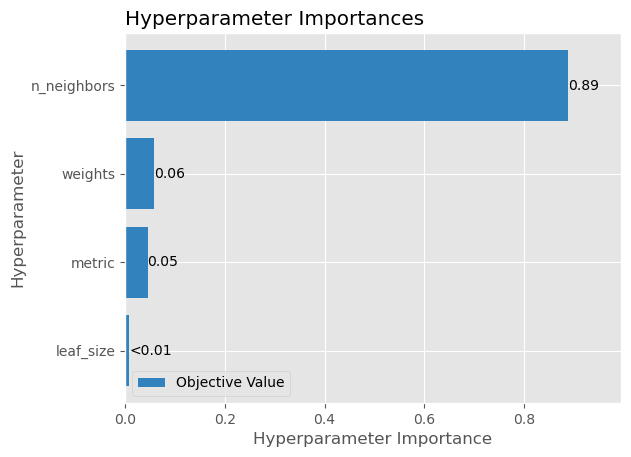

In [128]:

plot_param_importances(study_knn);

In [129]:
detailed_objective_knn_CV(study_knn.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,R2,0.714922,0.046246
1,TP,21.100000,2.806738
2,TN,152.500000,1.957890
3,FP,5.100000,2.024846
4,FN,12.300000,3.020302
5,Accuracy,0.908901,0.018337
6,Precision,0.807304,0.066426
7,Sensitivity,0.632336,0.087787
8,Specificity,0.967660,0.012780
9,F1 score,0.706110,0.068509


In [130]:
mat_met_knn_test['ave'] = mat_met_knn_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_knn_test['std'] = mat_met_knn_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_knn_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.686112,0.708065,0.676224,0.691604,0.707325,0.746283,0.675420,0.681963,0.664113,0.723107,0.696021,0.025127
1,TP,35.000000,41.000000,38.000000,38.000000,36.000000,38.000000,41.000000,39.000000,39.000000,41.000000,38.600000,2.065591
2,TN,308.000000,303.000000,305.000000,308.000000,310.000000,310.000000,300.000000,304.000000,303.000000,304.000000,305.500000,3.341656
3,FP,8.000000,12.000000,10.000000,6.000000,6.000000,6.000000,14.000000,11.000000,10.000000,11.000000,9.400000,2.796824
4,FN,31.000000,26.000000,29.000000,30.000000,30.000000,28.000000,27.000000,28.000000,30.000000,26.000000,28.500000,1.779513
5,Accuracy,0.897906,0.900524,0.897906,0.905759,0.905759,0.910995,0.892670,0.897906,0.895288,0.903141,0.900785,0.005581
6,Precision,0.813953,0.773585,0.791667,0.863636,0.857143,0.863636,0.745455,0.780000,0.795918,0.788462,0.807346,0.041247
7,Sensitivity,0.530303,0.611940,0.567164,0.558824,0.545455,0.575758,0.602941,0.582090,0.565217,0.611940,0.575163,0.027588
8,Specificity,0.974700,0.961900,0.968300,0.980900,0.981000,0.981000,0.955400,0.965100,0.968100,0.965100,0.970150,0.008919
9,F1 score,0.642202,0.683333,0.660870,0.678571,0.666667,0.690909,0.666667,0.666667,0.661017,0.689076,0.670598,0.014977


In [131]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)

r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_knn=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_knn = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )


        #learn
        
        optimizedCV_knn.fit(X_train,y_train)
                          
                  
        #print(test_idx)
        y_pred_optimized_knn = optimizedCV_knn.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_knn': y_pred_optimized_knn } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2) | (y_test<=-2)), 1, 0) 
        y_pred_optimized_knn_cat = np.where(((y_pred_optimized_knn >= 2) | (y_pred_optimized_knn <= -2)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_knn_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_knn))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_knn_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_knn_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_knn_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_knn_cat))
        
    data_knn['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_knn['y_test' + str(i)] = data_inner['y_test']
    data_knn['y_pred_knn' + str(i)] = data_inner['y_pred_knn']
   # data_knn['correct' + str(i)] = correct_value
   # data_knn['pred' + str(i)] = y_pred_optimized_knn

mat_met_optimized_knn = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


knn_run0 = data_knn[['y_test_idx0', 'y_test0', 'y_pred_knn0']]
knn_run0.sort_values(by='y_test_idx0', inplace=True)
knn_run0.reset_index(inplace=True, drop=True)
knn_run1 = data_knn[['y_test_idx1', 'y_test1', 'y_pred_knn1']]
knn_run1.sort_values(by='y_test_idx1', inplace=True)
knn_run1.reset_index(inplace=True, drop=True)
knn_run2 = data_knn[['y_test_idx2', 'y_test2', 'y_pred_knn2']]
knn_run2.sort_values(by='y_test_idx2', inplace=True)
knn_run2.reset_index(inplace=True, drop=True)
knn_run3 = data_knn[['y_test_idx3', 'y_test3', 'y_pred_knn3']]
knn_run3.sort_values(by='y_test_idx3', inplace=True)
knn_run3.reset_index(inplace=True, drop=True)
knn_run4 = data_knn[['y_test_idx4', 'y_test4', 'y_pred_knn4']]
knn_run4.sort_values(by='y_test_idx4', inplace=True)
knn_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
knn_5preds = pd.concat([chembl_id,knn_run0, knn_run1, knn_run2, knn_run3, knn_run4], axis=1)
knn_5preds = knn_5preds[['molecule_chembl_id','y_test_idx0', 'y_test0', 'y_pred_knn0', 'y_pred_knn1', 'y_pred_knn2', 'y_pred_knn3', 'y_pred_knn4']]
knn_5preds['y_pred_knn_ave'] = knn_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
knn_5preds['y_pred_knn_std'] = knn_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)

mat_met_optimized_knn

,Metric,Value (average),Value (std)
0,R2,0.716725,0.050838
1,Accuracy,0.905131,0.018643
2,Precision,0.801272,0.085042
3,Sensitivity,0.618526,0.081769
4,Specificity,0.965858,0.017652
5,F1 score,0.693725,0.063005
6,F1 score (weighted),0.900081,0.019800
7,F1 score (macro),0.818766,0.036619
8,Balanced Accuracy,0.792193,0.040259
9,MCC,0.649107,0.071957


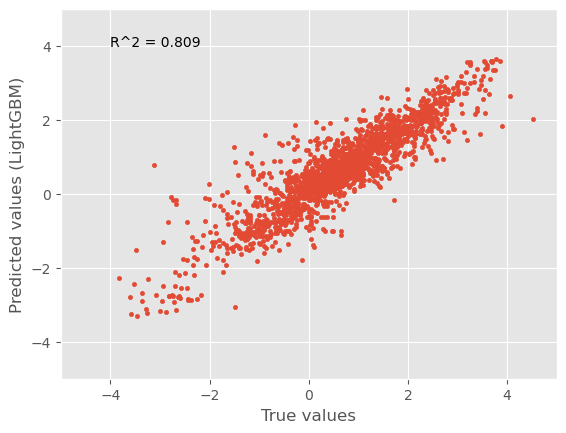

In [132]:
# Scatter plot

limits = -5,5
plt.figsize=(10,10)

plt.scatter(knn_5preds['y_test0'], knn_5preds['y_pred_knn_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (LightGBM)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(knn_5preds['y_test0'], knn_5preds['y_pred_knn_ave'])), (-4, 4))
plt.show()

In [133]:
#cross valide using this optimized KNN 
knn_baseline_CVscore = cross_val_score(knn_reg, X, Y, cv=10, scoring="r2")
#cv_knn_opt_testSet = cross_val_score(optimized_knn, X, Y, cv=10, scoring="r2")
cv_knn_opt = cross_val_score(optimizedCV_knn, X, Y, cv=10, scoring="r2")
print("KNN baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(knn_baseline_CVscore), np.std(knn_baseline_CVscore, ddof=1)))
#print("KNN optimized model (tested on Y_te) r2_score %0.4f with a standard deviation of %0.4f" % (cv_knn_opt_testSet.mean(), cv_knn_opt_testSet.std()))
print("KNN optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_knn_opt), np.std(cv_knn_opt, ddof=1)))

KNN baseline model r2_score 0.6896 with a standard deviation of 0.0361
KNN optimized model r2_score 0.7098 with a standard deviation of 0.0354


In [134]:
joblib.dump(knn_reg, "OUTPUT/knn_reg_withSemiSel.joblib")
joblib.dump(optimizedCV_knn, "OUTPUT/optimizedCV_knn_withSemiSel.joblib")

['OUTPUT/optimizedCV_knn_withSemiSel.joblib']

## Support Vector 

In [135]:
%%time

r2_scores = np.empty(10)
TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    svm_reg = SVR()
    
    svm_reg.fit(X_train, y_train, )

    y_pred = svm_reg.predict(X_test) 
    # r2 score of the regression model before evaluating categorical evaluation parameters
    r2_scores[idx] = r2_score(y_test, y_pred)
    # now convert the resuls to binary with cutoff 6.3
    y_test_cat = np.where(((y_test>=2) | (y_test<=-2)), 1, 0) 
    y_pred_cat = np.where(((y_pred >= 2) | (y_pred <= -2)), 1, 0)
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
    Precision[idx] = precision_score(y_test_cat, y_pred_cat)
    Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
    f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
    f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
    MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       }) 
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    R2         0.706392     0.039772
1                    TP        14.300000     2.213594
2                    TN       155.300000     1.636392
3                    FP         2.300000     1.766981
4                    FN        19.100000     2.330951
5              Accuracy         0.887958     0.014643
6             Precision         0.867702     0.092743
7           Sensitivity         0.428329     0.066514
8           Specificity         0.985430     0.011130
9              F1 score         0.570058     0.066023
10  F1 score (weighted)         0.871646     0.018187
11     F1 score (macro)         0.752807     0.036852
12    Balanced Accuracy         0.706878     0.033618
13                  MCC         0.558566     0.068427
14                  NPV         0.890620     0.012039
15              ROC_AUC         0.706878     0.033618
CPU times: user 3.68 s, sys: 36 ms, total: 3.72 s
Wall time: 3.72 s


In [136]:
def objective_svm_CV(trial, X, Y, Y_class):
    param_grid = {
        "C" : trial.suggest_categorical("C", [np.exp2(-7), np.exp2(-6), np.exp2(-5), np.exp2(-4), np.exp2(-3), np.exp2(-2),
                                              np.exp2(-1), np.exp2(0), np.exp2(1), np.exp2(2), np.exp2(3), np.exp2(4),
                                             np.exp2(5), np.exp2(6), np.exp2(7)]),
        "gamma" :trial.suggest_categorical("gamma", [np.exp2(-15), np.exp2(-14), np.exp2(-13), np.exp2(-12), np.exp2(-11), 
                                                     np.exp2(-10),np.exp2(-9), np.exp2(-8), np.exp2(-7), np.exp2(-6), np.exp2(-5), 
                                                     np.exp2(-4),np.exp2(-3), np.exp2(-2), np.exp2(-1), np.exp2(0), np.exp2(1),
                                                     np.exp2(2), np.exp2(3)]),
        #"kernel" : trial.suggest_categorical("kernel", ['linear', 'rbf', 'sigmoid']),
        #"degree": trial.suggest_int("degree", 3, 10)
        #"device_type": trial.suggest_categorical("device_type", ['gpu'])
        
    }
    
    
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        svm_model = SVR(**param_grid)
        svm_model.fit(X_train,y_train)
    
        y_pred = svm_model.predict(X_test)
    
    
        cv_scores[idx] = r2_score(y_test, y_pred)
       
        
    return np.mean(cv_scores)


In [137]:
def detailed_objective_svm_cv(trial, X, Y, Y_class):
    param_grid = {
        "C" : trial.suggest_categorical("C", [np.exp2(-7), np.exp2(-6), np.exp2(-5), np.exp2(-4), np.exp2(-3), np.exp2(-2),
                                              np.exp2(-1), np.exp2(0), np.exp2(1), np.exp2(2), np.exp2(3), np.exp2(4),
                                             np.exp2(5), np.exp2(6), np.exp2(7)]),
        "gamma" :trial.suggest_categorical("gamma", [np.exp2(-15), np.exp2(-14), np.exp2(-13), np.exp2(-12), np.exp2(-11), 
                                                     np.exp2(-10),np.exp2(-9), np.exp2(-8), np.exp2(-7), np.exp2(-6), np.exp2(-5), 
                                                     np.exp2(-4),np.exp2(-3), np.exp2(-2), np.exp2(-1), np.exp2(0), np.exp2(1),
                                                     np.exp2(2), np.exp2(3)]),
        #"kernel" : trial.suggest_categorical("kernel", ['linear', 'rbf', 'sigmoid']),
        #"degree": trial.suggest_int("degree", 3, 10)
        #"device_type": trial.suggest_categorical("device_type", ['gpu'])
        
    }
    
    r2_scores = np.empty(10)
    TP =np.empty(10)
    TN = np.empty(10)
    FP = np.empty(10)
    FN = np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M = np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)

    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        svm_model = SVR(**param_grid)
        svm_model.fit(X_train,y_train)
    
        y_pred = svm_model.predict(X_test)
        
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.3
        y_test_cat = np.where(((y_test>=2) | (y_test<=-2)), 1, 0) 
        y_pred_cat = np.where(((y_pred >= 2) | (y_pred <= -2)), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
    return(mat_met)
   

In [138]:
#Execute optuna and set hyperparameters
study_svm = optuna.create_study(direction='maximize', study_name="SVM_regressor_CV")
func_svm_0 = lambda trial: objective_svm_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_svm.optimize(func_svm_0, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 04:26:17,301] A new study created in memory with name: SVM_regressor_CV
[I 2023-12-12 04:26:19,851] Trial 0 finished with value: 0.7197298549340498 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 0 with value: 0.7197298549340498.
[I 2023-12-12 04:26:22,948] Trial 1 finished with value: 0.6502386230692203 and parameters: {'C': 64.0, 'gamma': 0.0009765625}. Best is trial 0 with value: 0.7197298549340498.
[I 2023-12-12 04:26:25,378] Trial 2 finished with value: 0.28516672849412694 and parameters: {'C': 4.0, 'gamma': 6.103515625e-05}. Best is trial 0 with value: 0.7197298549340498.
[I 2023-12-12 04:26:27,974] Trial 3 finished with value: -0.011740034769186326 and parameters: {'C': 0.015625, 'gamma': 1.0}. Best is trial 0 with value: 0.7197298549340498.
[I 2023-12-12 04:26:30,411] Trial 4 finished with value: 0.5938235847275689 and parameters: {'C': 128.0, 'gamma': 0.0625}. Best is trial 0 with value: 0.7197298549340498.
[I 2023-12-12 04:26:32,940] Trial 5 finish

	Number of trials: 50.0
	Best value (r2_score): 0.7197
	Best params:
		C: 32.0
		gamma: 0.015625


In [139]:
#Create an instance with tuned hyperparameters

optimized_svm_0 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_0.fit(X_trainSet0,Y_trainSet0,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_0 = optimized_svm_0.predict(X_testSet0)
r2_scores = r2_score(Y_testSet0, y_pred_svm_0)
# now convert the resuls to binary with cutoff 6.3
Y_testSet0_cat = np.where(((Y_testSet0>=2) | (Y_testSet0<=-2)), 1, 0) 
y_pred_svm_0_cat = np.where(((y_pred_svm_0 >= 2) | (y_pred_svm_0 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_svm_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_svm_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_svm_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_svm_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_svm_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_svm_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_svm_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_svm_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_svm_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_svm_0_cat)
    

mat_met_svm_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_svm_test)


                 Metric        Set0
0                    R2    0.693504
1                    TP   26.000000
2                    TN  310.000000
3                    FP    6.000000
4                    FN   40.000000
5              Accuracy    0.879581
6             Precision    0.812500
7           Sensitivity    0.393939
8           Specificity    0.981000
9              F1 score    0.530612
10  F1 score (weighted)    0.861766
11     F1 score (macro)    0.730772
12    Balanced Accuracy    0.687476
13                  MCC    0.511661
14                  NPV    0.885700
15              ROC_AUC    0.687476


In [140]:
#Execute optuna and set hyperparameters
func_svm_1 = lambda trial: objective_svm_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_svm.optimize(func_svm_1, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 04:28:31,552] Trial 50 finished with value: 0.2768464137123333 and parameters: {'C': 1.0, 'gamma': 0.000244140625}. Best is trial 0 with value: 0.7197298549340498.
[I 2023-12-12 04:28:33,982] Trial 51 finished with value: 0.7204832983815803 and parameters: {'C': 64.0, 'gamma': 0.015625}. Best is trial 51 with value: 0.7204832983815803.
[I 2023-12-12 04:28:36,417] Trial 52 finished with value: 0.7204832983815803 and parameters: {'C': 64.0, 'gamma': 0.015625}. Best is trial 51 with value: 0.7204832983815803.
[I 2023-12-12 04:28:39,127] Trial 53 finished with value: 0.6298851199091605 and parameters: {'C': 64.0, 'gamma': 0.00048828125}. Best is trial 51 with value: 0.7204832983815803.
[I 2023-12-12 04:28:41,609] Trial 54 finished with value: 0.003327774528021188 and parameters: {'C': 0.03125, 'gamma': 0.125}. Best is trial 51 with value: 0.7204832983815803.
[I 2023-12-12 04:28:44,318] Trial 55 finished with value: 0.7028130957756173 and parameters: {'C': 64.0, 'gamma': 0.007

	Number of trials: 100.0
	Best value (r2_score): 0.7221
	Best params:
		C: 16.0
		gamma: 0.015625


In [141]:
#Create an instance with tuned hyperparameters

optimized_svm_1 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_1.fit(X_trainSet1,Y_trainSet1,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_1 = optimized_svm_1.predict(X_testSet1)
r2_scores = r2_score(Y_testSet1, y_pred_svm_1)
# now convert the resuls to binary with cutoff 6.3
Y_testSet1_cat = np.where(((Y_testSet1>=2) | (Y_testSet1<=-2)), 1, 0) 
y_pred_svm_1_cat = np.where(((y_pred_svm_1 >= 2) | (y_pred_svm_1 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_svm_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_svm_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_svm_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_svm_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_svm_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_svm_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_svm_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_svm_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_svm_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_svm_1_cat)
    

set1 = pd.DataFrame({'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set1'] = set1
print(mat_met_svm_test)


                 Metric        Set0        Set1
0                    R2    0.693504    0.714602
1                    TP   26.000000   42.000000
2                    TN  310.000000  307.000000
3                    FP    6.000000    8.000000
4                    FN   40.000000   25.000000
5              Accuracy    0.879581    0.913613
6             Precision    0.812500    0.840000
7           Sensitivity    0.393939    0.626866
8           Specificity    0.981000    0.974600
9              F1 score    0.530612    0.717949
10  F1 score (weighted)    0.861766    0.908471
11     F1 score (macro)    0.730772    0.833472
12    Balanced Accuracy    0.687476    0.800734
13                  MCC    0.511661    0.678191
14                  NPV    0.885700    0.924700
15              ROC_AUC    0.687476    0.800734


In [142]:
#Execute optuna and set hyperparameters
func_svm_2 = lambda trial: objective_svm_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_svm.optimize(func_svm_2, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 04:30:37,636] Trial 100 finished with value: 0.513481982489479 and parameters: {'C': 0.25, 'gamma': 0.03125}. Best is trial 64 with value: 0.7221050497786112.
[I 2023-12-12 04:30:40,188] Trial 101 finished with value: 0.716817221202538 and parameters: {'C': 16.0, 'gamma': 0.015625}. Best is trial 64 with value: 0.7221050497786112.
[I 2023-12-12 04:30:42,735] Trial 102 finished with value: 0.716817221202538 and parameters: {'C': 16.0, 'gamma': 0.015625}. Best is trial 64 with value: 0.7221050497786112.
[I 2023-12-12 04:30:45,296] Trial 103 finished with value: 0.716817221202538 and parameters: {'C': 16.0, 'gamma': 0.015625}. Best is trial 64 with value: 0.7221050497786112.
[I 2023-12-12 04:30:48,007] Trial 104 finished with value: 0.07996962503136991 and parameters: {'C': 16.0, 'gamma': 0.25}. Best is trial 64 with value: 0.7221050497786112.
[I 2023-12-12 04:30:50,552] Trial 105 finished with value: 0.716817221202538 and parameters: {'C': 16.0, 'gamma': 0.015625}. Best is 

	Number of trials: 150.0
	Best value (r2_score): 0.7221
	Best params:
		C: 16.0
		gamma: 0.015625


In [143]:
#Create an instance with tuned hyperparameters

optimized_svm_2 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_2.fit(X_trainSet2,Y_trainSet2,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_2 = optimized_svm_2.predict(X_testSet2)
r2_scores = r2_score(Y_testSet2, y_pred_svm_2)
# now convert the resuls to binary with cutoff 6.3
Y_testSet2_cat = np.where(((Y_testSet2>=2) | (Y_testSet2<=-2)), 1, 0) 
y_pred_svm_2_cat = np.where(((y_pred_svm_2 >= 2) | (y_pred_svm_2 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_svm_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_svm_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_svm_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_svm_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_svm_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_svm_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_svm_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_svm_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_svm_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_svm_2_cat)
    

Set2 = pd.DataFrame({'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set2'] = Set2
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.693504    0.714602    0.720508
1                    TP   26.000000   42.000000   35.000000
2                    TN  310.000000  307.000000  312.000000
3                    FP    6.000000    8.000000    3.000000
4                    FN   40.000000   25.000000   32.000000
5              Accuracy    0.879581    0.913613    0.908377
6             Precision    0.812500    0.840000    0.921053
7           Sensitivity    0.393939    0.626866    0.522388
8           Specificity    0.981000    0.974600    0.990500
9              F1 score    0.530612    0.717949    0.666667
10  F1 score (weighted)    0.861766    0.908471    0.897740
11     F1 score (macro)    0.730772    0.833472    0.806778
12    Balanced Accuracy    0.687476    0.800734    0.756432
13                  MCC    0.511661    0.678191    0.651665
14                  NPV    0.885700    0.924700    0.907000
15              ROC_AUC    0.687476    0

In [144]:
#Execute optuna and set hyperparameters
func_svm_3 = lambda trial: objective_svm_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_svm.optimize(func_svm_3, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 04:32:47,104] Trial 150 finished with value: 0.08042314280296495 and parameters: {'C': 0.0078125, 'gamma': 0.015625}. Best is trial 64 with value: 0.7221050497786112.
[I 2023-12-12 04:32:49,540] Trial 151 finished with value: 0.7204694522080753 and parameters: {'C': 16.0, 'gamma': 0.015625}. Best is trial 64 with value: 0.7221050497786112.
[I 2023-12-12 04:32:51,980] Trial 152 finished with value: 0.7204694522080753 and parameters: {'C': 16.0, 'gamma': 0.015625}. Best is trial 64 with value: 0.7221050497786112.
[I 2023-12-12 04:32:54,589] Trial 153 finished with value: 0.04806838273049766 and parameters: {'C': 16.0, 'gamma': 0.5}. Best is trial 64 with value: 0.7221050497786112.
[I 2023-12-12 04:32:57,020] Trial 154 finished with value: 0.7204694522080753 and parameters: {'C': 16.0, 'gamma': 0.015625}. Best is trial 64 with value: 0.7221050497786112.
[I 2023-12-12 04:32:59,452] Trial 155 finished with value: 0.7204694522080753 and parameters: {'C': 16.0, 'gamma': 0.015625

	Number of trials: 200.0
	Best value (r2_score): 0.7221
	Best params:
		C: 16.0
		gamma: 0.015625


In [145]:
#Create an instance with tuned hyperparameters

optimized_svm_3 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_3.fit(X_trainSet3,Y_trainSet3,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_3 = optimized_svm_3.predict(X_testSet3)
r2_scores = r2_score(Y_testSet3, y_pred_svm_3)
# now convert the resuls to binary with cutoff 6.3
Y_testSet3_cat = np.where(((Y_testSet3>=2) | (Y_testSet3<=-2)), 1, 0) 
y_pred_svm_3_cat = np.where(((y_pred_svm_3 >= 2) | (y_pred_svm_3 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_svm_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_svm_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_svm_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_svm_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_svm_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_svm_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_svm_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_svm_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_svm_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_svm_3_cat)
    

Set3 = pd.DataFrame({'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set3'] = Set3
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.693504    0.714602    0.720508    0.693961
1                    TP   26.000000   42.000000   35.000000   29.000000
2                    TN  310.000000  307.000000  312.000000  310.000000
3                    FP    6.000000    8.000000    3.000000    4.000000
4                    FN   40.000000   25.000000   32.000000   39.000000
5              Accuracy    0.879581    0.913613    0.908377    0.887435
6             Precision    0.812500    0.840000    0.921053    0.878788
7           Sensitivity    0.393939    0.626866    0.522388    0.426471
8           Specificity    0.981000    0.974600    0.990500    0.987300
9              F1 score    0.530612    0.717949    0.666667    0.574257
10  F1 score (weighted)    0.861766    0.908471    0.897740    0.870902
11     F1 score (macro)    0.730772    0.833472    0.806778    0.754700
12    Balanced Accuracy    0.687476    0.800734    0.756432    0

In [146]:
#Execute optuna and set hyperparameters
func_svm_4 = lambda trial: objective_svm_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_svm.optimize(func_svm_4, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 04:34:49,256] Trial 200 finished with value: 0.049666486519135924 and parameters: {'C': 16.0, 'gamma': 0.5}. Best is trial 64 with value: 0.7221050497786112.
[I 2023-12-12 04:34:51,801] Trial 201 finished with value: 0.7256842948031623 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 201 with value: 0.7256842948031623.
[I 2023-12-12 04:34:54,353] Trial 202 finished with value: 0.7256842948031623 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 201 with value: 0.7256842948031623.
[I 2023-12-12 04:34:56,814] Trial 203 finished with value: 0.5912000911955507 and parameters: {'C': 16.0, 'gamma': 0.0625}. Best is trial 201 with value: 0.7256842948031623.
[I 2023-12-12 04:34:59,365] Trial 204 finished with value: 0.7256842948031623 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 201 with value: 0.7256842948031623.
[I 2023-12-12 04:35:01,913] Trial 205 finished with value: 0.7256842948031623 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best

	Number of trials: 250.0
	Best value (r2_score): 0.7257
	Best params:
		C: 8.0
		gamma: 0.015625


In [147]:
#Create an instance with tuned hyperparameters

optimized_svm_4 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_4.fit(X_trainSet4,Y_trainSet4,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_4 = optimized_svm_4.predict(X_testSet4)
r2_scores = r2_score(Y_testSet4, y_pred_svm_4)
# now convert the resuls to binary with cutoff 6.4
Y_testSet4_cat = np.where(((Y_testSet4>=2) | (Y_testSet4<=-2)), 1, 0) 
y_pred_svm_4_cat = np.where(((y_pred_svm_4 >= 2) | (y_pred_svm_4 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_svm_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_svm_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_svm_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_svm_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_svm_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_svm_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_svm_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_svm_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_svm_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_svm_4_cat)
    

Set4 = pd.DataFrame({'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set4'] = Set4
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.693504    0.714602    0.720508    0.693961   
1                    TP   26.000000   42.000000   35.000000   29.000000   
2                    TN  310.000000  307.000000  312.000000  310.000000   
3                    FP    6.000000    8.000000    3.000000    4.000000   
4                    FN   40.000000   25.000000   32.000000   39.000000   
5              Accuracy    0.879581    0.913613    0.908377    0.887435   
6             Precision    0.812500    0.840000    0.921053    0.878788   
7           Sensitivity    0.393939    0.626866    0.522388    0.426471   
8           Specificity    0.981000    0.974600    0.990500    0.987300   
9              F1 score    0.530612    0.717949    0.666667    0.574257   
10  F1 score (weighted)    0.861766    0.908471    0.897740    0.870902   
11     F1 score (macro)    0.730772    0.833472    0.806778    0.754700   
12    Balanced Accuracy  

In [148]:
#Execute optuna and set hyperparameters
func_svm_5 = lambda trial: objective_svm_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_svm.optimize(func_svm_5, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 04:36:57,626] Trial 250 finished with value: 0.7153954955800031 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 201 with value: 0.7256842948031623.
[I 2023-12-12 04:37:00,032] Trial 251 finished with value: 0.7153954955800031 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 201 with value: 0.7256842948031623.
[I 2023-12-12 04:37:02,573] Trial 252 finished with value: 0.7060360166591877 and parameters: {'C': 8.0, 'gamma': 0.0078125}. Best is trial 201 with value: 0.7256842948031623.
[I 2023-12-12 04:37:04,975] Trial 253 finished with value: 0.7153954955800031 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 201 with value: 0.7256842948031623.
[I 2023-12-12 04:37:07,520] Trial 254 finished with value: 0.6829177540695747 and parameters: {'C': 8.0, 'gamma': 0.00390625}. Best is trial 201 with value: 0.7256842948031623.
[I 2023-12-12 04:37:09,938] Trial 255 finished with value: 0.7153954955800031 and parameters: {'C': 8.0, 'gamma': 0.015625

	Number of trials: 300.0
	Best value (r2_score): 0.7257
	Best params:
		C: 8.0
		gamma: 0.015625


In [149]:
#Create an instance with tuned hyperparameters

optimized_svm_5 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_5.fit(X_trainSet5,Y_trainSet5,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_5 = optimized_svm_5.predict(X_testSet5)
r2_scores = r2_score(Y_testSet5, y_pred_svm_5)
# now convert the resuls to binary with cutoff 6.5
Y_testSet5_cat = np.where(((Y_testSet5>=2) | (Y_testSet5<=-2)), 1, 0) 
y_pred_svm_5_cat = np.where(((y_pred_svm_5 >= 2) | (y_pred_svm_5 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_svm_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_svm_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_svm_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_svm_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_svm_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_svm_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_svm_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_svm_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_svm_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_svm_5_cat)
    

Set5 = pd.DataFrame({'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set5'] = Set5
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.693504    0.714602    0.720508    0.693961   
1                    TP   26.000000   42.000000   35.000000   29.000000   
2                    TN  310.000000  307.000000  312.000000  310.000000   
3                    FP    6.000000    8.000000    3.000000    4.000000   
4                    FN   40.000000   25.000000   32.000000   39.000000   
5              Accuracy    0.879581    0.913613    0.908377    0.887435   
6             Precision    0.812500    0.840000    0.921053    0.878788   
7           Sensitivity    0.393939    0.626866    0.522388    0.426471   
8           Specificity    0.981000    0.974600    0.990500    0.987300   
9              F1 score    0.530612    0.717949    0.666667    0.574257   
10  F1 score (weighted)    0.861766    0.908471    0.897740    0.870902   
11     F1 score (macro)    0.730772    0.833472    0.806778    0.754700   
12    Balanced Accuracy  

In [150]:
#Execute optuna and set hyperparameters
func_svm_6 = lambda trial: objective_svm_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_svm.optimize(func_svm_6, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 04:38:59,779] Trial 300 finished with value: 0.7257421422924062 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 300 with value: 0.7257421422924062.
[I 2023-12-12 04:39:02,448] Trial 301 finished with value: 0.026163919722783712 and parameters: {'C': 32.0, 'gamma': 2.0}. Best is trial 300 with value: 0.7257421422924062.
[I 2023-12-12 04:39:05,063] Trial 302 finished with value: 0.3315254520959642 and parameters: {'C': 0.0625, 'gamma': 0.015625}. Best is trial 300 with value: 0.7257421422924062.
[I 2023-12-12 04:39:07,585] Trial 303 finished with value: 0.7018672175641584 and parameters: {'C': 32.0, 'gamma': 0.03125}. Best is trial 300 with value: 0.7257421422924062.
[I 2023-12-12 04:39:10,180] Trial 304 finished with value: 0.7257421422924062 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 300 with value: 0.7257421422924062.
[I 2023-12-12 04:39:12,772] Trial 305 finished with value: 0.7257421422924062 and parameters: {'C': 32.0, 'gamma': 0.01562

	Number of trials: 350.0
	Best value (r2_score): 0.7257
	Best params:
		C: 32.0
		gamma: 0.015625


In [151]:
#Create an instance with tuned hyperparameters

optimized_svm_6 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_6.fit(X_trainSet6,Y_trainSet6,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_6 = optimized_svm_6.predict(X_testSet6)
r2_scores = r2_score(Y_testSet6, y_pred_svm_6)
# now convert the resuls to binary with cutoff 6.6
Y_testSet6_cat = np.where(((Y_testSet6>=2) | (Y_testSet6<=-2)), 1, 0) 
y_pred_svm_6_cat = np.where(((y_pred_svm_6 >= 2) | (y_pred_svm_6 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_svm_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_svm_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_svm_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_svm_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_svm_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_svm_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_svm_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_svm_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_svm_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_svm_6_cat)
    

Set6 = pd.DataFrame({'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set6'] = Set6
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.693504    0.714602    0.720508    0.693961   
1                    TP   26.000000   42.000000   35.000000   29.000000   
2                    TN  310.000000  307.000000  312.000000  310.000000   
3                    FP    6.000000    8.000000    3.000000    4.000000   
4                    FN   40.000000   25.000000   32.000000   39.000000   
5              Accuracy    0.879581    0.913613    0.908377    0.887435   
6             Precision    0.812500    0.840000    0.921053    0.878788   
7           Sensitivity    0.393939    0.626866    0.522388    0.426471   
8           Specificity    0.981000    0.974600    0.990500    0.987300   
9              F1 score    0.530612    0.717949    0.666667    0.574257   
10  F1 score (weighted)    0.861766    0.908471    0.897740    0.870902   
11     F1 score (macro)    0.730772    0.833472    0.806778    0.754700   
12    Balanced Accuracy  

In [152]:
#Execute optuna and set hyperparameters
func_svm_7 = lambda trial: objective_svm_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_svm.optimize(func_svm_7, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 04:41:10,820] Trial 350 finished with value: 0.015370829585127598 and parameters: {'C': 32.0, 'gamma': 2.0}. Best is trial 300 with value: 0.7257421422924062.
[I 2023-12-12 04:41:13,185] Trial 351 finished with value: 0.730483142268576 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 351 with value: 0.730483142268576.
[I 2023-12-12 04:41:15,583] Trial 352 finished with value: 0.730483142268576 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 351 with value: 0.730483142268576.
[I 2023-12-12 04:41:18,001] Trial 353 finished with value: 0.730483142268576 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 351 with value: 0.730483142268576.
[I 2023-12-12 04:41:20,412] Trial 354 finished with value: 0.730483142268576 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 351 with value: 0.730483142268576.
[I 2023-12-12 04:41:22,824] Trial 355 finished with value: 0.730483142268576 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best i

	Number of trials: 400.0
	Best value (r2_score): 0.7305
	Best params:
		C: 32.0
		gamma: 0.015625


In [153]:
#Create an instance with tuned hyperparameters

optimized_svm_7 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_7.fit(X_trainSet7,Y_trainSet7,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_7 = optimized_svm_7.predict(X_testSet7)
r2_scores = r2_score(Y_testSet7, y_pred_svm_7)
# now convert the resuls to binary with cutoff 6.7
Y_testSet7_cat = np.where(((Y_testSet7>=2) | (Y_testSet7<=-2)), 1, 0) 
y_pred_svm_7_cat = np.where(((y_pred_svm_7 >= 2) | (y_pred_svm_7 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_svm_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_svm_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_svm_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_svm_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_svm_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_svm_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_svm_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_svm_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_svm_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_svm_7_cat)
    

Set7 = pd.DataFrame({'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set7'] = Set7
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.693504    0.714602    0.720508    0.693961   
1                    TP   26.000000   42.000000   35.000000   29.000000   
2                    TN  310.000000  307.000000  312.000000  310.000000   
3                    FP    6.000000    8.000000    3.000000    4.000000   
4                    FN   40.000000   25.000000   32.000000   39.000000   
5              Accuracy    0.879581    0.913613    0.908377    0.887435   
6             Precision    0.812500    0.840000    0.921053    0.878788   
7           Sensitivity    0.393939    0.626866    0.522388    0.426471   
8           Specificity    0.981000    0.974600    0.990500    0.987300   
9              F1 score    0.530612    0.717949    0.666667    0.574257   
10  F1 score (weighted)    0.861766    0.908471    0.897740    0.870902   
11     F1 score (macro)    0.730772    0.833472    0.806778    0.754700   
12    Balanced Accuracy  

In [154]:
#Execute optuna and set hyperparameters
func_svm_8 = lambda trial: objective_svm_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_svm.optimize(func_svm_8, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 04:43:13,080] Trial 400 finished with value: 0.7009217881330263 and parameters: {'C': 32.0, 'gamma': 0.03125}. Best is trial 351 with value: 0.730483142268576.
[I 2023-12-12 04:43:15,425] Trial 401 finished with value: 0.6994371063211258 and parameters: {'C': 1.0, 'gamma': 0.015625}. Best is trial 351 with value: 0.730483142268576.
[I 2023-12-12 04:43:17,852] Trial 402 finished with value: 0.6495694988935086 and parameters: {'C': 0.5, 'gamma': 0.015625}. Best is trial 351 with value: 0.730483142268576.
[I 2023-12-12 04:43:20,241] Trial 403 finished with value: 0.5643898071052318 and parameters: {'C': 0.25, 'gamma': 0.015625}. Best is trial 351 with value: 0.730483142268576.
[I 2023-12-12 04:43:22,737] Trial 404 finished with value: 0.222673459545786 and parameters: {'C': 0.03125, 'gamma': 0.015625}. Best is trial 351 with value: 0.730483142268576.
[I 2023-12-12 04:43:25,430] Trial 405 finished with value: 0.0805796475168697 and parameters: {'C': 2.0, 'gamma': 0.25}. Best 

	Number of trials: 450.0
	Best value (r2_score): 0.7305
	Best params:
		C: 32.0
		gamma: 0.015625


In [155]:
#Create an instance with tuned hyperparameters

optimized_svm_8 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_8.fit(X_trainSet8,Y_trainSet8,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_8 = optimized_svm_8.predict(X_testSet8)
r2_scores = r2_score(Y_testSet8, y_pred_svm_8)
# now convert the resuls to binary with cutoff 6.8
Y_testSet8_cat = np.where(((Y_testSet8>=2) | (Y_testSet8<=-2)), 1, 0) 
y_pred_svm_8_cat = np.where(((y_pred_svm_8 >= 2) | (y_pred_svm_8 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_svm_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_svm_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_svm_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_svm_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_svm_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_svm_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_svm_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_svm_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_svm_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_svm_8_cat)
    

Set8 = pd.DataFrame({'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set8'] = Set8
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.693504    0.714602    0.720508    0.693961   
1                    TP   26.000000   42.000000   35.000000   29.000000   
2                    TN  310.000000  307.000000  312.000000  310.000000   
3                    FP    6.000000    8.000000    3.000000    4.000000   
4                    FN   40.000000   25.000000   32.000000   39.000000   
5              Accuracy    0.879581    0.913613    0.908377    0.887435   
6             Precision    0.812500    0.840000    0.921053    0.878788   
7           Sensitivity    0.393939    0.626866    0.522388    0.426471   
8           Specificity    0.981000    0.974600    0.990500    0.987300   
9              F1 score    0.530612    0.717949    0.666667    0.574257   
10  F1 score (weighted)    0.861766    0.908471    0.897740    0.870902   
11     F1 score (macro)    0.730772    0.833472    0.806778    0.754700   
12    Balanced Accuracy  

In [156]:
#Execute optuna and set hyperparameters
func_svm_9 = lambda trial: objective_svm_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_svm.optimize(func_svm_9, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-12 04:45:21,217] Trial 450 finished with value: 0.04312884582647104 and parameters: {'C': 32.0, 'gamma': 0.5}. Best is trial 351 with value: 0.730483142268576.
[I 2023-12-12 04:45:23,802] Trial 451 finished with value: 0.08414779288569925 and parameters: {'C': 64.0, 'gamma': 0.25}. Best is trial 351 with value: 0.730483142268576.
[I 2023-12-12 04:45:26,163] Trial 452 finished with value: 0.7166905431554212 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 351 with value: 0.730483142268576.
[I 2023-12-12 04:45:28,453] Trial 453 finished with value: 0.19876859967337118 and parameters: {'C': 0.125, 'gamma': 0.0625}. Best is trial 351 with value: 0.730483142268576.
[I 2023-12-12 04:45:30,818] Trial 454 finished with value: 0.7166905431554212 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 351 with value: 0.730483142268576.
[I 2023-12-12 04:45:33,179] Trial 455 finished with value: 0.7166905431554212 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best i

	Number of trials: 500.0
	Best value (r2_score): 0.7305
	Best params:
		C: 32.0
		gamma: 0.015625


In [157]:
#Create an instance with tuned hyperparameters

optimized_svm_9 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_9.fit(X_trainSet9,Y_trainSet9,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_9 = optimized_svm_9.predict(X_testSet9)
r2_scores = r2_score(Y_testSet9, y_pred_svm_9)
# now convert the resuls to binary with cutoff 6.9
Y_testSet9_cat = np.where(((Y_testSet9>=2) | (Y_testSet9<=-2)), 1, 0) 
y_pred_svm_9_cat = np.where(((y_pred_svm_9 >= 2) | (y_pred_svm_9 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_svm_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_svm_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_svm_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_svm_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_svm_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_svm_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_svm_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_svm_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_svm_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_svm_9_cat)
    

Set9 = pd.DataFrame({'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set9'] = Set9
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.693504    0.714602    0.720508    0.693961   
1                    TP   26.000000   42.000000   35.000000   29.000000   
2                    TN  310.000000  307.000000  312.000000  310.000000   
3                    FP    6.000000    8.000000    3.000000    4.000000   
4                    FN   40.000000   25.000000   32.000000   39.000000   
5              Accuracy    0.879581    0.913613    0.908377    0.887435   
6             Precision    0.812500    0.840000    0.921053    0.878788   
7           Sensitivity    0.393939    0.626866    0.522388    0.426471   
8           Specificity    0.981000    0.974600    0.990500    0.987300   
9              F1 score    0.530612    0.717949    0.666667    0.574257   
10  F1 score (weighted)    0.861766    0.908471    0.897740    0.870902   
11     F1 score (macro)    0.730772    0.833472    0.806778    0.754700   
12    Balanced Accuracy  

In [158]:
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

	Number of trials: 500.0
	Best value (r2_score): 0.7305
	Best params:
		C: 32.0
		gamma: 0.015625


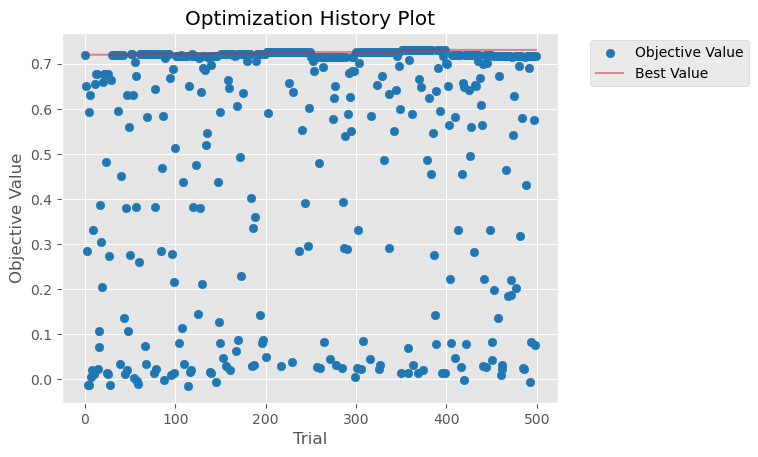

In [159]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_svm);

In [160]:
#from optuna.visualization.matplotlib import plot_param_importances

#plot_param_importances(study_svm);

In [161]:
detailed_objective_svm_cv(study_svm.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,R2,0.734461,0.034117
1,TP,17.700000,1.494434
2,TN,154.200000,1.988858
3,FP,3.400000,2.270585
4,FN,15.700000,1.766981
5,Accuracy,0.900000,0.014059
6,Precision,0.846001,0.089536
7,Sensitivity,0.530317,0.047339
8,Specificity,0.978470,0.014303
9,F1 score,0.649498,0.047007


In [162]:
mat_met_svm_test['ave'] = mat_met_svm_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_svm_test['std'] = mat_met_svm_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_svm_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.693504,0.714602,0.720508,0.693961,0.726193,0.743756,0.705405,0.701961,0.694226,0.700289,0.709441,0.016628
1,TP,26.000000,42.000000,35.000000,29.000000,33.000000,29.000000,28.000000,27.000000,31.000000,32.000000,31.200000,4.709329
2,TN,310.000000,307.000000,312.000000,310.000000,312.000000,311.000000,308.000000,311.000000,310.000000,313.000000,310.400000,1.837873
3,FP,6.000000,8.000000,3.000000,4.000000,4.000000,5.000000,6.000000,4.000000,3.000000,2.000000,4.500000,1.779513
4,FN,40.000000,25.000000,32.000000,39.000000,33.000000,37.000000,40.000000,40.000000,38.000000,35.000000,35.900000,4.817791
5,Accuracy,0.879581,0.913613,0.908377,0.887435,0.903141,0.890052,0.879581,0.884817,0.892670,0.903141,0.894241,0.012104
6,Precision,0.812500,0.840000,0.921053,0.878788,0.891892,0.852941,0.823529,0.870968,0.911765,0.941176,0.874461,0.042729
7,Sensitivity,0.393939,0.626866,0.522388,0.426471,0.500000,0.439394,0.411765,0.402985,0.449275,0.477612,0.465069,0.070707
8,Specificity,0.981000,0.974600,0.990500,0.987300,0.987300,0.984200,0.980900,0.987300,0.990400,0.993700,0.985720,0.005651
9,F1 score,0.530612,0.717949,0.666667,0.574257,0.640777,0.580000,0.549020,0.551020,0.601942,0.633663,0.604591,0.059461


In [163]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)

r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_svm=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_svm = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )


        #learn
        
        optimizedCV_svm.fit(X_train,y_train)
                          
                  
        #print(test_idx)
        y_pred_optimized_svm = optimizedCV_svm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_svm': y_pred_optimized_svm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2) | (y_test<=-2)), 1, 0) 
        y_pred_optimized_svm_cat = np.where(((y_pred_optimized_svm >= 2) | (y_pred_optimized_svm <= -2)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_svm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_svm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_svm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_svm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_svm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_svm_cat))
        
    data_svm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_svm['y_test' + str(i)] = data_inner['y_test']
    data_svm['y_pred_svm' + str(i)] = data_inner['y_pred_svm']
   # data_svm['correct' + str(i)] = correct_value
   # data_svm['pred' + str(i)] = y_pred_optimized_svm

mat_met_optimized_svm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


svm_run0 = data_svm[['y_test_idx0', 'y_test0', 'y_pred_svm0']]
svm_run0.sort_values(by='y_test_idx0', inplace=True)
svm_run0.reset_index(inplace=True, drop=True)
svm_run1 = data_svm[['y_test_idx1', 'y_test1', 'y_pred_svm1']]
svm_run1.sort_values(by='y_test_idx1', inplace=True)
svm_run1.reset_index(inplace=True, drop=True)
svm_run2 = data_svm[['y_test_idx2', 'y_test2', 'y_pred_svm2']]
svm_run2.sort_values(by='y_test_idx2', inplace=True)
svm_run2.reset_index(inplace=True, drop=True)
svm_run3 = data_svm[['y_test_idx3', 'y_test3', 'y_pred_svm3']]
svm_run3.sort_values(by='y_test_idx3', inplace=True)
svm_run3.reset_index(inplace=True, drop=True)
svm_run4 = data_svm[['y_test_idx4', 'y_test4', 'y_pred_svm4']]
svm_run4.sort_values(by='y_test_idx4', inplace=True)
svm_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
svm_5preds = pd.concat([chembl_id,svm_run0, svm_run1, svm_run2, svm_run3, svm_run4], axis=1)
svm_5preds = svm_5preds[['molecule_chembl_id','y_test_idx0', 'y_test0', 'y_pred_svm0', 'y_pred_svm1', 'y_pred_svm2', 'y_pred_svm3', 'y_pred_svm4']]
svm_5preds['y_pred_svm_ave'] = svm_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
svm_5preds['y_pred_svm_std'] = svm_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)

mat_met_optimized_svm

,Metric,Value (average),Value (std)
0,R2,0.732133,0.040554
1,Accuracy,0.898115,0.019738
2,Precision,0.844665,0.078076
3,Sensitivity,0.514670,0.101328
4,Specificity,0.979312,0.012275
5,F1 score,0.633773,0.087549
6,F1 score (weighted),0.887120,0.023983
7,F1 score (macro),0.787264,0.048967
8,Balanced Accuracy,0.746991,0.050647
9,MCC,0.606295,0.085942


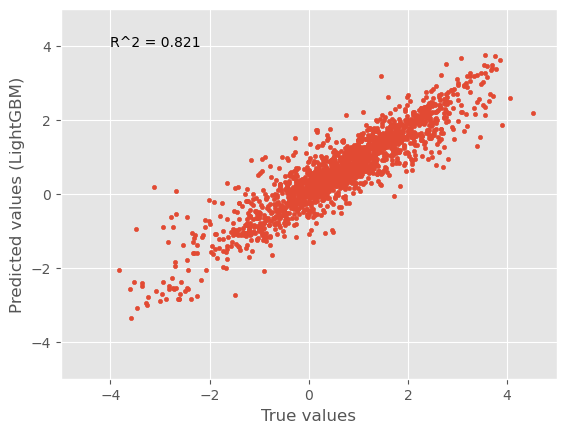

In [164]:
# Scatter plot

limits = -5,5
plt.figsize=(10,10)

plt.scatter(svm_5preds['y_test0'], svm_5preds['y_pred_svm_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (LightGBM)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(svm_5preds['y_test0'], svm_5preds['y_pred_svm_ave'])), (-4, 4))
plt.show()

In [165]:
#cross valide using this optimized SVR 
svm_baseline_CVscore = cross_val_score(svm_reg, X, Y, cv=10, scoring="r2")
#cv_svm_opt_testSet = cross_val_score(optimized_svm, X, Y, cv=10, scoring="r2")
cv_svm_opt = cross_val_score(optimizedCV_svm, X, Y, cv=10, scoring="r2")
print("SVM baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(svm_baseline_CVscore), np.std(svm_baseline_CVscore, ddof=1)))
#print("SVM optimized model (tested on Y_te) r2_score %0.4f with a standard deviation of %0.4f" % (svm_baseline_CVscore.mean(), svm_baseline_CVscore.std()))
print("SVM optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_svm_opt), np.std(cv_svm_opt, ddof=1)))

SVM baseline model r2_score 0.6985 with a standard deviation of 0.0390
SVM optimized model r2_score 0.7276 with a standard deviation of 0.0375


In [166]:
joblib.dump(svm_reg, "OUTPUT/svm_reg_withSemiSel.joblib")
joblib.dump(optimizedCV_svm, "OUTPUT/optimizedCV_svm_withSemiSel.joblib")

['OUTPUT/optimizedCV_svm_withSemiSel.joblib']

In [167]:
# save the evaluation results of test set 

with pd.ExcelWriter("OUTPUT/TestSet_EvaluationResults_withSemiSel.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    mat_met_rf_test.to_excel(writer, sheet_name="RF", )
    mat_met_lgbm_test.to_excel(writer, sheet_name="LGBM", )
    mat_met_xgb_test.to_excel(writer, sheet_name="XGB", )
    mat_met_knn_test.to_excel(writer, sheet_name="KNN", )
    mat_met_svm_test.to_excel(writer, sheet_name="SVM", )
   

In [168]:
# save the evaluation results of Optimized and saved models to an Excel file

with pd.ExcelWriter("OUTPUT/EvaluationResults_withSemiSel.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    mat_met_optimized_rf.to_excel(writer, sheet_name="RF", )
    mat_met_optimized_lgbm.to_excel(writer, sheet_name="LGBM", )
    mat_met_optimized_xgb.to_excel(writer, sheet_name="XGB", )
    mat_met_optimized_knn.to_excel(writer, sheet_name="KNN", )
    mat_met_optimized_svm.to_excel(writer, sheet_name="SVM", )

In [169]:
# save the evaluation results of Optimized and saved models to an Excel file

with pd.ExcelWriter("OUTPUT/PredResults_withSemiSel.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    rf_5preds.to_excel(writer, sheet_name="RF", )
    lgbm_5preds.to_excel(writer, sheet_name="LGBM", )
    xgb_5preds.to_excel(writer, sheet_name="XGB", )
    knn_5preds.to_excel(writer, sheet_name="KNN", )
    svm_5preds.to_excel(writer, sheet_name="SVM", )